## Download the ling-spam dataset

We directly download the lingspam_public.tar.gz file into sample_data folder where google colab stores the data and extract it itno lingspam_public folder.

The code for downloading the ling-spam dataset is a modified version of code from
"Downloading and extracting archived files" article.
For more details see:
https://upengareri.github.io/notes/python/downloading_and_extracting/

In [1]:
# all necessary imports
import os
import tarfile
import requests
import re
import sys
import numpy as np
from string import punctuation 
import warnings
import time
warnings.filterwarnings('ignore')
# for evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import pandas as pd
import seaborn.apionly as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc_file_defaults()
# for comparing results
from sklearn.naive_bayes import BernoulliNB
# for SVM
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold

Select online or offline version:

In [2]:
colab = False

The cell below downloads the lingspam_public.tar.gz into sample_data folder.

In [3]:
if colab:
    url = "http://www.aueb.gr/users/ion/data/lingspam_public.tar.gz"
    filename = os.path.basename(url)
    file_location = "/content/sample_data/lingspam_public.tar.gz"


    print(f"Downloading file from {url} to {file_location}.")
    # Download
    with open(file_location, 'wb') as f:
        with requests.get(url, allow_redirects=True, stream=True) as resp:
            for chunk in resp.iter_content(chunk_size = 512):  
                if chunk:
                    f.write(chunk)

    print("Finished downloading.")

The cell below extracts the downloaded file lingspam_public.tar.gz into sample_data/lingspam_public folder.

In [4]:
if colab:
    target_path ="/content/sample_data/"

    print("Extracting tar file")
    tarf = tarfile.open(file_location, 'r')
    tarf.extractall(target_path)
    tarf.close()
    print("Finished extracting.")

We will be using the "lingspam_public01" corpus with enabled lemmatization and stop-words (in /content/sample_data/lingspam_public/lemm_stop folder). We will be using spam mails from "part1" - "part9" folders for training and mails from "part10" forlder for testing.

In [5]:
if colab:
    data_path ="/content/sample_data/lingspam_public/lemm_stop/"
else:
    data_path = '/Users/vahan/Desktop/NYUAD PhD PROGRAM/COURSES/EL-GY-9163 MACHINE LEARNING FOR CYBER-SECURITY/MATERIALS/ECE-GY-9163-ML-for-Cyber-Security-main/A1/lingspam_public/lemm_stop/'


We will be using the "lingspam_public01" corpus with enabled lemmatization and stop-words (in /content/sample_data/lingspam_public/lemm_stop folder). The training set is the spam mails from "part1" - "part9" folders and mails from "part10" folder are used testing.

The ling-spam dataset contains 2893 messages, 2412 messages are legit and 481 spam (https://www.kaggle.com/mandygu/lingspam-dataset). The spam messages have "sp" prefix in filename. The code below counts the number of spam/legit emails base on the "sp" prefix in filenames (the sample code is used from https://www.pythontutorial.net/python-basics/python-read-text-file/):

In [6]:
#calculating the number of spam/legit mails
numSpamMails = 0
numLegitMails = 0
for i in range(1,11):
    current_dir = data_path+"part"+str(i)
    #print(current_dir)
    for f in os.listdir(current_dir):
        if f[0:2] == "sp": #if the prefix of the file is "sp" then increase the counter of spam mails by 1
            #print(f)
            numSpamMails = numSpamMails + 1
        else:
            numLegitMails = numLegitMails + 1

print("number of spam  mails = {0:d}".format(numSpamMails))
print("number of legit mails = {0:d}".format(numLegitMails))

number of spam  mails = 481
number of legit mails = 2412



Before performing the feature selection with IG we need to preprocess each file. Notice that we are using already  cleaned and lemmatized version of ling-spam dataset from lemm-stop folder.

However, there are some punctuation marks such as ',', '.', spaces and new lines are left and they need to be removed. Actually, it might make sense to preserve some punctuation marks as '!', '?', '$\$$' since the abundance of exclamation marks might indicate the spam email. However, experimenting with leaving the following punctuation marks   "$\!\#$\%&()*+/<=>?@\[\\\]^_`\{|\}~$" led to the lower values of spam recall/precision (e.g. spam reacall/precision for Bernoully NB were 0.67/0.94, 0.67/1.0 and 0.59/1.0 for 10,100,1000 top words correspondingly; spam reacall/precision for Multinomial NB with TF were 0.93/0.9, 0.89/0.95 and 0.53/1.0 for 10,100,1000 top words, and spam reacall/precision for Multinomial NB with Binary Features were 0.93/0.9, 0.93/0.95 and 0.81/1.0 for 10,100,1000 top words. Also, the exclamation sign was assigned the highest IG value. Therefore,I decided to remove all the punctuation marks from the mail).

We are also interested in removing numbers to reduce the size of the dictionary, although some spam emails might contain numbers, e.g. the amount that the user "won" and etc.

The following code has been reused:

For removing newlines,spaces and tabs: https://www.kite.com/python/answers/how-to-remove-spaces,-tabs,-and-newlines-in-a-string-in-python#:~:text=Use%20str.,a%20list%20based%20on%20whitespace.

Regex to remove specific punctuation marks: https://stackoverflow.com/questions/3939361/remove-specific-characters-from-a-string-in-python

Regex to remove numbers: https://stackoverflow.com/questions/12851791/removing-numbers-from-string

Removing spaces before/after text: https://www.w3schools.com/python/ref_string_strip.asp


In [7]:
from sklearn.feature_extraction import _stop_words
# for one particular email 
with open(data_path+"part1/3-404msg6.txt") as tmpf:
    lines = tmpf.readlines()

newLines = []
for line in lines:
    line = line.strip()# remove spaces at the beginning and at the end
    line = re.sub(r'[^\w\s]','',line)#remove all punctuation marks
    line = re.sub(r'[0-9]+', '', line)# remove numbers
    line = line.lower() # make everything lowercase
    line = line.split()# remove spaces, tabs, newlines
    newLines.extend(line)
    
newLines.remove('subject')# we also want to remove word "Subject" at the beginning of every mail

preprocessedLines = []
for w in newLines:
    if len(w)> 2 and w not in _stop_words.ENGLISH_STOP_WORDS:# we are not interested in words that consist of one letter
        preprocessedLines.append(w)
print(preprocessedLines)
print(len(preprocessedLines))

['chomsky', 'citation', 'surprise', 'number', 'chomsky', 'citation', 'nature', 'agree', 'linguistics', 'owe', 'current', 'status', 'chomsky', 'work', 'ought', 'overemphasize', 'political', 'citation', 'clearly', 'linguistic', 'drove', 'vickus', 'nobel', 'prize', 'winner', 'citation', 'speak', 'point', 'let', 'shun', 'profession', 'honor', 'favorite', 'woody', 'allan', 'whore', 'mensa', 'road', 'lot', 'lonely', 'sure', 'guy', 'meet', 'bimbo', 'want', 'really', 'brainy', 'woman', 'easy', 'short', 'notice', 'hear', 'young', 'girl', 'price', 'discuss', 'subject', 'symbolism', 'extra', 'suppose', 'want', 'noam', 'chomsky', 'explain', 'girl', 'cost', 'hasten', 'disassociate', 'sexism', 'citation', 'lyle', 'campbell']
72


Now we can use this approach to process training and testing datasets:

Training: part1 to part9

Testing: part10

In [8]:
# to process a training set data
spam_train = []
legit_train = []

# we use part1 to part9 as training set
for i in range(1,10):
    current_dir = data_path+"part"+str(i)
    for f in os.listdir(current_dir):
        if f[0:2] == "sp": #if the prefix of the file is "sp" then increase the counter of spam mails by 1
            with open(current_dir+'/'+f) as tmpf:
                lines = tmpf.readlines()
            newLines = []
            for line in lines:
                line = line.strip()# remove spaces at the beginning and at the end
                line = re.sub(r'[^\w\s]','',line)#remove all punctuation marks
                line = re.sub(r'[0-9]+', '', line)# remove numbers
                line = line.lower() # make everything lowercase
                line = line.split()# remove spaces, tabs, newlines
                newLines.extend(line)
            newLines.remove('subject')# we also want to remove word "Subject" at the beginning of every mail

            preprocessedLines = [] # the list of words left after preprocessing in the mail 
        
            for w in newLines:
                if len(w)> 2 and w not in _stop_words.ENGLISH_STOP_WORDS:# we are not interested in words that consist of one letter 
                    preprocessedLines.append(w)
            spam_train.append(preprocessedLines)
        else:
            with open(current_dir+'/'+f) as tmpf:
                lines = tmpf.readlines()
            newLines = []
            for line in lines:
                line = line.strip()# remove spaces at the beginning and at the end
                line = re.sub(r'[^\w\s]','',line)#remove all punctuation marks
                line = re.sub(r'[0-9]+', '', line)# remove numbers
                line = line.lower() # make everything lowercase
                line = line.split()# remove spaces, tabs, newlines
                newLines.extend(line)
            newLines.remove('subject')# we also want to remove word "Subject" at the beginning of every mail

            preprocessedLines = [] # the list of words left after preprocessing in the mail 
        
            for w in newLines:
                if len(w)>2 and w not in _stop_words.ENGLISH_STOP_WORDS:# we are not interested in words that consist of one letter
                    preprocessedLines.append(w)
            legit_train.append(preprocessedLines)
            
print("number of spam emails in spam training set   = {0:d}".format(len(spam_train)))
print("number of legit emails in legit training set = {0:d}".format(len(legit_train)))



number of spam emails in spam training set   = 432
number of legit emails in legit training set = 2170


In [9]:
# to process a testing set data
spam_test = []
legit_test = []

# we use part10 as testing set
current_dir = data_path+"part10"
for f in os.listdir(current_dir):
    if f[0:2] == "sp": #if the prefix of the file is "sp" then increase the counter of spam mails by 1
        with open(current_dir+'/'+f) as tmpf:
            lines = tmpf.readlines()
        newLines = []
        for line in lines:
            line = line.strip()# remove spaces at the beginning and at the end
            line = re.sub(r'[^\w\s]','',line)#remove all punctuation marks
            line = re.sub(r'[0-9]+', '', line)# remove numbers
            line = line.lower() # make everything lowercase
            line = line.split()# remove spaces, tabs, newlines
            newLines.extend(line)
        newLines.remove('subject')# we also want to remove word "Subject" at the beginning of every mail

        preprocessedLines = [] # the list of words left after preprocessing in the mail 

        for w in newLines:
            if len(w)>2 and w not in _stop_words.ENGLISH_STOP_WORDS:# we are not interested in words that consist of one letter 
                preprocessedLines.append(w)
        spam_test.append(preprocessedLines)
    else:
        with open(current_dir+'/'+f) as tmpf:
            lines = tmpf.readlines()
        newLines = []
        for line in lines:
            line = line.strip()# remove spaces at the beginning and at the end
            line = re.sub(r'[^\w\s]','',line)#remove all punctuation marks
            line = re.sub(r'[0-9]+', '', line)# remove numbers
            line = line.lower() # make everything lowercase
            line = line.split()# remove spaces, tabs, newlines
            newLines.extend(line)
        newLines.remove('subject')# we also want to remove word "Subject" at the beginning of every mail

        preprocessedLines = [] # the list of words left after preprocessing in the mail 

        for w in newLines:
            if len(w)>2 and w not in _stop_words.ENGLISH_STOP_WORDS:# we are not interested in words that consist of one letter
                preprocessedLines.append(w)
        legit_test.append(preprocessedLines)

print("number of spam emails in spam testing set   = {0:d}".format(len(spam_test)))
print("number of legit emails in legit testing set = {0:d}".format(len(legit_test)))

number of spam emails in spam testing set   = 49
number of legit emails in legit testing set = 242


We are also inteested in unique words in training spam and legit set.

In [10]:
# here we create a corpora of unique words found in training spam and legit datasets
allSpamWords = []
for w in spam_train:
    allSpamWords.extend(w)

allLegitWords = []
for w in legit_train:
    allLegitWords.extend(w)

allTrainingWords = []
allTrainingWords.extend(allSpamWords)
allTrainingWords.extend(allLegitWords)

print("number of all words in spam training set     = {0:d}".format(len(allSpamWords)))
print("number of all words in legit training set    = {0:d}".format(len(allLegitWords)))
print("total number of words in whole training set  = {0:d}".format(len(allTrainingWords)))

allUniqueSpamWords=set(allSpamWords)
allUniqueLegitWords=set(allLegitWords)
allUniqueTrainingWords=set(allTrainingWords)

print("number of unique words in spam training set  = {0:d}".format(len(allUniqueSpamWords)))
print("number of unique words in legit training set = {0:d}".format(len(allUniqueLegitWords)))
print("number of unique words in whole training set = {0:d}".format(len(allUniqueTrainingWords)))

number of all words in spam training set     = 106375
number of all words in legit training set    = 491404
total number of words in whole training set  = 597779
number of unique words in spam training set  = 8387
number of unique words in legit training set = 43940
number of unique words in whole training set = 47481


For convenience we will use dictionaries to store the words as keys and their number of occurences as values:

In [11]:
# for spam training dataset:
spamWordsTrainDict={}
for w in allUniqueTrainingWords:
    count = 0
    for spamMail in spam_train:
        if w in spamMail:
            count+=1
        if count is not 0:
            spamWordsTrainDict[w]=count
#print(spamWordsTrainDict)

In [12]:
# for legit training dataset:
legitWordsTrainDict={}
for w in allUniqueTrainingWords:
    count = 0
    for legitMail in legit_train:
        if w in legitMail:
            count+=1
        if count is not 0:
            legitWordsTrainDict[w]=count
#print(legitWordsTrainDict)

# Calculating information gain (IG)

For IG calculation we assume that only training set is given. First we need to check how many spam/legit emails are in the trainign dataset.

In [13]:
#calculating the number of spam/legit mails in training
numSpamMailsTrain = 0
numLegitMailsTrain = 0
for i in range(1,10):
    current_dir = data_path+"part"+str(i)
    #print(current_dir)
    for f in os.listdir(current_dir):
        if f[0:2] == "sp": #if the prefix of the file is "sp" then increase the counter of spam mails by 1
            #print(f)
            numSpamMailsTrain = numSpamMailsTrain + 1
        else:
            numLegitMailsTrain = numLegitMailsTrain + 1

print("number of spam  mails in training = {0:d}".format(numSpamMailsTrain))
print("number of legit mails in training = {0:d}".format(numLegitMailsTrain))


number of spam  mails in training = 432
number of legit mails in training = 2170


We need these values to calculate the entropy $H(C)$, where $C$ is a random variable that determines if a document is spam or legit:

$H(C) = -\sum_{c}P\{C=c\}\log(P\{C=c\})$

For Bernoully random variables $C \in \{0,1\}, P\{C=1\} = p $ and 
$H(C) = -p\log(p) - (1-p)\log(1-p)$

Where $p$ is the probability of email being spam, i.e.

$p = \frac{N_{spam}}{N_{total}} = \frac{N_{spam}}{N_{spam}+N_{legit}}$,

where $N_{total}$ -- the total number of mails, $N_{spam}$ -- number of spam mails and $N_{legit}$ -- number of legitimate mails. 

However, we need to use Laplacian smoothing to ensure non-zero probability for terms that don't occur in any spam email in training dataset:

$p =  \frac{N_{spam}+1}{N_{spam}+N_{legit}+2}$.

Thus:

In [14]:
# calculating H(C)
p = (numSpamMailsTrain+1)/(numSpamMailsTrain + numLegitMailsTrain +2)
HC = -p*np.log(p) - (1-p)*np.log(1-p) 
print("The entropy of training set is = {0:.6f}".format(HC))

The entropy of training set is = 0.449943


## Calculating the info gain for each word

The information gain $IG(C)$ for a random variable $C$ that determines if a document is spam or legit is given by formula:

$IG(C) = H\{C\} - H\{C|x_i\}$,

where, given a document alone, $H\{C\}$ is an inherent uncertainty (entropy) in predicting legit or spam and $H\{C|X_i\}$ -- conditional entropy which is an uncertainty in predicting legit or spam given term $X_i$ is present in the document.

By definition the conditional entropy can be calculated as:

$H\{C|X_i\} = \sum_{x}P\{X_i=x\}H\{C|X=x\} = -\sum_{x,c}P\{X_i=x,C=c\}\log \left(P\{C=c|X_i=x\}\right) = -\sum_{c\in\{spam,legit\}}\sum_{x\in\{0,1\}}P\{X_i=x,C=c\} \log\left(P\{C=c|X_i=x\}\right)$,

where

$P\{X_i=x,C=c\}=P\{X_i=x|C=c\}P\{C=c\}$

$P\{C=c|X_i=x\} = \frac{P\{X_i=x|C=c\}P\{C=c\}}{P\{X_i=x\}}$

Thus we have to compute the four cases: when $C$ is spam or legit and when $X_i$ either in the document ($x = 1$) or not in the document ($x = 0$):

Let's denote $\text{totalNumberWordSpam}$ the number of times the current word occurs in spam documents and $\text{totalNumberWordLegit}$ the number of times the current word occurs in legit documents. $\text{numSpamMails}$ and $\text{numLegitMails}$ are number of spam and legit documents correspondingly, thus (with Laplacian smooting):


$H\{C = spam|x = 1\} = \frac{\text{totalNumberWordSpam}+1}{\text{numSpamMails} + 2}\frac{\text{numSpamMails}+1}{\text{numSpamMails} + \text{numLegitMails}+2} \cdot \log\left(\frac{\text{totalNumberWordSpam}+1}{\text{numSpamMails} + 2}\frac{\frac{\text{numSpamMails} +1}{\text{numSpamMails}+\text{numLegitMails} +2}}{\frac{\text{totalNumberWordSpam} + \text{totalNumberWordLegit}+1}{\text{numSpamMails}+\text{numLegitMails} +2}}\right)$

$H\{C = legit|x = 1\} = \frac{\text{totalNumberWordLegit}+1}{\text{numLegitMails} + 2}\frac{\text{numLegitMails}+1}{\text{numSpamMails} + \text{numLegitMails}+2} \cdot \log\left(\frac{\text{totalNumberWordLegit}+1}{\text{numLegitMails} + 2}\frac{\frac{\text{numLegitMails} +1}{\text{numSpamMails}+\text{numLegitMails} +2}}{\frac{\text{totalNumberWordSpam} + \text{totalNumberWordLegit}+1}{\text{numSpamMails}+\text{numLegitMails} +2}}\right)$


$H\{C = spam|x = 0\} = \frac{\text{numSpamMails} - \text{totalNumberWordSpam}+1}{numSpamMails+2} \frac{numSpamMails+1}{\text{numSpamMails} + \text{numLegitMails}+2}\cdot \log\left(\frac{\text{numSpamMails} -\text{totalNumberWordSpam}+1}{\text{numSpamMails}+2}\frac{\frac{\text{numSpamMails}+1}{\text{numSpamMails}+\text{numLegitMails}+2}}{\frac{\text{numSpamMails} - \text{totalNumberWordSpam} + \text{numLegitMails} - \text{totalNumberWordLegit}+1}{{\text{numSpamMails}+\text{numLegitMails}+2}}}\right)$

$H\{C = legit|x = 0\} = \frac{\text{numLegitMails} - \text{totalNumberWordLegit}+1}{numLegitMails+2} \frac{numLegitMails+1}{\text{numSpamMails} + \text{numLegitMails}+2}\cdot \log\left(\frac{\text{numLegitMails} -\text{totalNumberWordLegit}+1}{\text{numLegitMails}+2}\frac{\frac{\text{numLegitMails}+1}{\text{numSpamMails}+\text{numLegitMails}+2}}{\frac{\text{numSpamMails} - \text{totalNumberWordSpam} + \text{numLegitMails} - \text{totalNumberWordLegit}+1}{{\text{numSpamMails}+\text{numLegitMails}+2}}}\right)$

and finally,

$H\{C|X_i\} = (-1)\cdot\left(H\{C = spam|x = 0\} + H\{C = legit|x = 1\}+ H\{C = spam|x = 0\} + H\{C = legit|x = 0\}\right)$

In [15]:
InfoGainTotal = {}
for word in allUniqueTrainingWords:
    if word in spamWordsTrainDict:# if the term is in spam dictionary take the number of times it occurs
        totalNumberWordSpam = spamWordsTrainDict[word]
    else:# if the term is absent in spam dictionary set its number of occurences to 1
        totalNumberWordSpam = 1
    if word in legitWordsTrainDict: # if the term is in legit dictionary take the number of times it occurs 
        totalNumberWordLegit = legitWordsTrainDict[word]
    else:# if the term is absent in legit dictionary set its number of occurences to 1
        totalNumberWordLegit=1
        
    HC_spam_X_1 =((totalNumberWordSpam+1)/(numSpamMails+2)) * (numSpamMails+1)/(numSpamMails + numLegitMails+2) * np.log(((totalNumberWordSpam+1)/(numSpamMails+2)) * ((numSpamMails+1)/(numSpamMails + numLegitMails+2))/((totalNumberWordSpam+totalNumberWordLegit+1)/(numSpamMails + numLegitMails+2))) 
    
    HC_legit_X_1 = ((totalNumberWordLegit+1)/(numLegitMails+2)) * ((numLegitMails+1)/(numSpamMails + numLegitMails+2)) * np.log(((totalNumberWordLegit+1)/(numLegitMails+2)) * ((numLegitMails+1)/(numSpamMails + numLegitMails+2))/((totalNumberWordSpam+totalNumberWordLegit+1)/(numSpamMails + numLegitMails+2)))           
        
    HC_spam_X_0 =((numSpamMails-totalNumberWordSpam+1)/(numSpamMails+2)) * ((numSpamMails+1)/(numSpamMails + numLegitMails+2)) * np.log(((numSpamMails-totalNumberWordSpam+1)/(numSpamMails+2)) * ((numSpamMails+1)/(numSpamMails + numLegitMails+2))/((numSpamMails-totalNumberWordSpam + numLegitMails  -  totalNumberWordLegit+1)/(numSpamMails + numLegitMails+2)))

    HC_legit_X_0= ((numLegitMails-totalNumberWordLegit+1)/(numLegitMails+2)) * ((numLegitMails+1)/(numSpamMails + numLegitMails+2)) * np.log(((numLegitMails-totalNumberWordLegit+1)/(numLegitMails+2)) * ((numLegitMails+1)/(numSpamMails + numLegitMails+2))/((numSpamMails-totalNumberWordSpam + numLegitMails  - totalNumberWordLegit+1)/(numSpamMails + numLegitMails+2))) 

    HCX = (-1)*(HC_spam_X_1 + HC_legit_X_1 + HC_spam_X_0 + HC_legit_X_0)

    # calculate the IG for a given term
    InfoGainTotal[word] = HC - HCX

#print(InfoGainTotal)

There are different ways of sorting words in InfoGainTotal dictionary based on IG values:

In [16]:
#sort as list https://careerkarma.com/blog/python-sort-a-dictionary-by-value/
InfoGainTotalSortedList =  sorted(InfoGainTotal.items(), key=lambda x: x[1], reverse=True)
#sort as dictionary https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
InfoGainTotalSortedDict={k: v for k, v in sorted(InfoGainTotal.items(), key=lambda item: item[1], reverse=True)}
#print(InfoGainTotalSortedList)
#print(InfoGainTotalSortedDict)

## Selecting top N features for the training data based on IG

### Top 10 features:

In [17]:
selectedWords_10 =[]
selectedWordsIGValues_10 =[]

print(" {0:s} {1:15s} {2:2s}".format("#","words","IG"))
for i in range(10):
    selectedWords_10.append(InfoGainTotalSortedList[i][0])
    selectedWordsIGValues_10.append(InfoGainTotalSortedList[i][1])
    print("{0:2d} {1:15s} {2:2.5f}".format(i+1,selectedWords_10[i],selectedWordsIGValues_10[i]))

 # words           IG
 1 language        0.11773
 2 remove          0.10276
 3 free            0.09933
 4 linguistic      0.08568
 5 university      0.08437
 6 money           0.07218
 7 click           0.06179
 8 market          0.05647
 9 business        0.05289
10 today           0.04923


### Top 100 features:

In [18]:
selectedWords_100 =[]
selectedWordsIGValues_100 =[]

print(" {0:s} {1:15s} {2:2s}".format("#","words","IG"))
for i in range(100):
    selectedWords_100.append(InfoGainTotalSortedList[i][0])
    selectedWordsIGValues_100.append(InfoGainTotalSortedList[i][1])
    print("{0:2d} {1:15s} {2:2.5f}".format(i+1,selectedWords_100[i],selectedWordsIGValues_100[i]))

 # words           IG
 1 language        0.11773
 2 remove          0.10276
 3 free            0.09933
 4 linguistic      0.08568
 5 university      0.08437
 6 money           0.07218
 7 click           0.06179
 8 market          0.05647
 9 business        0.05289
10 today           0.04923
11 advertise       0.04837
12 product         0.04804
13 company         0.04701
14 sell            0.04698
15 million         0.04596
16 internet        0.04471
17 income          0.04463
18 english         0.04419
19 day             0.04307
20 save            0.04238
21 linguistics     0.04207
22 guarantee       0.04203
23 thousand        0.04188
24 easy            0.04109
25 best            0.04090
26 purchase        0.03965
27 check           0.03932
28 buy             0.03921
29 cash            0.03904
30 win             0.03861
31 bulk            0.03824
32 dollar          0.03782
33 cost            0.03757
34 want            0.03745
35 service         0.03700
36 mailing         0.03612
37 edu

### Top1000 features:

In [19]:
selectedWords_1000 =[]
selectedWordsIGValues_1000 =[]

print(" {0:s} {1:15s} {2:2s}".format("  #","words","IG"))
for i in range(1000):
    selectedWords_1000.append(InfoGainTotalSortedList[i][0])
    selectedWordsIGValues_1000.append(InfoGainTotalSortedList[i][1])
    print("{0:4d} {1:15s} {2:2.9f}".format(i+1,selectedWords_1000[i],selectedWordsIGValues_1000[i]))

   # words           IG
   1 language        0.117733914
   2 remove          0.102759696
   3 free            0.099325998
   4 linguistic      0.085675883
   5 university      0.084366282
   6 money           0.072184191
   7 click           0.061791610
   8 market          0.056471930
   9 business        0.052892512
  10 today           0.049228091
  11 advertise       0.048373328
  12 product         0.048040493
  13 company         0.047014977
  14 sell            0.046977360
  15 million         0.045957359
  16 internet        0.044713465
  17 income          0.044631163
  18 english         0.044185128
  19 day             0.043071129
  20 save            0.042384167
  21 linguistics     0.042065444
  22 guarantee       0.042029376
  23 thousand        0.041877813
  24 easy            0.041091030
  25 best            0.040899297
  26 purchase        0.039647799
  27 check           0.039323225
  28 buy             0.039208915
  29 cash            0.039043973
  30 win           

# Implementation of Bernoulli Naive Bayes Classifier

##  Bernoulli NB  Classifier

For Bernoulli NB classifier we need to compare:

$P\{spam|x\} = \frac{P\{x|spam\}P\{spam\}}{P\{x\}}$

and 

$P\{legit|x\} = \frac{P\{x|legit\}P\{legit\}}{P\{x\}}$

Here

$P\{x\} = P\{spam\}P\{x|spam\} +P\{legit\}P\{x|legit\}$,

$P\{x|spam\} = P\{x_1,x_2,...,x_m|spam\}=\prod_{i=1}^M p^{x_i}_{i,s}\left(1-p_{i,s}\right)^{1-x_i}$,

where

$p_{i,s} = P\{x_i=1|spam\}$

probability of occurence of term $X_i$ in email conditioned that email is spam.

With Laplacian smoothing

$p_{i,s} = P\{x_i=1|spam\} = \frac{\text{totalNumberWordSpam}+1}{\text{numSpamMailsTrain}+2}$

where $\text{totalNumberWordSpam}$ the number of times the current word (term $X_i$) occurs in spam documents in the training set and $\text{numSpamMailsTrain}$ total number of spam documents in the training set.

$P\{spam\} = \frac{\text{numSpamMailsTrain}+1}{\text{numSpamMailsTrain} + \text{numLegitMailsTrain} +2} $

and

$P\{legit\} = \frac{\text{numLegitMailsTrain}+1}{\text{numSpamMailsTrain} + \text{numLegitMailsTrain} +2} $

where $\text{numSpamMailsTrain}$ -- number of spam mails in training set, $\text{numLegitMailsTrain}$ -- number of legit mails in the training set.

thus:

$P\{spam|x\} = \frac{P\{x|spam\}P\{spam\}}{P\{x\}}= \frac{P\{spam\}\prod_{i=1}^M p^{x_i}_{i,s}\left(1-p_{i,s}\right)^{1-x_i}}{\sum_{c\in\{spam,legit\}}P(c)\prod_{i=1}^M p^{x_i}_{i,s}\left(1-p_{i,s}\right)^{1-x_i}}$ 

$P\{legit|x\} = \frac{P\{x|legit\}P\{legit\}}{P\{x\}}= \frac{P\{legit\}\prod_{i=1}^M p^{x_i}_{i,h}\left(1-p_{i,h}\right)^{1-x_i}}{\sum_{c\in\{spam,legit\}}P(c)\prod_{i=1}^M p^{x_i}_{i,h}\left(1-p_{i,h}\right)^{1-x_i}}$ 


To determine if the mail is spam or legit we need to look at the ratio:

$r = \frac{P\{spam|x\}}{P\{legit|x\}} = \frac{P\{spam\}\prod_{i=1}^M p^{x_i}_{i,s}\left(1-p_{i,s}\right)^{1-x_i}}{P\{legit\}\prod_{i=1}^M p^{x_i}_{i,h}\left(1-p_{i,h}\right)^{1-x_i}}$

If $r>1$ the given mail is spam and if less than or equal 1 -- legit.



## Bernoulli NB for 10-top words
First we need to convert everything into binary feature vectors:

In [20]:
# for 10 features:

# convert everything into binary vectors
selectedWords_10np = np.asarray(selectedWords_10)

# create data for spam train
spam_train_binary = []
spam_train_labels = []
for mail in spam_train:
    features = np.zeros(10)
    for w in selectedWords_10:
        if w in mail:
            index = np.where(selectedWords_10np == w)[0]
            features[index[0]]=1
    spam_train_binary.append(features)
    spam_train_labels.append(1)
#print(spam_train_binary)


# create data for legit train
legit_train_binary = []
legit_train_labels = []
for mail in legit_train:
    features = np.zeros(10)
    for w in selectedWords_10:
        if w in mail:
            index = np.where(selectedWords_10np == w)[0]
            features[index[0]]=1
    legit_train_binary.append(features)
    legit_train_labels.append(0)
#print(legit_train_binary)

# create data for spam test
spam_test_binary = []
spam_test_labels = []
for mail in spam_test:
    features = np.zeros(10)
    for w in selectedWords_10:
        if w in mail:
            index = np.where(selectedWords_10np == w)[0]
            features[index[0]]=1
    spam_test_binary.append(features)
    spam_test_labels.append(1)
#print(spam_test_binary)


# create data for legit test
legit_test_binary = []
legit_test_labels = []
for mail in legit_test:
    features= np.zeros(10)
    for w in selectedWords_10:
        if w in mail:
            index = np.where(selectedWords_10np == w)[0]
            features[index[0]]=1
    legit_test_binary.append(features)
    legit_test_labels.append(0)
#print(legit_test_binary)


Then we use these featue vectors to calculate probabilities for Bernoulli NB:

In [21]:
totalTestData = spam_test_binary.copy()
totalTestData.extend(legit_test_binary)

totalTestLabels = spam_test_labels.copy()
totalTestLabels.extend(legit_test_labels)

pSpamX_all = []
pLegitX_all = []

# for all test data:
spamP = (numSpamMailsTrain+1)/(numSpamMailsTrain + numLegitMailsTrain +2)
legitP = (numLegitMailsTrain+1)/(numSpamMailsTrain + numLegitMailsTrain +2)
latency = []
predLabels = []
for features in totalTestData:
    start = time.time()
    spamPX = 1  # probability of X given spam
    legitPX = 1 # probability of X given legit

    totalNumberWordSpam = 0
    totalNumberWordLegit = 0
    i=0
    for word in selectedWords_10:
        if word in spamWordsTrainDict:
            totalNumberWordSpam = spamWordsTrainDict[word]
        else:
            totalNumberWordSpam = 1
        if word in legitWordsTrainDict:
            totalNumberWordLegit = legitWordsTrainDict[word]
        else:
            totalNumberWordLegit = 1
        pSpam = (totalNumberWordSpam+1)/(numSpamMailsTrain+2)    #p_{i,s} for spam
        pLegit = (totalNumberWordLegit+1)/(numLegitMailsTrain+2) #p_{i,s} for legit
        spamPX = spamPX * (pSpam**features[i]) * ((1 - pSpam)**(1 - features[i]))    #p{x|spam}
        legitPX = legitPX * (pLegit**features[i]) *((1 - pLegit)**(1 - features[i])) #p{x|legit}
        i+=1

    pSpamX = (spamPX * spamP) / ((spamP * spamPX) + (legitP * legitPX)) # P{spam|x}
    pLegitX = (legitPX * legitP) / ((spamP * spamPX) + (legitP * legitPX))# P{legit|x}
    
    pSpamX_all.append(pSpamX)
    pLegitX_all.append(pLegitX)
    
    r = pSpamX/pLegitX
    if  r > 1:
        yhat = 1
    else:
        yhat = 0
    predLabels.append(yhat)
    end = time.time()
    latency.append(end-start)
latency_NB_Bernoulli_10 = latency

## Evaluate predictions with 10-top words

We are mostly interested in spam precision and spam recall.

Spam Precision (SP) is the fraction of correctly classified spam messages out all messages classified as spam.

$\text{SP} = \frac{numSpamMessagesCorrectlyClassified}{numSpamMailsClassifiedAsSpam} = \frac{numSpamPredictedAsSpam}{numSpamPredictedAsSpam+numLegitPredictedAsSpam} = \frac{truePositives}{truePositives+falsePositives}$

Spam Recall is the fraction of all correctly classified spam emails to all spam emails:

$\text{SR} = \frac{numSpamMessagesCorrectlyClassified}{numAllSpamMails}= \frac{numSpamPredictedAsSpam}{numSpamPredictedAsSpam+numSpamPredictedAsLegit} = \frac{truePositives}{truePositives+falseNegatives}$

Given a confusion matrix:

C = $\begin{bmatrix}
trueNegatives & falsePositives \\
falseNegatives & truePositives
\end{bmatrix}$

spam precision and spam recall could be determined as (indices are in numpy notation):

$\text{SP} = \frac{C[1,1]}{C[1,1]+C[0,1]}$

$\text{SR} = \frac{C[1,1]}{C[1,1]+C[1,0]}$

confusion matrix: 
[[235   7]
 [  9  40]]
accuracy:                               0.945017

spam precision (built-in function):     0.851064
spam precision (from confusion matrix): 0.851064

recall (built-in function):             0.816327
recall (from confusion matrix):         0.816327

f1:                                     0.833333
average latency:                        0.000030 sec.


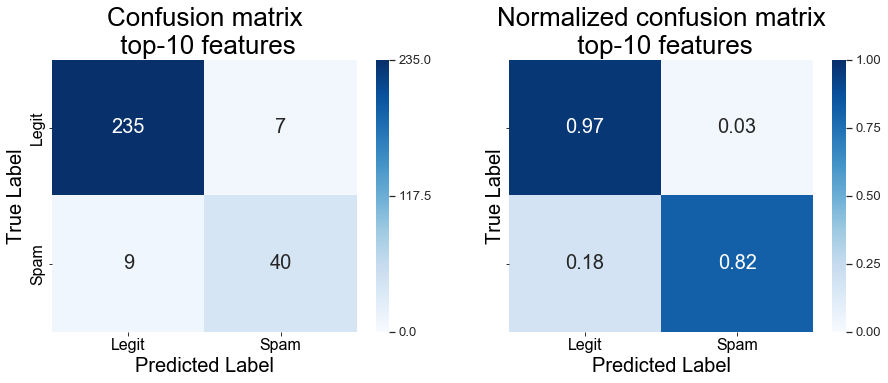

In [22]:
cm_NB_Bernoulli_10 = confusion_matrix(totalTestLabels, predLabels)
print("confusion matrix: ")
print(cm_NB_Bernoulli_10)

# calculates precision
accuracy_NB_Bernoulli_10 = accuracy_score(totalTestLabels, predLabels)
print('accuracy:                               %.6f\n' % accuracy_NB_Bernoulli_10)

# calculates precision. By default positive label is 1, therefore it is spam precision.
precision_NB_Bernoulli_10 = precision_score(totalTestLabels, predLabels)
print('spam precision (built-in function):     %.6f' % precision_NB_Bernoulli_10)

# calculates precision using confusion matrix
spamPrecision= (cm_NB_Bernoulli_10[1][1]/(cm_NB_Bernoulli_10[1][1]+cm_NB_Bernoulli_10[0][1]))
print('spam precision (from confusion matrix): %.6f\n' % spamPrecision)

# calculates recall. By default positive label is 1, therefore it is spam recall.
recall_NB_Bernoulli_10 = recall_score(totalTestLabels, predLabels)
print('recall (built-in function):             %.6f' % recall_NB_Bernoulli_10)


# calculates recall using confusion matrix
spamRecall= (cm_NB_Bernoulli_10[1][1]/(cm_NB_Bernoulli_10[1][1]+cm_NB_Bernoulli_10[1][0]))
print('recall (from confusion matrix):         %.6f\n' % spamRecall)


# calculates F1
f1_NB_Bernoulli_10 = f1_score(totalTestLabels, predLabels)
print('f1:                                     %.6f' % f1_NB_Bernoulli_10)

print('average latency:                        %.6f sec.' % np.mean(latency_NB_Bernoulli_10))

# plot normalized confusion matrix 
#https://stackoverflow.com/questions/61825227/plotting-multiple-confusion-matrix-side-by-side
fig, axn = plt.subplots(1,2, sharex=True, sharey=True,figsize=(15,5))

df_cm = pd.DataFrame(cm_NB_Bernoulli_10, index=['Legit','Spam'], columns=['Legit','Spam'])
sns.set(font_scale=1.2)  # for label size
sns.heatmap(df_cm, cbar_kws={'ticks': [0, np.max(cm_NB_Bernoulli_10)/2, np.max(cm_NB_Bernoulli_10)]}, vmin=0, vmax=np.max(cm_NB_Bernoulli_10),
                 annot=True, annot_kws={"size": 20}, fmt='d', cmap="Blues", ax=axn[0])  # font size
bottom, top = axn[0].get_ylim()
axn[0].set_ylim(bottom + 0.5, top - 0.5)
axn[0].set_yticklabels(['Legit','Spam'], rotation=90, fontsize="16", va="center")
axn[0].tick_params(axis='x', which='major', pad=10)
axn[0].set_xticklabels(['Legit','Spam'], rotation=0, fontsize="16", va="center")
axn[0].set_ylabel('True Label', fontsize="20")
axn[0].set_xlabel('Predicted Label', fontsize="20")
axn[0].set_title("Confusion matrix\n top-10 features",fontsize="26")

norm_cm = confusion_matrix(totalTestLabels, predLabels,normalize='true')
df_cm = pd.DataFrame(norm_cm, index=['Legit','Spam'], columns=['Legit','Spam'])

sns.set(font_scale=1.2)  # for label size
sns.heatmap(df_cm, cbar_kws={'ticks': [0, 0.25, 0.5, 0.75, 1]}, vmin=0, vmax=1,
                 annot=True, annot_kws={"size": 20}, fmt='2.2f', cmap="Blues", ax= axn[1])  # font size
bottom, top = axn[1].get_ylim()
axn[1].set_ylim(bottom + 0.5, top - 0.5)
axn[1].set_yticklabels(['Legit','Spam'], rotation=90, fontsize="16", va="center")
axn[1].tick_params(axis='x', which='major', pad=10)
axn[1].set_xticklabels(['Legit','Spam'], rotation=0, fontsize="16", va="center")
axn[1].set_ylabel('True Label', fontsize="20")
axn[1].set_xlabel('Predicted Label', fontsize="20")
axn[1].set_title("Normalized confusion matrix\n top-10 features",fontsize="26");

We can see that the spam precision and spam recall values calculated from confusion matrix and built-in functions are identical. Furthermore we will be using built-in functions for determining the spam precision and spam recall values.

For further convenience we will declare the evaluation part as a function:

In [23]:
def evaluateResults(trueLabels,predLabels,N, latency):
    cm = confusion_matrix(trueLabels, predLabels)
    print("confusion matrix: ")
    print(cm)

    # calculates precision
    accuracy = accuracy_score(trueLabels, predLabels)
    print('\naccuracy:          %.6f' % accuracy)

    # calculates precision. By default positive label is 1, therefore it is spam precision.
    precision = precision_score(trueLabels, predLabels)
    print('spam precision:    %.6f' % precision)


    # calculates recall. By default positive label is 1, therefore it is spam recall.
    recall = recall_score(trueLabels, predLabels)
    print('spam recall:       %.6f' % recall)

    # calculates F1
    f1 = f1_score(trueLabels, predLabels)
    print('f1:                %.6f' % f1)

    print('average latency:   %.6f sec.' % np.mean(latency))

    #https://stackoverflow.com/questions/61825227/plotting-multiple-confusion-matrix-side-by-side
    fig, axn = plt.subplots(1,2, sharex=True, sharey=True,figsize=(15,5))

    df_cm = pd.DataFrame(cm, index=['Legit','Spam'], columns=['Legit','Spam'])
    sns.set(font_scale=1.2)  # for label size
    sns.heatmap(df_cm, cbar_kws={'ticks': [0, np.max(cm)/2, np.max(cm)]}, vmin=0, vmax=np.max(cm),
                     annot=True, annot_kws={"size": 20}, fmt='d', cmap="Blues", ax=axn[0])  # font size
    bottom, top = axn[0].get_ylim()
    axn[0].set_ylim(bottom + 0.5, top - 0.5)
    axn[0].set_yticklabels(['Legit','Spam'], rotation=90, fontsize="16", va="center")
    axn[0].tick_params(axis='x', which='major', pad=10)
    axn[0].set_xticklabels(['Legit','Spam'], rotation=0, fontsize="16", va="center")
    axn[0].set_ylabel('True Label', fontsize="20")
    axn[0].set_xlabel('Predicted Label', fontsize="20")
    axn[0].set_title("Confusion matrix\n top-"+str(N)+" features",fontsize="26")

    # plot normalized confusion matrix 
    norm_cm = confusion_matrix(trueLabels, predLabels,normalize='true')
    df_cm = pd.DataFrame(norm_cm, index=['Legit','Spam'], columns=['Legit','Spam'])

    sns.set(font_scale=1.2)  # for label size
    sns.heatmap(df_cm, cbar_kws={'ticks': [0, 0.25, 0.5, 0.75, 1]}, vmin=0, vmax=1,
                     annot=True, annot_kws={"size": 20}, fmt='2.2f', cmap="Blues", ax= axn[1])  # font size
    bottom, top = axn[1].get_ylim()
    axn[1].set_ylim(bottom + 0.5, top - 0.5)
    axn[1].set_yticklabels(['Legit','Spam'], rotation=90, fontsize="16", va="center")
    axn[1].tick_params(axis='x', which='major', pad=10)
    axn[1].set_xticklabels(['Legit','Spam'], rotation=0, fontsize="16", va="center")
    axn[1].set_ylabel('True Label', fontsize="20")
    axn[1].set_xlabel('Predicted Label', fontsize="20")
    axn[1].set_title("Normalized confusion matrix\n top-"+str(N)+" features",fontsize="26");
    
    return(accuracy,precision, recall, f1)

## Comparing the Bernoulli NB for 10-top words performance with built-in classifier

To ensure that the designed classifier provides correct classification we compare it with the built-in classifier from sklearn.naive_bayes.BernoulliNB:

confusion matrix: 
[[235   7]
 [  9  40]]

accuracy:          0.945017
spam precision:    0.851064
spam recall:       0.816327
f1:                0.833333
average latency:   0.000002 sec.


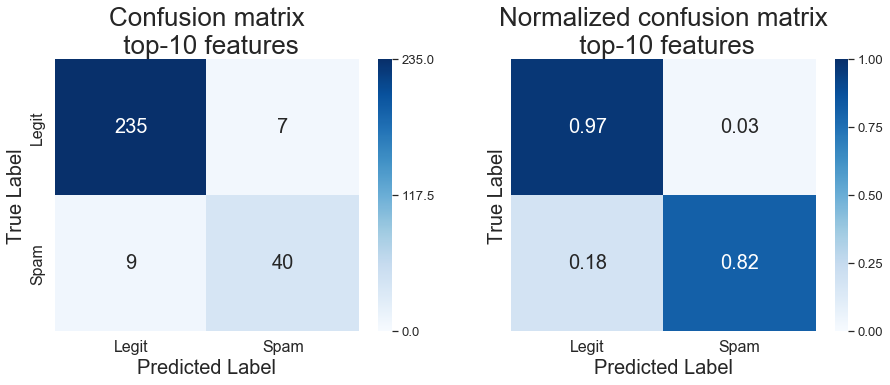

In [24]:
# create a classifier
clf = BernoulliNB()

# form a training dataset (parts 1 to 9):

totalTrainData = spam_train_binary.copy()
totalTrainData.extend(legit_train_binary)

totalTrainLabels = spam_train_labels.copy()
totalTrainLabels.extend(legit_train_labels)


# fit the classifier to the training data
clf.fit(totalTrainData, totalTrainLabels)

# then test it on part10
start = time.time()
predLabelsTest = clf.predict(totalTestData)
end = time.time()
latency_NB_Bernoulli_buildin_10 = (end-start)/len(totalTestData)

# evaluating performance:
(accuracy_NB_Bernoulli_buildin_10,## Bernoulli NB for 1000-top words
 precision_NB_Bernoulli_buildin_10, 
 recall_NB_Bernoulli_buildin_10, 
 f1_NB_Bernoulli_buildin_10) = evaluateResults(totalTestLabels,predLabelsTest,10,latency_NB_Bernoulli_buildin_10)

Moreover, we can ensure that the probabilities of being spam is also almost identical:

In [25]:
probs = clf.predict_proba(totalTestData)
i=0
print("Manually calculated probabilities for email "+str(i)+":")
print('probability of spam:  %.4f probability of legit: %.4f' % (pSpamX_all[i],pLegitX_all[i]))
print("Classifier returned probabilities for email "+str(i))
print('probability of spam:  %.4f probability of legit: %.4f\n' % (probs[i,1],probs[i,0]))

i=150
print("Manually calculated probabilities for email "+str(i)+":")
print('probability of spam:  %.4f probability of legit: %.4f' % (pSpamX_all[i],pLegitX_all[i]))
print("Classifier returned probabilities for email "+str(i))
print('probability of spam:  %.4f probability of legit: %.4f\n' % (probs[i,1],probs[i,0]))


i=len(totalTestData)-1
print("Manually calculated probabilities for email "+str(i)+":")
print('probability of spam:  %.4f probability of legit: %.4f' % (pSpamX_all[i],pLegitX_all[i]))
print("Classifier returned probabilities for email "+str(i))
print('probability of spam:  %.4f probability of legit: %.4f\n' % (probs[i,1],probs[i,0]))



Manually calculated probabilities for email 0:
probability of spam:  0.8858 probability of legit: 0.1142
Classifier returned probabilities for email 0
probability of spam:  0.8859 probability of legit: 0.1141

Manually calculated probabilities for email 150:
probability of spam:  0.0010 probability of legit: 0.9990
Classifier returned probabilities for email 150
probability of spam:  0.0010 probability of legit: 0.9990

Manually calculated probabilities for email 290:
probability of spam:  0.8630 probability of legit: 0.1370
Classifier returned probabilities for email 290
probability of spam:  0.8630 probability of legit: 0.1370



As we can notice, the manual and build-in probabilities are almost equal. Further, we will be using the probabilities returned by the built-in classifier for adversarial classification.

All procedures for Bernoulli NB classifier can be written as a function:

In [26]:
def bernoulliNB(N,selectedWords,spamWordsTrainDict,legitWordsTrainDict,spam_train,legit_train,spam_test,legit_test):
    # convert everything into binary vectors
    numSpamMailsTrain = len(spam_train)
    numSpamMailsLegit = len(legit_train)
    
    selectedWords_np = np.asarray(selectedWords)

    # create data for spam train
    spam_train_binary = []
    spam_train_labels = []
    for mail in spam_train:
        features = np.zeros(N)
        for w in selectedWords:
            if w in mail:
                index = np.where(selectedWords_np == w)[0]
                features[index[0]]=1
        spam_train_binary.append(features)
        spam_train_labels.append(1)


    # create data for legit train
    legit_train_binary = []
    legit_train_labels = []
    for mail in legit_train:
        features = np.zeros(N)
        for w in selectedWords:
            if w in mail:
                index = np.where(selectedWords_np == w)[0]
                features[index[0]]=1
        legit_train_binary.append(features)
        legit_train_labels.append(0)

    # create data for spam test
    spam_test_binary = []
    spam_test_labels = []
    for mail in spam_test:
        features = np.zeros(N)
        for w in selectedWords:
            if w in mail:
                index = np.where(selectedWords_np == w)[0]
                features[index[0]]=1
        spam_test_binary.append(features)
        spam_test_labels.append(1)

    # create data for legit test
    legit_test_binary = []
    legit_test_labels = []
    for mail in legit_test:
        features= np.zeros(N)
        for w in selectedWords:
            if w in mail:
                index = np.where(selectedWords_np == w)[0]
                features[index[0]]=1
        legit_test_binary.append(features)
        legit_test_labels.append(0)
    
    #Bernoulli NB implementation
    totalTestData = spam_test_binary.copy()
    totalTestData.extend(legit_test_binary)

    totalTestlabels = spam_test_labels.copy()
    totalTestlabels.extend(legit_test_labels)


    # for all test data:
    spamP = (numSpamMailsTrain+1)/(numSpamMailsTrain + numLegitMailsTrain+2)
    legitP = (numLegitMailsTrain+1)/(numSpamMailsTrain + numLegitMailsTrain+2)
    latency = []
    predLabels = []
    for features in totalTestData:
        start = time.time()
        spamPX = 1  # probability of X given spam
        legitPX = 1 # probability of X given legit

        totalNumberWordSpam = 0
        totalNumberWordLegit = 0
        i=0
        for word in selectedWords:
            if word in spamWordsTrainDict:
                totalNumberWordSpam = spamWordsTrainDict[word]
            else:
                totalNumberWordSpam = 1
            if word in legitWordsTrainDict:
                totalNumberWordLegit = legitWordsTrainDict[word]
            else:
                totalNumberWordLegit = 1
            pSpam = (totalNumberWordSpam+1)/(numSpamMailsTrain+2)    #p_{i,s} for spam
            pLegit = (totalNumberWordLegit+1)/(numLegitMailsTrain+2) #p_{i,s} for legit
            spamPX = spamPX * (pSpam ** features[i]) * ((1 - pSpam)**(1 - features[i]))    #p{x|spam}
            legitPX = legitPX * (pLegit ** features[i]) * ((1 - pLegit)**(1 - features[i]))#p{x|legit}
            i+=1

        pSpamX = (spamPX * spamP) / ((spamP * spamPX) + (legitP * legitPX)) # P{spam|x}
        pLegitX = (legitPX * legitP) / ((spamP * spamPX) + (legitP * legitPX))# P{legit|x}

        r = pSpamX/pLegitX
        if  r > 1:
            yhat = 1
        else:
            yhat = 0

        predLabels.append(yhat)
        end = time.time()
        latency.append(end-start)
    return(predLabels,totalTestlabels, latency)


## Bernoulli NB for 100-top words

In [27]:
# Bernoulli NB with 100 features:
(predLabels_NB_Bernoulli_100,totalTestLabels_NB_Bernoulli_100, latency_NB_Bernoulli_100) = bernoulliNB(100,selectedWords_100,spamWordsTrainDict,legitWordsTrainDict,spam_train,legit_train,spam_test,legit_test)

confusion matrix: 
[[242   0]
 [ 14  35]]

accuracy:          0.951890
spam precision:    1.000000
spam recall:       0.714286
f1:                0.833333
average latency:   0.000211 sec.


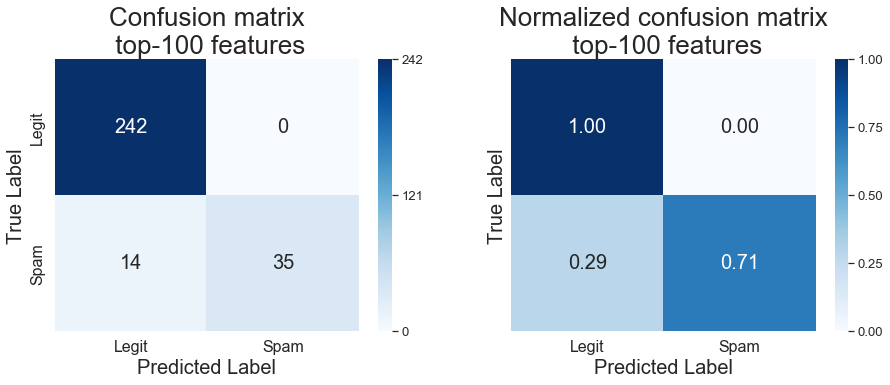

In [28]:
# evaluating performance:
(accuracy_NB_Bernoulli_100,
 precision_NB_Bernoulli_100, 
 recall_NB_Bernoulli_100, 
 f1_NB_Bernoulli_100) = evaluateResults(totalTestLabels_NB_Bernoulli_100,predLabels_NB_Bernoulli_100,100,latency_NB_Bernoulli_100)

## Bernoulli NB for 1000-top words

In [29]:
# Bernoulli NB for 1000-top words:
(predLabels_NB_Bernoulli_1000,totalTestLabels_NB_Bernoulli_1000, latency_NB_Bernoulli_1000) = bernoulliNB(1000,selectedWords_1000,spamWordsTrainDict,legitWordsTrainDict,spam_train,legit_train,spam_test,legit_test)


confusion matrix: 
[[242   0]
 [ 14  35]]

accuracy:          0.951890
spam precision:    1.000000
spam recall:       0.714286
f1:                0.833333
average latency:   0.002236 sec.


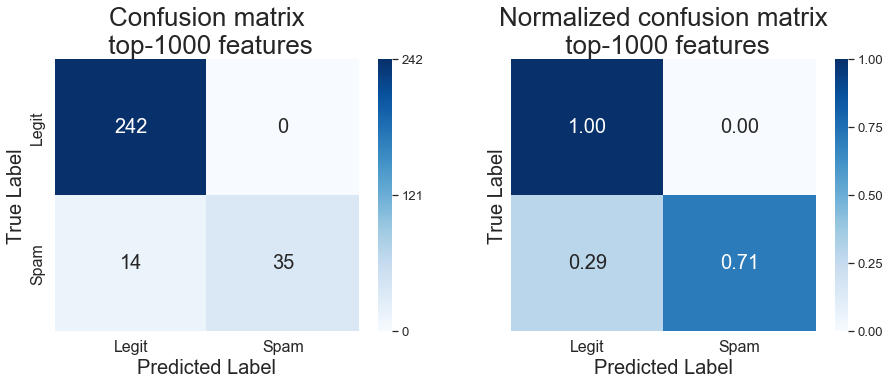

In [30]:
# evaluating performance:
(accuracy_NB_Bernoulli_1000,
 precision_NB_Bernoulli_1000, 
 recall_NB_Bernoulli_1000, 
 f1_NB_Bernoulli_1000) = evaluateResults(totalTestLabels_NB_Bernoulli_1000,predLabels_NB_Bernoulli_1000,1000,latency_NB_Bernoulli_1000)

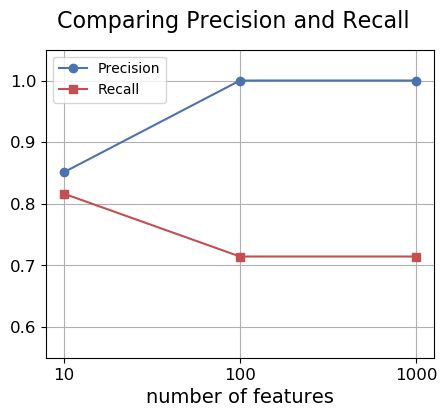

In [31]:
matplotlib.rc_file_defaults()
fig, ax = plt.subplots(figsize=(5,4))
fig.suptitle("Comparing Precision and Recall",fontsize="16")
ax.set_xticks([0,1,2])
ax.set_xticklabels(['10','100','1000'],fontsize="12")
ax.tick_params(axis="y", labelsize=12)
ax.set_ylim([0.55,1.05])
ax.set_xlabel('number of features', fontsize="14")
ax.plot([precision_NB_Bernoulli_10,precision_NB_Bernoulli_100,precision_NB_Bernoulli_1000], 'bo-',label = 'Precision')
ax.plot([recall_NB_Bernoulli_10,recall_NB_Bernoulli_100,recall_NB_Bernoulli_1000], 'rs-',label = 'Recall');
plt.legend()
ax.grid()


We can notice that with the increase of the number of features the value of precision increases and recall drops. In other words, the classifier increases performance in predicting legit mails and increasingly misclassifies spam mails as legitimate. It could be attributed to overfitting.

# Multinomial NB with Term Frequency features 

We want to estimate the probability $P\{x_i=t|spam\}$ that every keyword $x_i$ appears $t$ times, $t = 1,2,...$ in spam email, i.e. how frequently this keyword appears in the spam email. It relies on the assumption that emails are generated using the bag-of-word model.

Given the lenght of the email $D$ we want to estimate the probability:

$P\{x|spam,D\} = D!\frac{\prod_{i=1}^M\left(p_{i,s}\right)^{x_i}}{x_i!}$,

where $M$ is the number of terms in the bag-of-words.

We also assume that the email length is independent of whether email is spam or legit.

Thus, 

$P\{spam|x\} = P\{x|spam,D\}P\{spam\}$

The probability that a randomly selected word in spam mail is term $i$ is (with Laplacian smoothing):

$p_{i,s} = \frac{1+\text{termFrequencySpam[i]}}{\text{totalNumberWordSpam}+M}$

where $\text{termFrequencySpam[i]}$ -- number of occurences of term $i$ in spam,

$\text{totalNumberWordSpam} = \sum_{i=1}^M \text{termFrequencySpam[i]}$ -- total number of occurences of terms in the bag-of-words in spam.

In [32]:
# first we will initialize the dictionaries for spam and legit where we will be stroing term frequencies as values
# for every word in training dataset 
# https://www.geeksforgeeks.org/python-initialize-a-dictionary-with-only-keys-from-a-list/
termFrequencySpam = {}
termFrequencyLegit = {}
for word in allUniqueTrainingWords:
    termFrequencySpam[word] = 1
    termFrequencyLegit[word] = 1 

for mail in spam_train:
    for word in mail:
        termFrequencySpam[word]+=1   
    
for mail in legit_train:
    for word in mail:
        termFrequencyLegit[word]+=1      
        
# for each document we need to create a term frequency dictionary
# assume we are interested in N features

# create data for spam train
spam_train_tf = []
spam_train_labels = []
selectedWords_10 = np.asarray(selectedWords_10)

for mail in spam_train:
    tmpTermFrequencyDict = {}# temporary term frequency dictioanry for current mail
    #we need to initalize it:
    for word in mail:
        tmpTermFrequencyDict[word] = 1
    #fill it for current mail:
    for word in mail:
        tmpTermFrequencyDict[word]+= 1
    features = np.zeros(10)
    for w in selectedWords_10:
        if w in tmpTermFrequencyDict:
            index = np.where(selectedWords_10 == w)[0]
            features[index[0]]=tmpTermFrequencyDict[w]
    spam_train_tf.append(features)
    spam_train_labels.append(1)
        
        
# create data for legit train
legit_train_tf = []
legit_train_labels = []

for mail in legit_train:
    tmpTermFrequencyDict = {}# temporary term frequency dictioanry for current mail
    #we need to initalize it:
    for word in mail:
        tmpTermFrequencyDict[word] = 1
    #fill it for current mail:
    for word in mail:
        tmpTermFrequencyDict[word]+= 1
    features = np.zeros(10)
    for w in selectedWords_10:
        if w in tmpTermFrequencyDict:
            index = np.where(selectedWords_10 == w)[0]
            features[index[0]]=tmpTermFrequencyDict[w]
    legit_train_tf.append(features)
    legit_train_labels.append(0)

# create data for spam test
spam_test_tf = []
spam_test_labels = []

for mail in spam_test:
    tmpTermFrequencyDict = {}# temporary term frequency dictioanry for current mail
    #we need to initalize it:
    for word in mail:
        tmpTermFrequencyDict[word] = 1
    #fill it for current mail:
    for word in mail:
        tmpTermFrequencyDict[word]+= 1
    features = np.zeros(10)
    for w in selectedWords_10:
        if w in tmpTermFrequencyDict:
            index = np.where(selectedWords_10 == w)[0]
            features[index[0]]=tmpTermFrequencyDict[w]
    spam_test_tf.append(features)
    spam_test_labels.append(1)

# create data for legit test
legit_test_tf = []
legit_test_labels = []

for mail in legit_test:
    tmpTermFrequencyDict = {}# temporary term frequency dictioanry for current mail
    #we need to initalize it:
    for word in mail:
        tmpTermFrequencyDict[word] = 1
    #fill it for current mail:
    for word in mail:
        tmpTermFrequencyDict[word]+= 1
    features = np.zeros(10)
    for w in selectedWords_10:
        if w in tmpTermFrequencyDict:
            index = np.where(selectedWords_10 == w)[0]
            features[index[0]]=tmpTermFrequencyDict[w]
    legit_test_tf.append(features)
    legit_test_labels.append(0)
    
# check the output if everything looks allright:
#print(spam_test_tf)

## Multinomial NB with Term Frequency features for 10-top words

In [33]:
totalTestData = spam_test_tf.copy()
totalTestData.extend(legit_test_tf)

totalTestlabels = spam_test_labels.copy()
totalTestlabels.extend(legit_test_labels)


# for all test data:
spamP = (numSpamMailsTrain+1)/(numSpamMailsTrain + numLegitMailsTrain +2)
legitP = (numLegitMailsTrain+1)/(numSpamMailsTrain + numLegitMailsTrain +2)
latency =[]
predLabels = []

for features in totalTestData:
    start= time.time()
    spamPX = 1  # probability of X given spam
    legitPX = 1 # probability of X given legit

    totalNumberWordSpam = 0
    totalNumberWordLegit = 0
    
    for word in selectedWords_10:
        totalNumberWordSpam+=termFrequencySpam[word]
        totalNumberWordLegit+=termFrequencyLegit[word]
    i=0
    for word in selectedWords_10:   
        pSpam = (1+termFrequencySpam[word])/(totalNumberWordSpam+10)#p_{i,s} for spam
        pLegit = (1+termFrequencyLegit[word])/(totalNumberWordLegit+10)#p_{i,s} for legit
        spamPX = spamPX * (pSpam ** features[i])
        legitPX = legitPX * (pLegit ** features[i])
        i+=1

    pSpamX = (spamPX * spamP) # P{spam|x}
    pLegitX = (legitPX * legitP)# P{legit|x}
    
    r = pSpamX/pLegitX
    if  r > 1:
        yhat = 1
    else:
        yhat = 0
  
    predLabels.append(yhat)
    end = time.time()
    latency.append(end-start)
latency_NB_Multinomial_TF_10=latency

## Evaluate Multinomial NB with Term Frequency features for 10-top words

confusion matrix: 
[[236   6]
 [  9  40]]

accuracy:          0.948454
spam precision:    0.869565
spam recall:       0.816327
f1:                0.842105
average latency:   0.000025 sec.


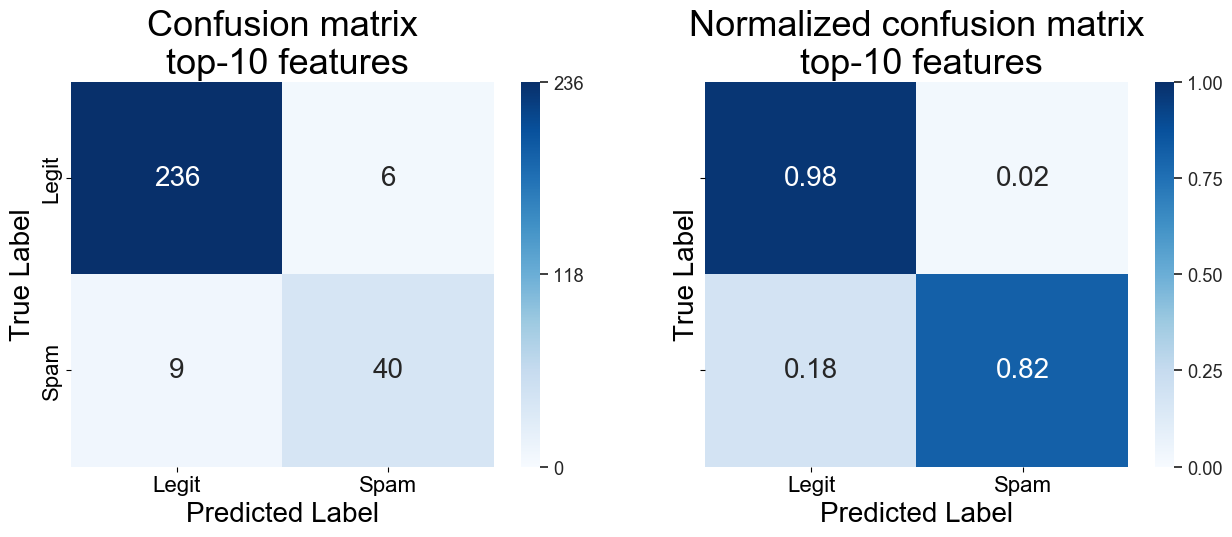

In [34]:
# evaluating performance:
(accuracy_NB_Multinomial_TF_10,
 precision_NB_Multinomial_TF_10, 
 recall_NB_Multinomial_TF_10, 
 f1_NB_Multinomial_TF_10) = evaluateResults(totalTestLabels,predLabels,10,latency_NB_Multinomial_TF_10)

In [35]:
def multinomialTF(N,selectedWords,allUniqueTrainingWords,spam_train,legit_train,spam_test,legit_test):
    termFrequencySpam = {}
    termFrequencyLegit = {}
    for word in allUniqueTrainingWords:
        termFrequencySpam[word] = 1
        termFrequencyLegit[word] = 1 

    for mail in spam_train:
        for word in mail:
            termFrequencySpam[word]+=1   

    for mail in legit_train:
        for word in mail:
            termFrequencyLegit[word]+=1      

    # for each document we need to create a term frequency dictionary
    # assume we are interested in N features

    # create data for spam train
    spam_train_tf = []
    spam_train_labels = []
    selectedWords = np.asarray(selectedWords)

    for mail in spam_train:
        tmpTermFrequencyDict = {}# temporary term frequency dictioanry for current mail
        #we need to initalize it:
        for word in mail:
            tmpTermFrequencyDict[word] = 1
        #fill it for current mail:
        for word in mail:
            tmpTermFrequencyDict[word]+= 1
        features = np.zeros(N)
        for w in selectedWords:
            if w in tmpTermFrequencyDict:
                index = np.where(selectedWords == w)[0]
                features[index[0]]=tmpTermFrequencyDict[w]
        spam_train_tf.append(features)
        spam_train_labels.append(1)


    # create data for legit train
    legit_train_tf = []
    legit_train_labels = []

    for mail in legit_train:
        tmpTermFrequencyDict = {}# temporary term frequency dictioanry for current mail
        #we need to initalize it:
        for word in mail:
            tmpTermFrequencyDict[word] = 1
        #fill it for current mail:
        for word in mail:
            tmpTermFrequencyDict[word]+= 1
        features = np.zeros(N)
        for w in selectedWords:
            if w in tmpTermFrequencyDict:
                index = np.where(selectedWords == w)[0]
                features[index[0]]=tmpTermFrequencyDict[w]
        legit_train_tf.append(features)
        legit_train_labels.append(0)

    # create data for spam test
    spam_test_tf = []
    spam_test_labels = []

    for mail in spam_test:
        tmpTermFrequencyDict = {}# temporary term frequency dictioanry for current mail
        #we need to initalize it:
        for word in mail:
            tmpTermFrequencyDict[word] = 1
        #fill it for current mail:
        for word in mail:
            tmpTermFrequencyDict[word]+= 1
        features = np.zeros(N)
        for w in selectedWords:
            if w in tmpTermFrequencyDict:
                index = np.where(selectedWords == w)[0]
                features[index[0]]=tmpTermFrequencyDict[w]
        spam_test_tf.append(features)
        spam_test_labels.append(1)

    # create data for legit test
    legit_test_tf = []
    legit_test_labels = []

    for mail in legit_test:
        tmpTermFrequencyDict = {}# temporary term frequency dictioanry for current mail
        #we need to initalize it:
        for word in mail:
            tmpTermFrequencyDict[word] = 1
        #fill it for current mail:
        for word in mail:
            tmpTermFrequencyDict[word]+= 1
        features = np.zeros(N)
        for w in selectedWords:
            if w in tmpTermFrequencyDict:
                index = np.where(selectedWords == w)[0]
                features[index[0]]=tmpTermFrequencyDict[w]
        legit_test_tf.append(features)
        legit_test_labels.append(0)

    #Multinomial Bernoulli NB TF
    totalTestData = spam_test_tf.copy()
    totalTestData.extend(legit_test_tf)

    totalTestlabels = spam_test_labels.copy()
    totalTestlabels.extend(legit_test_labels)


    # for all test data:
    spamP = (numSpamMailsTrain+1)/(numSpamMailsTrain + numLegitMailsTrain +2)
    legitP = (numLegitMailsTrain+1)/(numSpamMailsTrain + numLegitMailsTrain +2)

    predLabels = []
    latency=[]
    for features in totalTestData:
        start=time.time()
        spamPX = 1  # probability of X given spam
        legitPX = 1 # probability of X given legit

        totalNumberWordSpam = 0
        totalNumberWordLegit = 0

        for word in selectedWords:
            totalNumberWordSpam+=termFrequencySpam[word]
            totalNumberWordLegit+=termFrequencyLegit[word]
        i=0
        for word in selectedWords:   
            pSpam = (1+termFrequencySpam[word])/(totalNumberWordSpam+N)#p_{i,s} for spam
            pLegit = (1+termFrequencyLegit[word])/(totalNumberWordLegit+N)#p_{i,s} for legit
            spamPX = spamPX * (pSpam ** features[i])
            legitPX = legitPX * (pLegit ** features[i])
            i+=1

        pSpamX = (spamPX * spamP) # P{spam|x}
        pLegitX = (legitPX * legitP)# P{legit|x}

        r = pSpamX/pLegitX
        if  r > 1:
            yhat = 1
        else:
            yhat = 0

        predLabels.append(yhat)
        end=time.time()
        latency.append(end-start)
    return(predLabels,totalTestlabels,latency)


## Multinomial NB with Term Frequency features for 100-top words

In [36]:
## Multinomial NB with Term Frequency features for 100-top words
(predLabels_NB_Multinomial_TF_100,totalTestlabels_NB_Multinomial_TF_100,latency_NB_Multinomial_TF_100) = multinomialTF(100,selectedWords_100,allUniqueTrainingWords,spam_train,legit_train,spam_test,legit_test)


confusion matrix: 
[[239   3]
 [  2  47]]

accuracy:          0.982818
spam precision:    0.940000
spam recall:       0.959184
f1:                0.949495
average latency:   0.000178 sec.


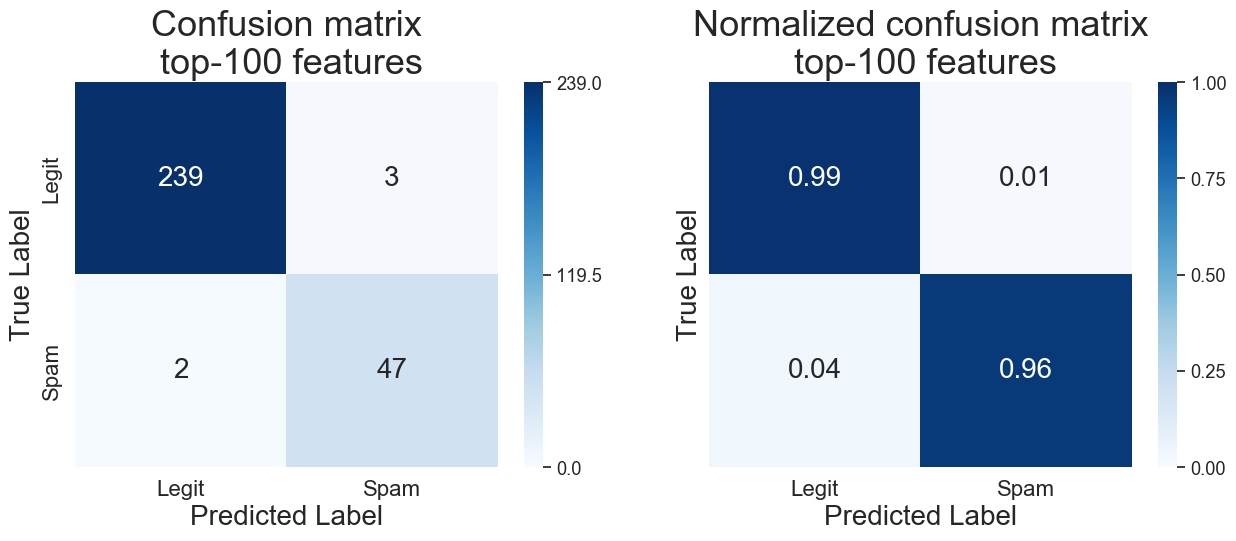

In [37]:
#evaluating performance
(accuracy_NB_Multinomial_TF_100,
 precision_NB_Multinomial_TF_100, 
 recall_NB_Multinomial_TF_100, 
 f1_NB_Multinomial_TF_100) = evaluateResults(totalTestlabels_NB_Multinomial_TF_100,predLabels_NB_Multinomial_TF_100,100,latency_NB_Multinomial_TF_100)

## Multinomial NB with Term Frequency features for 1000-top words

In [38]:
#  Multinomial NB with Term Frequency features for 1000-top words:
(predLabels_NB_Multinomial_TF_1000,totalTestlabels_NB_Multinomial_TF_1000,latency_NB_Multinomial_TF_1000) = multinomialTF(1000,selectedWords_1000,allUniqueTrainingWords,spam_train,legit_train,spam_test,legit_test)

confusion matrix: 
[[242   0]
 [ 16  33]]

accuracy:          0.945017
spam precision:    1.000000
spam recall:       0.673469
f1:                0.804878
average latency:   0.001714 sec.


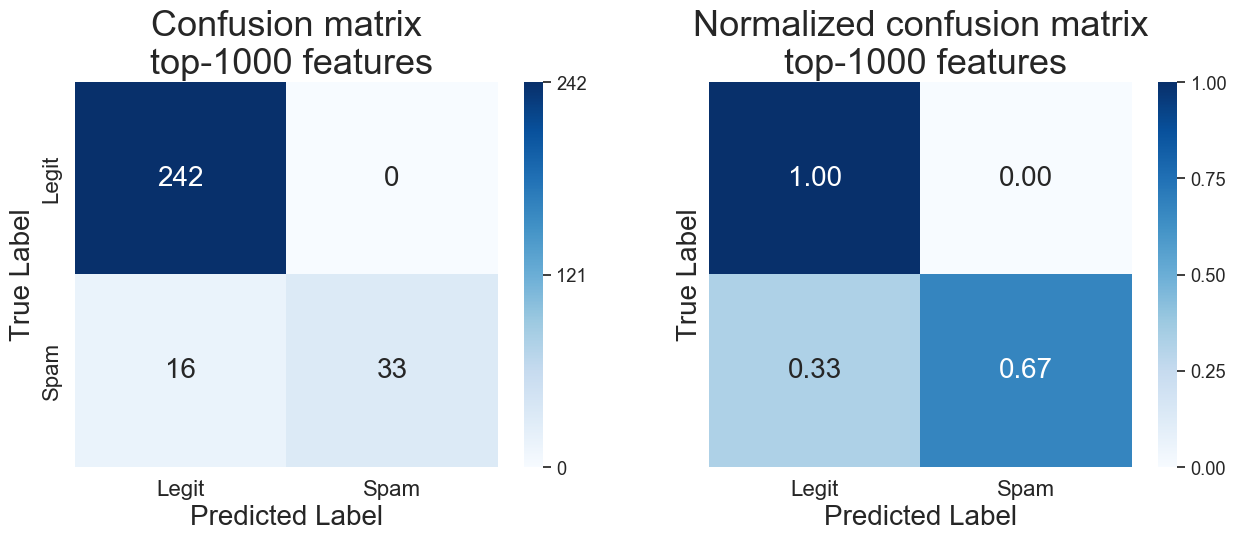

In [39]:
#evaluating performance
(accuracy_NB_Multinomial_TF_1000,
 precision_NB_Multinomial_TF_1000, 
 recall_NB_Multinomial_TF_1000, 
 f1_NB_Multinomial_TF_1000) = evaluateResults(totalTestlabels_NB_Multinomial_TF_1000,predLabels_NB_Multinomial_TF_1000,1000,latency_NB_Multinomial_TF_1000)

## Compare precision/recall for Multinomial NB with Term Frequency features 

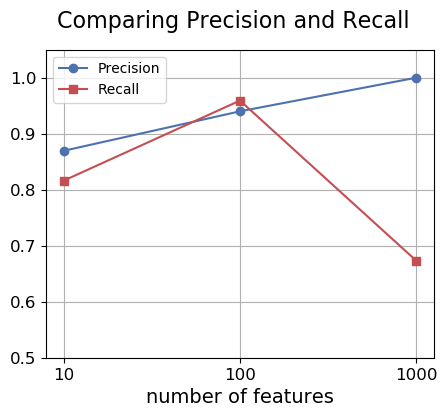

In [40]:
matplotlib.rc_file_defaults()
fig, ax = plt.subplots(figsize=(5,4))
fig.suptitle("Comparing Precision and Recall",fontsize="16")
ax.set_xticks([0,1,2])
ax.set_xticklabels(['10','100','1000'],fontsize="12")
ax.tick_params(axis="y", labelsize=12)
ax.set_ylim([0.5,1.05])
ax.set_xlabel('number of features', fontsize="14")
ax.plot([precision_NB_Multinomial_TF_10,precision_NB_Multinomial_TF_100,precision_NB_Multinomial_TF_1000], 'bo-',label = 'Precision')
ax.plot([recall_NB_Multinomial_TF_10,recall_NB_Multinomial_TF_100,recall_NB_Multinomial_TF_1000], 'rs-',label = 'Recall');
plt.legend()
ax.grid()


# Multinomial NB with Binary Features

For Multinomial NB with Binary Features we just plug-in 0 if the term frequency is 0 and 1 if the term frequency is greater than 0. In other words, if $x = \left(x_1,x_2,...,x_M\right)$ are TF features, the binary features are derived as follows:

$\bar{x} = \left(\bar{x}_1 = \min(1,x_1),\bar{x}_2= \min(1,x_2),...,\bar{x}_M= \min(1,x_M)\right)$

In general we calculate the probability:

$P\{spam|x\} = P\{x|spam,D\}P\{spam\}$,

where

$P\{x|spam,D\} = D!\frac{\prod_{i=1}^M\left(p_{i,s}\right)^{x_i}}{x_i!}= D!\prod_{i=1}^M\left(p_{i,s}\right)^{x_i}$,

since $\frac{\left(p_{i,s}\right)^{x_i}}{x_i!}=\begin{cases}
p_{i,s},\, x_i=1\\
1,\,\,\,\,\, x_i=0
\end{cases}$


The probability that a randomly selected word in spam mail is term $i$ is (with Laplacian smoothing):

$p_{i,s} = \frac{1+\text{termFrequencySpam[i]}}{\text{totalNumberWordSpam}+M}$

where $\text{termFrequencySpam[i]}$ -- number of occurences of term $i$ in spam,

$\text{totalNumberWordSpam} = \sum_{i=1}^M \text{termFrequencySpam[i]}$ -- total number of occurences of terms in the bag-of-words in spam.

In [41]:
def multinomialBF(N,selectedWords,allUniqueTrainingWords,spam_train,legit_train,spam_test,legit_test):
    termFrequencySpam = {}
    termFrequencyLegit = {}
    for word in allUniqueTrainingWords:
        termFrequencySpam[word] = 1
        termFrequencyLegit[word] = 1 

    for mail in spam_train:
        for word in mail:
            termFrequencySpam[word]+=1   

    for mail in legit_train:
        for word in mail:
            termFrequencyLegit[word]+=1      

    # for each document we need to create a term frequency dictionary
    # assume we are interested in 10 features

    # create data for spam train
    spam_train_bf = []
    spam_train_labels = []
    selectedWords = np.asarray(selectedWords)

    for mail in spam_train:
        tmpTermFrequencyDict = {}# temporary term frequency dictioanry for current mail
        #we need to initalize it:
        for word in mail:
            tmpTermFrequencyDict[word] = 1
        #fill it for current mail:
        for word in mail:
            tmpTermFrequencyDict[word]+= 1
        features = np.zeros(N)
        for w in selectedWords:
            if w in tmpTermFrequencyDict:
                index = np.where(selectedWords == w)[0]
                if tmpTermFrequencyDict[w] >0:
                    features[index[0]]=1
                else:
                    features[index[0]]=0 
        spam_train_bf.append(features)
        spam_train_labels.append(1)


    # create data for legit train
    legit_train_bf = []
    legit_train_labels = []

    for mail in legit_train:
        tmpTermFrequencyDict = {}# temporary term frequency dictioanry for current mail
        #we need to initalize it:
        for word in mail:
            tmpTermFrequencyDict[word] = 1
        #fill it for current mail:
        for word in mail:
            tmpTermFrequencyDict[word]+= 1
        features = np.zeros(N)
        for w in selectedWords:
            if w in tmpTermFrequencyDict:
                index = np.where(selectedWords == w)[0]
                if tmpTermFrequencyDict[w] >0:
                    features[index[0]]=1
                else:
                    features[index[0]]=0    
        legit_train_bf.append(features)
        legit_train_labels.append(0)

    # create data for spam test
    spam_test_bf = []
    spam_test_labels = []

    for mail in spam_test:
        tmpTermFrequencyDict = {}# temporary term frequency dictioanry for current mail
        #we need to initalize it:
        for word in mail:
            tmpTermFrequencyDict[word] = 1
        #fill it for current mail:
        for word in mail:
            tmpTermFrequencyDict[word]+= 1
        features = np.zeros(N)
        for w in selectedWords:
            if w in tmpTermFrequencyDict:
                index = np.where(selectedWords == w)[0]
                if tmpTermFrequencyDict[w] >0:
                    features[index[0]]=1
                else:
                    features[index[0]]=0 
        spam_test_bf.append(features)
        spam_test_labels.append(1)

    # create data for legit test
    legit_test_bf = []
    legit_test_labels = []

    for mail in legit_test:
        tmpTermFrequencyDict = {}# temporary term frequency dictioanry for current mail
        #we need to initalize it:
        for word in mail:
            tmpTermFrequencyDict[word] = 1
        #fill it for current mail:
        for word in mail:
            tmpTermFrequencyDict[word]+= 1
        features = np.zeros(N)
        for w in selectedWords:
            if w in tmpTermFrequencyDict:
                index = np.where(selectedWords == w)[0]
                if tmpTermFrequencyDict[w] >0:
                    features[index[0]]=1
                else:
                    features[index[0]]=0 
        legit_test_bf.append(features)
        legit_test_labels.append(0)

    #Multinomial NB BF
    totalTestData = spam_test_bf.copy()
    totalTestData.extend(legit_test_bf)

    totalTestlabels = spam_test_labels.copy()
    totalTestlabels.extend(legit_test_labels)


    # for all test data:
    spamP = (numSpamMailsTrain+1)/(numSpamMailsTrain + numLegitMailsTrain +2)
    legitP = (numLegitMailsTrain+1)/(numSpamMailsTrain + numLegitMailsTrain +2)

    predLabels = []
    latency=[]
    for features in totalTestData:
        start = time.time()
        spamPX = 1  # probability of X given spam
        legitPX = 1 # probability of X given legit

        totalNumberWordSpam = 0
        totalNumberWordLegit = 0

        for word in selectedWords:
            totalNumberWordSpam+=termFrequencySpam[word]
            totalNumberWordLegit+=termFrequencyLegit[word]
        i=0
        for word in selectedWords:   
            pSpam = (1+termFrequencySpam[word])/(totalNumberWordSpam+N)#p_{i,s} for spam
            pLegit = (1+termFrequencyLegit[word])/(totalNumberWordLegit+N)#p_{i,s} for legit
            spamPX = spamPX * (pSpam ** features[i])
            legitPX = legitPX * (pLegit ** features[i])
            i+=1

        pSpamX = (spamPX * spamP) # P{spam|x}
        pLegitX = (legitPX * legitP)# P{legit|x}

        r = pSpamX/pLegitX
        if  r > 1:
            yhat = 1
        else:
            yhat = 0

        predLabels.append(yhat)
        end =  time.time()
        latency.append(end-start)
    return(predLabels,totalTestlabels,latency)


## Multinomial NB with Binary features for  10-top words

In [42]:
# Multinomial NB with Binary features for 10-top words
(predLabels_NB_Multinomial_BF_10,totalTestlabels_NB_Multinomial_BF_10, latency_NB_Multinomial_BF_10) = multinomialBF(10,selectedWords_10,allUniqueTrainingWords,spam_train,legit_train,spam_test,legit_test)


confusion matrix: 
[[235   7]
 [  9  40]]

accuracy:          0.945017
spam precision:    0.851064
spam recall:       0.816327
f1:                0.833333
average latency:   0.000018 sec.


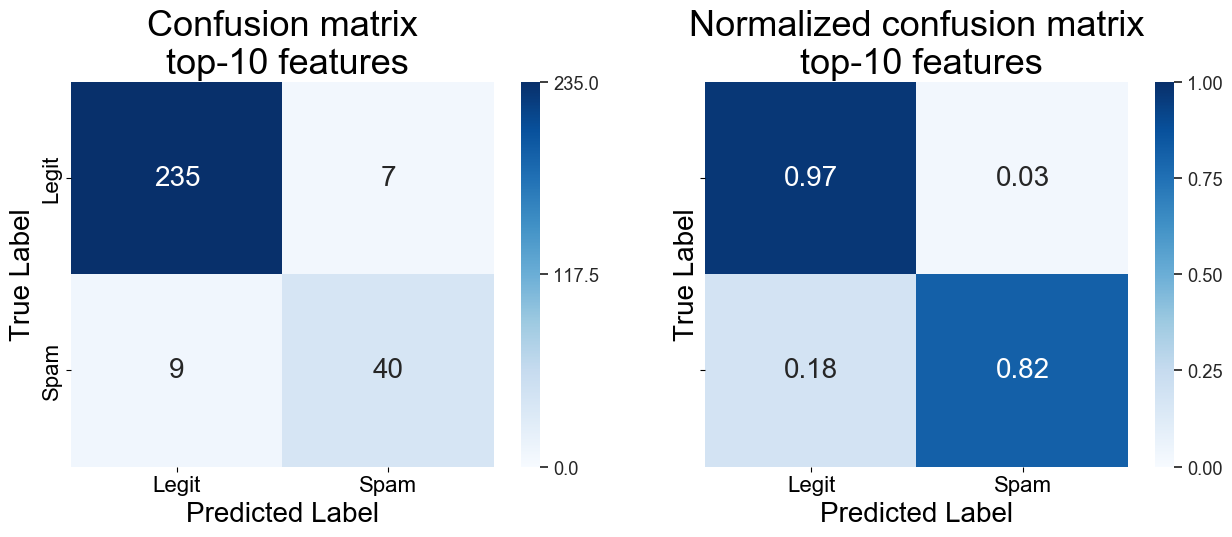

In [43]:
#evaluating performance
(accuracy_NB_Multinomial_BF_10,
 precision_NB_Multinomial_BF_10, 
 recall_NB_Multinomial_BF_10, 
 f1_NB_Multinomial_BF_10) = evaluateResults(totalTestlabels_NB_Multinomial_BF_10,predLabels_NB_Multinomial_BF_10,10,latency_NB_Multinomial_BF_10)

## Multinomial NB with Binary features for  100-top words

In [44]:
# Multinomial NB with Binary features for 100-top words
(predLabels_NB_Multinomial_BF_100,totalTestlabels_NB_Multinomial_BF_100, latency_NB_Multinomial_BF_100) = multinomialBF(100,selectedWords_100,allUniqueTrainingWords,spam_train,legit_train,spam_test,legit_test)


confusion matrix: 
[[239   3]
 [  2  47]]

accuracy:          0.982818
spam precision:    0.940000
spam recall:       0.959184
f1:                0.949495
average latency:   0.000159 sec.


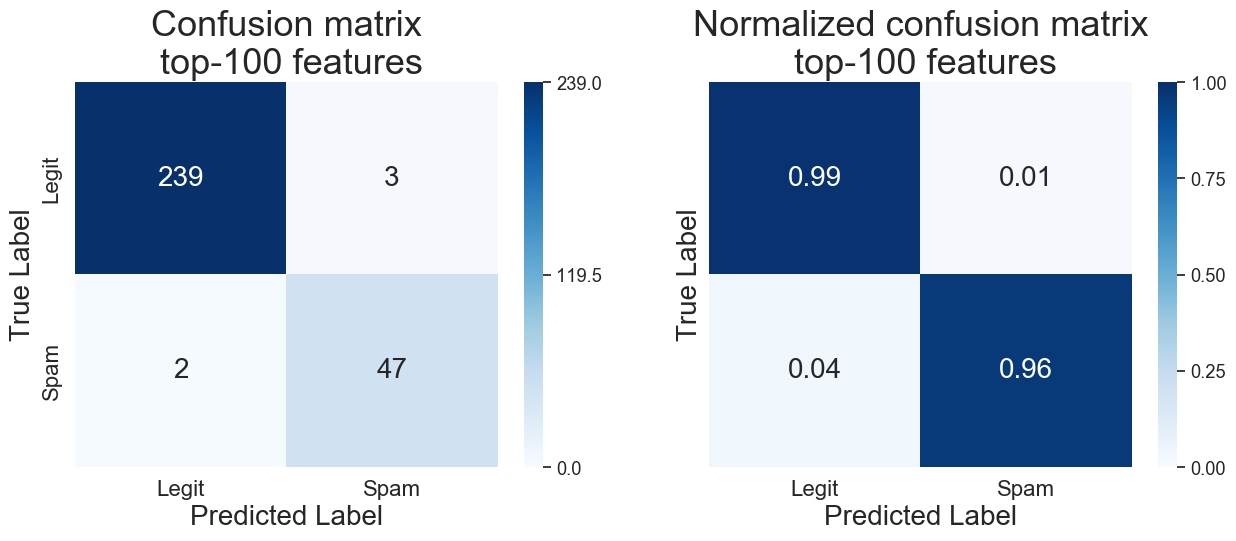

In [45]:
#evaluating performance
(accuracy_NB_Multinomial_BF_100,
 precision_NB_Multinomial_BF_100, 
 recall_NB_Multinomial_BF_100, 
 f1_NB_Multinomial_BF_100) = evaluateResults(totalTestlabels_NB_Multinomial_BF_100,predLabels_NB_Multinomial_BF_100,100,latency_NB_Multinomial_BF_100)

## Multinomial NB with Binary features for 1000-top words

In [46]:
# Multinomial NB with Binary features for 1000-top words
(predLabels_NB_Multinomial_BF_1000,totalTestlabels_NB_Multinomial_BF_1000, latency_NB_Multinomial_BF_1000) = multinomialBF(1000,selectedWords_1000,allUniqueTrainingWords,spam_train,legit_train,spam_test,legit_test)


confusion matrix: 
[[242   0]
 [  5  44]]

accuracy:          0.982818
spam precision:    1.000000
spam recall:       0.897959
f1:                0.946237
average latency:   0.001759 sec.


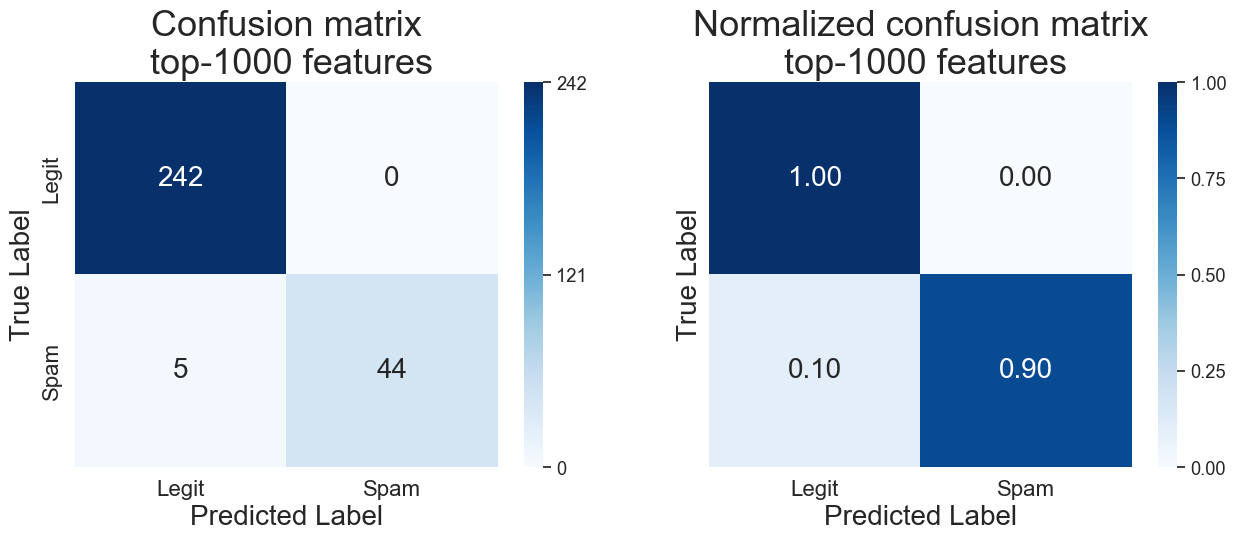

In [47]:
#evaluating performance
(accuracy_NB_Multinomial_BF_1000,
 precision_NB_Multinomial_BF_1000, 
 recall_NB_Multinomial_BF_1000, 
 f1_NB_Multinomial_BF_1000) = evaluateResults(totalTestlabels_NB_Multinomial_BF_1000,predLabels_NB_Multinomial_BF_1000,1000,latency_NB_Multinomial_BF_1000)

## Plotting the performance of Multinomial NB Classifier with Binary Features 

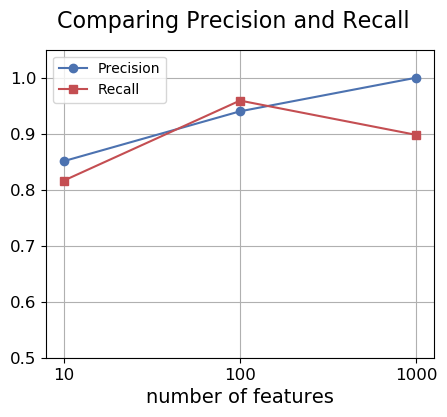

In [48]:
matplotlib.rc_file_defaults()
fig, ax = plt.subplots(figsize=(5,4))
fig.suptitle("Comparing Precision and Recall",fontsize="16")
ax.set_xticks([0,1,2])
ax.set_xticklabels(['10','100','1000'],fontsize="12")
ax.tick_params(axis="y", labelsize=12)
ax.set_ylim([0.5,1.05])
ax.set_xlabel('number of features', fontsize="14")
ax.plot([precision_NB_Multinomial_BF_10,precision_NB_Multinomial_BF_100,precision_NB_Multinomial_BF_1000], 'bo-',label = 'Precision')
ax.plot([recall_NB_Multinomial_BF_10,recall_NB_Multinomial_BF_100,recall_NB_Multinomial_BF_1000], 'rs-',label = 'Recall');
plt.legend()
ax.grid()

# Comparing three classifiers

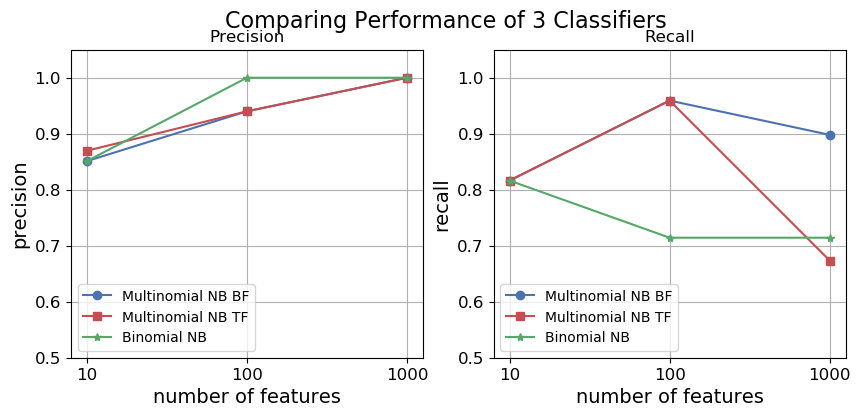

In [49]:
matplotlib.rc_file_defaults()
fig, ax = plt.subplots(1,2,figsize=(10,4))
fig.suptitle("Comparing Performance of 3 Classifiers",fontsize="16")
ax[0].set_xticks([0,1,2])
ax[0].set_xticklabels(['10','100','1000'],fontsize="12")
ax[0].tick_params(axis="y", labelsize=12)
ax[0].set_ylim([0.5,1.05])
ax[0].set_xlabel('number of features', fontsize="14")
ax[0].set_ylabel("precision", fontsize="14")
ax[0].plot([precision_NB_Multinomial_BF_10,precision_NB_Multinomial_BF_100,precision_NB_Multinomial_BF_1000], 'bo-',label = 'Multinomial NB BF')
ax[0].plot([precision_NB_Multinomial_TF_10,precision_NB_Multinomial_TF_100,precision_NB_Multinomial_TF_1000], 'rs-',label = 'Multinomial NB TF')
ax[0].plot([precision_NB_Bernoulli_10,precision_NB_Bernoulli_100,precision_NB_Bernoulli_1000], 'g*-',label = 'Binomial NB')
ax[0].set_title("Precision")
ax[0].grid()
ax[0].legend()

ax[1].set_xticks([0,1,2])
ax[1].set_xticklabels(['10','100','1000'],fontsize="12")
ax[1].tick_params(axis="y", labelsize=12)
ax[1].set_ylim([0.5,1.05])
ax[1].set_xlabel('number of features', fontsize="14")
ax[1].set_ylabel("recall", fontsize="14")
ax[1].plot([recall_NB_Multinomial_BF_10,recall_NB_Multinomial_BF_100,recall_NB_Multinomial_BF_1000], 'bo-',label = 'Multinomial NB BF')
ax[1].plot([recall_NB_Multinomial_TF_10,recall_NB_Multinomial_TF_100,recall_NB_Multinomial_TF_1000], 'rs-',label = 'Multinomial NB TF')
ax[1].plot([recall_NB_Bernoulli_10,recall_NB_Bernoulli_100,recall_NB_Bernoulli_1000], 'g*-',label = 'Binomial NB')
ax[1].set_title("Recall")
ax[1].grid()
ax[1].legend();

## Summary table of NB classifiers

In [50]:
cols= ['classifier', 'N-top words','spam recall', 'spam precision', 'avg. latency, sec']
data = [['Bernoulli NB',10,recall_NB_Bernoulli_10, precision_NB_Bernoulli_10, np.mean(latency_NB_Bernoulli_10)],
        ['Bernoulli NB',100,recall_NB_Bernoulli_100, precision_NB_Bernoulli_100,np.mean(latency_NB_Bernoulli_100)],
        ['Bernoulli NB',1000,recall_NB_Bernoulli_1000, precision_NB_Bernoulli_1000,np.mean(latency_NB_Bernoulli_1000)],
        ['Multinomial NB with TF',10,recall_NB_Multinomial_TF_10, precision_NB_Multinomial_TF_10,np.mean(latency_NB_Multinomial_TF_10)],
        ['Multinomial NB with TF',100,recall_NB_Multinomial_TF_100, precision_NB_Multinomial_TF_100,np.mean(latency_NB_Multinomial_TF_100)],
        ['Multinomial NB with TF',1000,recall_NB_Multinomial_TF_1000, precision_NB_Multinomial_TF_1000,np.mean(latency_NB_Multinomial_TF_1000)],
        ['Multinomial NB with BF',10,recall_NB_Multinomial_BF_10, precision_NB_Multinomial_BF_10,np.mean(latency_NB_Multinomial_BF_10)],
        ['Multinomial NB with BF',100,recall_NB_Multinomial_BF_100, precision_NB_Multinomial_BF_100,np.mean(latency_NB_Multinomial_BF_100)],
        ['Multinomial NB with BF',1000,recall_NB_Multinomial_BF_1000, precision_NB_Multinomial_BF_1000,np.mean(latency_NB_Multinomial_BF_1000)]
       ]
df_allClassifiersInfo= pd.DataFrame(data = data,columns=cols)
df_allClassifiersInfo

,classifier,N-top words,spam recall,spam precision,"avg. latency, sec"
0,Bernoulli NB,10,0.816327,0.851064,0.000030
1,Bernoulli NB,100,0.714286,1.000000,0.000211
2,Bernoulli NB,1000,0.714286,1.000000,0.002236
3,Multinomial NB with TF,10,0.816327,0.869565,0.000025
4,Multinomial NB with TF,100,0.959184,0.940000,0.000178
5,Multinomial NB with TF,1000,0.673469,1.000000,0.001714
6,Multinomial NB with BF,10,0.816327,0.851064,0.000018
7,Multinomial NB with BF,100,0.959184,0.940000,0.000159
8,Multinomial NB with BF,1000,0.897959,1.000000,0.001759


As we can notice the Multinomial Naive Bayes Classifier with Binary Features performs best in terms of spam recall when the number of features is 100. Furthere increasing the number of features leads to the overfitting and drop in recall for spam prediction.  

The better performance of Multinomial Naive Bayes Classifier with Binary Features over the Binomial NB might be attributed to the fact that the emails contain a small fraction of words from the vocabulary. Because of it the probability of a document being spam or legit is determined by the probabilities of the word missing in the documents. It also explains the proximity of precision of Binomial NB to 1, i.e. its ability to better predict the legitimate mails. In comparison to the Binomial NB Classifier the Multinomial classifiers take into account the positive evidence, i.e. the probabilites are that the word is in spam document. The Multinomial NB  with Binary features performs better that Multinomial NB with Term Frequencies, because the bag-of-word model assumes independence of the same word occurrences in the document, while in the real life if the word accurs in the mail several times these occurences are interrelated.

# SVM based spam filter


We will start with creating the testing and training datasets containing binary feature vectors for 10,100 and 1000 top selected features.

In [51]:
def createDatasetSVM_BF(N,selectedWords,allUniqueTrainingWords,spam_train,legit_train,spam_test,legit_test):
    termFrequencySpam = {}
    termFrequencyLegit = {}
    for word in allUniqueTrainingWords:
        termFrequencySpam[word] = 1
        termFrequencyLegit[word] = 1 

    for mail in spam_train:
        for word in mail:
            termFrequencySpam[word]+=1   

    for mail in legit_train:
        for word in mail:
            termFrequencyLegit[word]+=1      

    # for each document we need to create a term frequency dictionary

    # create data for spam train
    spam_train_bf = []
    spam_train_labels = []
    selectedWords = np.asarray(selectedWords)

    for mail in spam_train:
        tmpTermFrequencyDict = {}# temporary term frequency dictioanry for current mail
        #we need to initalize it:
        for word in mail:
            tmpTermFrequencyDict[word] = 1
        #fill it for current mail:
        for word in mail:
            tmpTermFrequencyDict[word]+= 1
        features = np.zeros(N)
        for w in selectedWords:
            if w in tmpTermFrequencyDict:
                index = np.where(selectedWords == w)[0]
                if tmpTermFrequencyDict[w] >0:
                    features[index[0]]=1
                else:
                    features[index[0]]=0 
        spam_train_bf.append(features)
        spam_train_labels.append(1)


    # create data for legit train
    legit_train_bf = []
    legit_train_labels = []

    for mail in legit_train:
        tmpTermFrequencyDict = {}# temporary term frequency dictioanry for current mail
        #we need to initalize it:
        for word in mail:
            tmpTermFrequencyDict[word] = 1
        #fill it for current mail:
        for word in mail:
            tmpTermFrequencyDict[word]+= 1
        features = np.zeros(N)
        for w in selectedWords:
            if w in tmpTermFrequencyDict:
                index = np.where(selectedWords == w)[0]
                if tmpTermFrequencyDict[w] >0:
                    features[index[0]]=1
                else:
                    features[index[0]]=0    
        legit_train_bf.append(features)
        legit_train_labels.append(0)

    # create data for spam test
    spam_test_bf = []
    spam_test_labels = []

    for mail in spam_test:
        tmpTermFrequencyDict = {}# temporary term frequency dictioanry for current mail
        #we need to initalize it:
        for word in mail:
            tmpTermFrequencyDict[word] = 1
        #fill it for current mail:
        for word in mail:
            tmpTermFrequencyDict[word]+= 1
        features = np.zeros(N)
        for w in selectedWords:
            if w in tmpTermFrequencyDict:
                index = np.where(selectedWords == w)[0]
                if tmpTermFrequencyDict[w] >0:
                    features[index[0]]=1
                else:
                    features[index[0]]=0 
        spam_test_bf.append(features)
        spam_test_labels.append(1)

    # create data for legit test
    legit_test_bf = []
    legit_test_labels = []

    for mail in legit_test:
        tmpTermFrequencyDict = {}# temporary term frequency dictioanry for current mail
        #we need to initalize it:
        for word in mail:
            tmpTermFrequencyDict[word] = 1
        #fill it for current mail:
        for word in mail:
            tmpTermFrequencyDict[word]+= 1
        features = np.zeros(N)
        for w in selectedWords:
            if w in tmpTermFrequencyDict:
                index = np.where(selectedWords == w)[0]
                if tmpTermFrequencyDict[w] >0:
                    features[index[0]]=1
                else:
                    features[index[0]]=0 
        legit_test_bf.append(features)
        legit_test_labels.append(0)

    #create datasets 
    totalTrainData = spam_train_bf.copy()
    totalTrainData.extend(legit_train_bf)

    totalTrainlabels = spam_train_labels.copy()
    totalTrainlabels.extend(legit_train_labels)

    totalTestData = spam_test_bf.copy()
    totalTestData.extend(legit_test_bf)

    totalTestlabels = spam_test_labels.copy()
    totalTestlabels.extend(legit_test_labels)
    
    return(totalTrainData,totalTrainlabels,totalTestData,totalTestlabels)

## SVM spam filter with top 10 words

### Getting training and testing sets (part1 to part9 -- training, part10 -- testing)

In [52]:
(totalTrainData_10,totalTrainlabels_10,totalTestData_10,totalTestlabels_10)= createDatasetSVM_BF(10,selectedWords_10,allUniqueTrainingWords,spam_train,legit_train,spam_test,legit_test)
 # convert to np.array:
    
totalTrainData_10 = np.asarray(totalTrainData_10)
totalTrainlabels_10 = np.asarray(totalTrainlabels_10)
totalTestData_10 = np.asarray(totalTestData_10)
totalTestlabels_10 = np.asarray(totalTestlabels_10)
print(totalTrainData_10.shape)
print(totalTestData_10.shape)

(2602, 10)
(291, 10)


We will be using 10-fold cross validation with the validation set to determine optimal number of the components and Gamma for the SVM.

Some code is borrowed from the code repository for my paper "EEG-based Classification of the Intensity of Emotional Responses:"
https://github.com/vbabushkin/EEG-based-Classification-of-the-Intensity-of-Emotional-Responses

In [53]:
nfold = 10
kf = KFold(nfold, shuffle=True)

# determine optimal parameters:  gamma and number of components (for 10 features)
npc_test = [2,3,4,5,6,7,8,9]
gam_test = [1e-4, 4e-4, 1e-3, 4e-3, 1e-2, 1e-1, 1, 10]
c_test =  [ 1, 10, 100, 1000, 10000, 100000, 1000000] #C ranges from 0 to infinity

accuracy = np.zeros((nfold,len(npc_test),len(gam_test),len(c_test)))
precision = np.zeros((nfold,len(npc_test),len(gam_test),len(c_test)))
recall = np.zeros((nfold,len(npc_test),len(gam_test),len(c_test)))
f1 = np.zeros((nfold,len(npc_test),len(gam_test),len(c_test)))

for ifold, ind in enumerate(kf.split(totalTrainData_10)):
    print('Fold = %d' % ifold)
    # Get the training data in the split
    Itr, Its = ind

    Xtr = totalTrainData_10[Itr, :]
    ytr = totalTrainlabels_10[Itr]
    Xts = totalTrainData_10[Its, :]
    yts = totalTrainlabels_10[Its]
    
    for i0, npc in enumerate(npc_test):
        # Fit PCA on the training data
        pca = PCA(n_components=npc, svd_solver='randomized', whiten=True)
        pca.fit(Xtr)

        # Transform the training and test
        Ztr = pca.transform(Xtr)
        Zts = pca.transform(Xts)

        for i1, gam in enumerate(gam_test):
            for i2, c in enumerate(c_test):
                # Fiting on the transformed training data
                svc = SVC(C=c, kernel='rbf', gamma=gam)
                svc.fit(Ztr, ytr)

                # Predict on the test data
                yhat = svc.predict(Zts)

                accuracy[ifold,i0,i1,i2] = accuracy_score(yts, yhat)
                precision[ifold,i0,i1,i2]= precision_score(yts, yhat)
                recall[ifold,i0,i1,i2] = recall_score(yts, yhat)
                f1[ifold,i0,i1,i2] = f1_score(yts, yhat)


meanRecall = np.mean(recall,0)
ind = np.unravel_index(np.argmax(meanRecall, axis=None), meanRecall.shape)


Fold = 0
Fold = 1
Fold = 2
Fold = 3
Fold = 4
Fold = 5
Fold = 6
Fold = 7
Fold = 8
Fold = 9


### Searching for optimal paprameters

In [54]:
# we are mostly interrested for optimal parameters for recall
meanAccuracy = np.mean(accuracy,0)
indAccuracy = np.unravel_index(np.argmax(meanAccuracy, axis=None), meanAccuracy.shape)
print('optimal parameters for accuracy = %.3f are: \nn_components= %.d, gamma = %.4f, C = %.3f\n' %( meanAccuracy[indAccuracy],npc_test[indAccuracy[0]], gam_test[indAccuracy[1]],c_test[indAccuracy[2]]))

meanRecall = np.mean(recall,0)
indRecall = np.unravel_index(np.argmax(meanRecall, axis=None), meanRecall.shape)
print('optimal parameters for recall = %.3f are: \nn_components= %.d, gamma = %.4f, C = %.3f\n' %( meanRecall[ind],npc_test[indRecall[0]], gam_test[indRecall[1]],c_test[indRecall[2]]))

meanPrecision = np.mean(precision,0)
indPrecision = np.unravel_index(np.argmax(meanPrecision, axis=None), meanPrecision.shape)
print('optimal parameters for precision = %.3f are: \nn_components= %.d, gamma = %.4f, C = %.3f\n' %( meanPrecision[indPrecision],npc_test[indPrecision[0]], gam_test[indPrecision[1]],c_test[indPrecision[2]]))

meanF1 = np.mean(f1,0)
indF1 = np.unravel_index(np.argmax(meanF1, axis=None), meanF1.shape)
print('optimal parameters for f1 = %.3f are: \nn_components= %.d, gamma = %.4f, C = %.3f\n' %( meanF1[indF1],npc_test[indF1[0]], gam_test[indF1[1]],c_test[indF1[2]]))


optimal parameters for accuracy = 0.972 are: 
n_components= 5, gamma = 0.0040, C = 100000.000

optimal parameters for recall = 0.903 are: 
n_components= 6, gamma = 10.0000, C = 1.000

optimal parameters for precision = 0.995 are: 
n_components= 6, gamma = 0.0004, C = 1.000

optimal parameters for f1 = 0.913 are: 
n_components= 5, gamma = 0.0040, C = 1000000.000



Thus, the optimal parameters leading to high spam recall values with top 10 words are:

optimal parameters for recall = 0.903 are: 
n_components= 6, gamma = 10.0000, C = 1.000



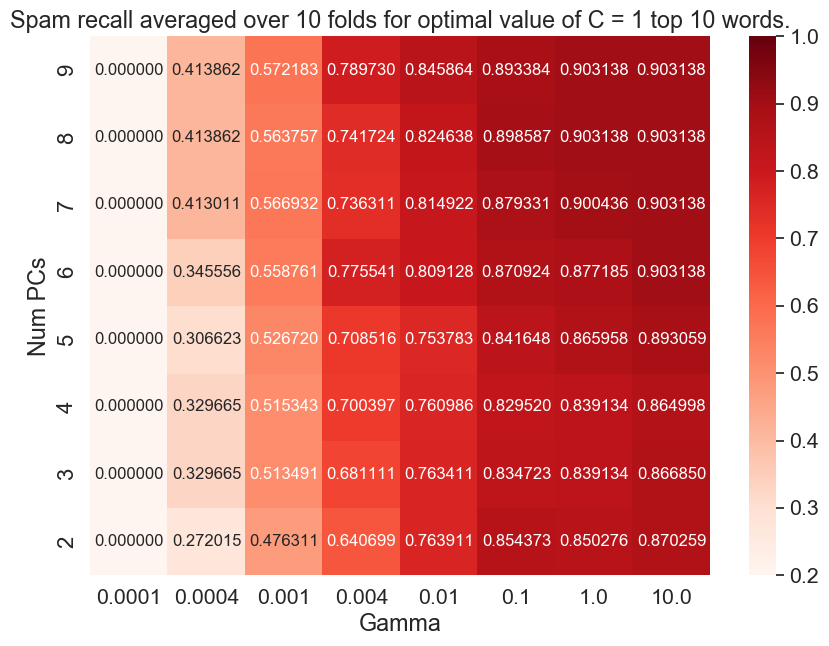

In [55]:
# we are most interested in high recall values:
ind = np.unravel_index(np.argmax(meanRecall, axis=None), meanRecall.shape)
print('optimal parameters for recall = %.3f are: \nn_components= %.d, gamma = %.4f, C = %.3f\n' %( meanRecall[ind],npc_test[ind[0]], gam_test[ind[1]],c_test[ind[2]]))
npc = npc_test[ind[0]]
gamma = gam_test[ind[1]]
C = c_test[ind[2]]

# parameter selection based on spam recall
plt.figure(figsize=(10, 7))
df_rec = pd.DataFrame(meanRecall[:,:,ind[2]], index=npc_test, columns=gam_test)
sns.set(font_scale=1.4)  # for label size
ax = sns.heatmap(df_rec, cbar_kws={'ticks': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}, vmin=0.2, vmax=1.0, annot=True,
                 annot_kws={"size": 12}, fmt='f', cmap="Reds")  # font size
bottom, top = ax.get_ylim()
ax.set_ylim(bottom, top)
ax.set_ylim(sorted(ax.get_xlim(), reverse=True))
ax.set_yticklabels(npc_test,
                   rotation=90, fontsize="16", va="center")
im1 = ax.imshow(meanRecall[:,:,ind[2]], aspect='auto', cmap='Reds')
ax.invert_yaxis()
ax.set_title('Spam recall averaged over 10 folds for optimal value of C = '+str(c_test[ind[2]])+' top 10 words.')
ax.set_xlabel('Gamma')
ax.set_ylabel('Num PCs');

Now we can train the SVM model with optimal parameters on training set and test it on testing:

confusion matrix: 
[[232  10]
 [  9  40]]

accuracy:          0.934708
spam precision:    0.800000
spam recall:       0.816327
f1:                0.808081
average latency:   0.008722 sec.


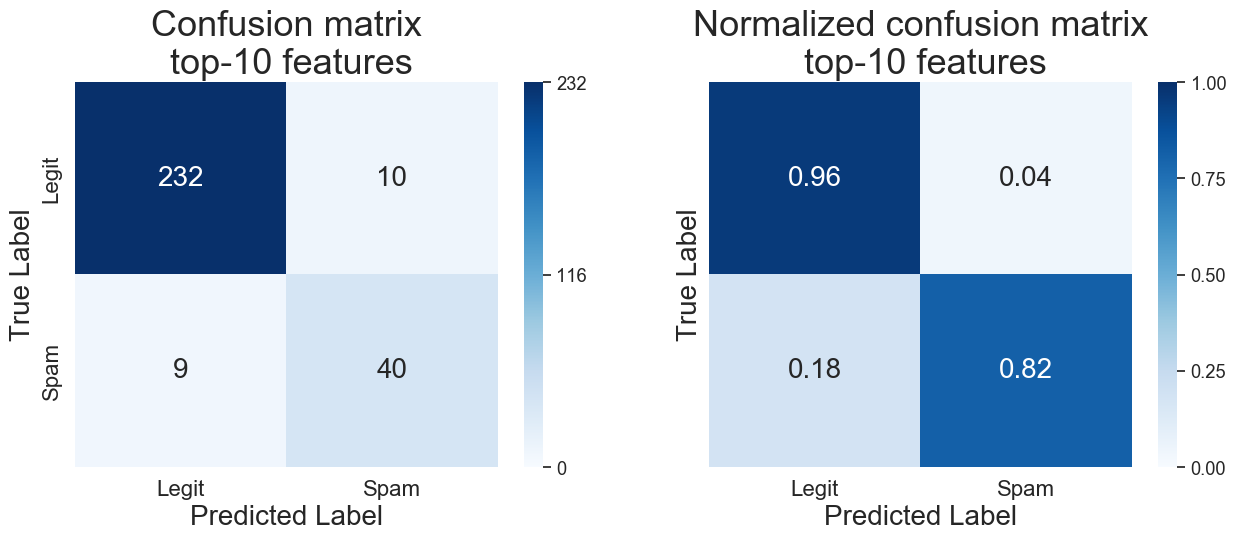

In [56]:
pca = PCA(n_components=npc, svd_solver='randomized', whiten=True)
pca.fit(totalTrainData_10)


# Transform the training and test
Ztr = pca.transform(totalTrainData_10)
Zval = pca.transform(totalTestData_10)

svc = SVC(C=C, kernel='rbf', gamma=gamma)
svc.fit(Ztr, totalTrainlabels_10)

start = time.time()
# Predict on the test data
yhat = svc.predict(Zval)
end = time.time()
latency_SVM_10 = end-start

#evaluating performance
(accuracy_SVM_10,
 precision_SVM_10, 
 recall_SVM_10, 
 f1_SVM_10) = evaluateResults(totalTestlabels_10, yhat,10,latency_SVM_10)

## SVM spam filter with top 100 words

### Getting training and testing sets (part1 to part9 -- training, part10 -- testing)

In [57]:
(totalTrainData_100,totalTrainlabels_100,totalTestData_100,totalTestlabels_100)= createDatasetSVM_BF(100,selectedWords_100,allUniqueTrainingWords,spam_train,legit_train,spam_test,legit_test)

# convert to np.array:
totalTrainData_100 = np.asarray(totalTrainData_100)
totalTrainlabels_100 = np.asarray(totalTrainlabels_100)
totalTestData_100 = np.asarray(totalTestData_100)
totalTestlabels_100 = np.asarray(totalTestlabels_100)

We will be using 10-fold cross validation with the validation set to determine optimal number of the components and Gamma for the SVM.

Some code is borrowed from the code repository for my paper "EEG-based Classification of the Intensity of Emotional Responses:"
https://github.com/vbabushkin/EEG-based-Classification-of-the-Intensity-of-Emotional-Responses

In [58]:
nfold = 10
kf = KFold(nfold, shuffle=True)

# determine optimal parameters:  gamma and number of components (for 10 features)
npc_test = [2,3,4,5,6,7,8,9]
gam_test = [1e-4, 4e-4, 1e-3, 4e-3, 1e-2, 1e-1, 1, 10]
c_test =  [ 1, 10, 100, 1000, 10000, 100000, 1000000] #C ranges from 0 to infinity

accuracy = np.zeros((nfold,len(npc_test),len(gam_test),len(c_test)))
precision = np.zeros((nfold,len(npc_test),len(gam_test),len(c_test)))
recall = np.zeros((nfold,len(npc_test),len(gam_test),len(c_test)))
f1 = np.zeros((nfold,len(npc_test),len(gam_test),len(c_test)))

for ifold, ind in enumerate(kf.split(totalTrainData_100)):
    print('Fold = %d' % ifold)
    # Get the training data in the split
    Itr, Its = ind

    Xtr = totalTrainData_100[Itr, :]
    ytr = totalTrainlabels_100[Itr]
    Xts = totalTrainData_100[Its, :]
    yts = totalTrainlabels_100[Its]
    
    for i0, npc in enumerate(npc_test):
        # Fit PCA on the training data
        pca = PCA(n_components=npc, svd_solver='randomized', whiten=True)
        pca.fit(Xtr)

        # Transform the training and test
        Ztr = pca.transform(Xtr)
        Zts = pca.transform(Xts)

        for i1, gam in enumerate(gam_test):
            for i2, c in enumerate(c_test):
                # Fiting on the transformed training data
                svc = SVC(C=c, kernel='rbf', gamma=gam)
                svc.fit(Ztr, ytr)

                # Predict on the test data
                yhat = svc.predict(Zts)

                accuracy[ifold,i0,i1,i2] = accuracy_score(yts, yhat)
                precision[ifold,i0,i1,i2]= precision_score(yts, yhat)
                recall[ifold,i0,i1,i2] = recall_score(yts, yhat)
                f1[ifold,i0,i1,i2] = f1_score(yts, yhat)


meanRecall = np.mean(recall,0)
ind = np.unravel_index(np.argmax(meanRecall, axis=None), meanRecall.shape)


Fold = 0
Fold = 1
Fold = 2
Fold = 3
Fold = 4
Fold = 5
Fold = 6
Fold = 7
Fold = 8
Fold = 9


### Searching for optimal parameters

In [59]:
# we are mostly interrested for optimal parameters for recall
meanAccuracy = np.mean(accuracy,0)
indAccuracy = np.unravel_index(np.argmax(meanAccuracy, axis=None), meanAccuracy.shape)
print('optimal parameters for accuracy = %.3f are: \nn_components= %.d, gamma = %.4f, C = %.3f\n' %( meanAccuracy[indAccuracy],npc_test[indAccuracy[0]], gam_test[indAccuracy[1]],c_test[indAccuracy[2]]))

meanRecall = np.mean(recall,0)
indRecall = np.unravel_index(np.argmax(meanRecall, axis=None), meanRecall.shape)
print('optimal parameters for recall = %.3f are: \nn_components= %.d, gamma = %.4f, C = %.3f\n' %( meanRecall[ind],npc_test[indRecall[0]], gam_test[indRecall[1]],c_test[indRecall[2]]))

meanPrecision = np.mean(precision,0)
indPrecision = np.unravel_index(np.argmax(meanPrecision, axis=None), meanPrecision.shape)
print('optimal parameters for precision = %.3f are: \nn_components= %.d, gamma = %.4f, C = %.3f\n' %( meanPrecision[indPrecision],npc_test[indPrecision[0]], gam_test[indPrecision[1]],c_test[indPrecision[2]]))

meanF1 = np.mean(f1,0)
indF1 = np.unravel_index(np.argmax(meanF1, axis=None), meanF1.shape)
print('optimal parameters for f1 = %.3f are: \nn_components= %.d, gamma = %.4f, C = %.3f\n' %( meanF1[indF1],npc_test[indF1[0]], gam_test[indF1[1]],c_test[indF1[2]]))

optimal parameters for accuracy = 0.985 are: 
n_components= 9, gamma = 0.0010, C = 1000000.000

optimal parameters for recall = 0.956 are: 
n_components= 9, gamma = 0.0010, C = 1000000.000

optimal parameters for precision = 1.000 are: 
n_components= 2, gamma = 0.0004, C = 1.000

optimal parameters for f1 = 0.956 are: 
n_components= 9, gamma = 0.0010, C = 1000000.000



The optimal parameters leading to high spam recall values with top 100 words are

optimal parameters for recall = 0.956 are: 
n_components= 9, gamma = 0.0010, C = 1000000.000



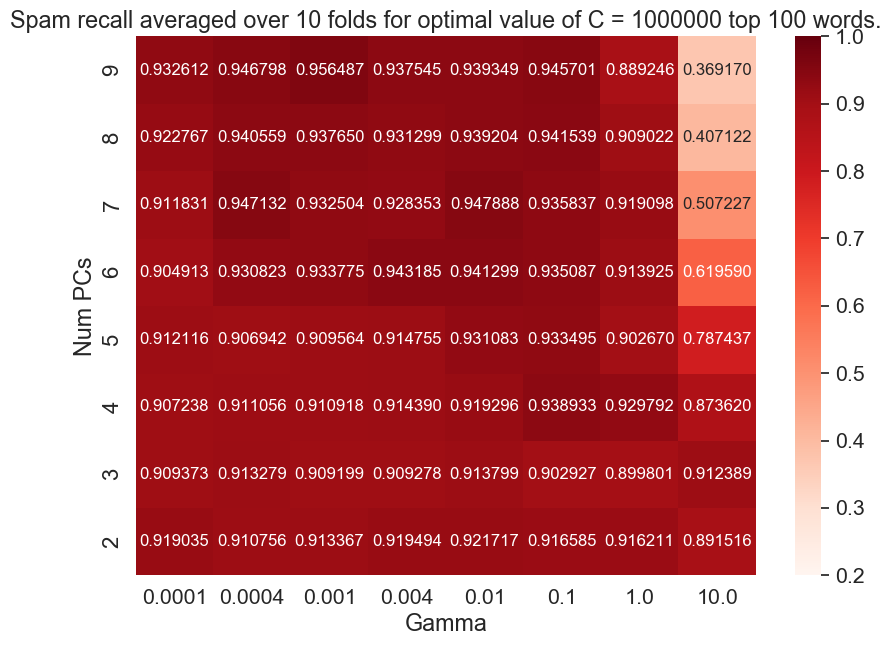

In [60]:
# we are most interested in high recall values:
ind = np.unravel_index(np.argmax(meanRecall, axis=None), meanRecall.shape)
print('optimal parameters for recall = %.3f are: \nn_components= %.d, gamma = %.4f, C = %.3f\n' %( meanRecall[ind],npc_test[ind[0]], gam_test[ind[1]],c_test[ind[2]]))
npc = npc_test[ind[0]]
gamma = gam_test[ind[1]]
C = c_test[ind[2]]

# parameter selection based on spam recall
plt.figure(figsize=(10, 7))
df_rec = pd.DataFrame(meanRecall[:,:,ind[2]], index=npc_test, columns=gam_test)
sns.set(font_scale=1.4)  # for label size
ax = sns.heatmap(df_rec, cbar_kws={'ticks': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}, vmin=0.2, vmax=1.0, annot=True,
                 annot_kws={"size": 12}, fmt='f', cmap="Reds")  # font size
bottom, top = ax.get_ylim()
ax.set_ylim(bottom, top)
ax.set_ylim(sorted(ax.get_xlim(), reverse=True))
ax.set_yticklabels(npc_test,
                   rotation=90, fontsize="16", va="center")
im1 = ax.imshow(meanRecall[:,:,ind[2]], aspect='auto', cmap='Reds')
ax.invert_yaxis()
ax.set_title('Spam recall averaged over 10 folds for optimal value of C = '+str(c_test[ind[2]])+' top 100 words.')
ax.set_xlabel('Gamma')
ax.set_ylabel('Num PCs');

Now we can train the SVM model with optimal parameters on training set and test it on testing:

confusion matrix: 
[[241   1]
 [  4  45]]

accuracy:          0.982818
spam precision:    0.978261
spam recall:       0.918367
f1:                0.947368
average latency:   0.003172 sec.


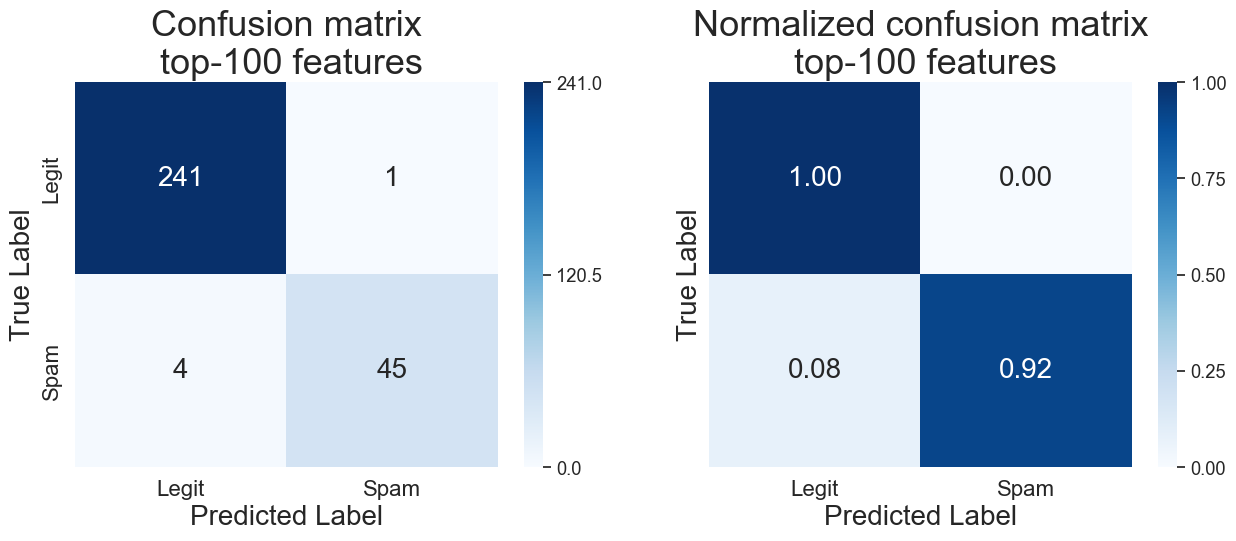

In [61]:
pca = PCA(n_components=npc, svd_solver='randomized', whiten=True)
pca.fit(totalTrainData_100)


# Transform the training and test
Ztr = pca.transform(totalTrainData_100)
Zval = pca.transform(totalTestData_100)

svc = SVC(C=C, kernel='rbf', gamma=gamma)
svc.fit(Ztr, totalTrainlabels_100)

start = time.time()
# Predict on the test data
yhat = svc.predict(Zval)
end = time.time()
latency_SVM_100 = end-start

#evaluating performance
(accuracy_SVM_100,
 precision_SVM_100, 
 recall_SVM_100, 
 f1_SVM_100) = evaluateResults(totalTestlabels_100, yhat,100,latency_SVM_100)


## SVM spam filter with top 1000 words

### Getting training and testing sets (part1 to part9 -- training, part10 -- testing)

In [62]:
(totalTrainData_1000,totalTrainlabels_1000,totalTestData_1000,totalTestlabels_1000)= createDatasetSVM_BF(1000,selectedWords_1000,allUniqueTrainingWords,spam_train,legit_train,spam_test,legit_test)

# convert to np.array:
totalTrainData_1000 = np.asarray(totalTrainData_1000)
totalTrainlabels_1000 = np.asarray(totalTrainlabels_1000)
totalTestData_1000 = np.asarray(totalTestData_1000)
totalTestlabels_1000 = np.asarray(totalTestlabels_1000)

We will be using 10-fold cross validation with the validation set to determine optimal number of the components and Gamma for the SVM.

Some code is borrowed from the code repository for my paper "EEG-based Classification of the Intensity of Emotional Responses:" https://github.com/vbabushkin/EEG-based-Classification-of-the-Intensity-of-Emotional-Responses

In [63]:
nfold = 10
kf = KFold(nfold, shuffle=True)

# determine optimal parameters:  gamma and number of components (for 10 features)
npc_test = [2,3,4,5,6,7,8,9]
gam_test = [1e-4, 4e-4, 1e-3, 4e-3, 1e-2, 1e-1, 1, 10]
c_test =  [ 1, 10, 100, 1000, 10000, 100000, 1000000] #C ranges from 0 to infinity

accuracy = np.zeros((nfold,len(npc_test),len(gam_test),len(c_test)))
precision = np.zeros((nfold,len(npc_test),len(gam_test),len(c_test)))
recall = np.zeros((nfold,len(npc_test),len(gam_test),len(c_test)))
f1 = np.zeros((nfold,len(npc_test),len(gam_test),len(c_test)))

for ifold, ind in enumerate(kf.split(totalTrainData_100)):
    print('Fold = %d' % ifold)
    # Get the training data in the split
    Itr, Its = ind

    Xtr = totalTrainData_1000[Itr, :]
    ytr = totalTrainlabels_1000[Itr]
    Xts = totalTrainData_1000[Its, :]
    yts = totalTrainlabels_1000[Its]
    
    for i0, npc in enumerate(npc_test):
        # Fit PCA on the training data
        pca = PCA(n_components=npc, svd_solver='randomized', whiten=True)
        pca.fit(Xtr)

        # Transform the training and test
        Ztr = pca.transform(Xtr)
        Zts = pca.transform(Xts)

        for i1, gam in enumerate(gam_test):
            for i2, c in enumerate(c_test):
                # Fiting on the transformed training data
                svc = SVC(C=c, kernel='rbf', gamma=gam)
                svc.fit(Ztr, ytr)

                # Predict on the test data
                yhat = svc.predict(Zts)

                accuracy[ifold,i0,i1,i2] = accuracy_score(yts, yhat)
                precision[ifold,i0,i1,i2]= precision_score(yts, yhat)
                recall[ifold,i0,i1,i2] = recall_score(yts, yhat)
                f1[ifold,i0,i1,i2] = f1_score(yts, yhat)


meanRecall = np.mean(recall,0)
ind = np.unravel_index(np.argmax(meanRecall, axis=None), meanRecall.shape)


Fold = 0
Fold = 1
Fold = 2
Fold = 3
Fold = 4
Fold = 5
Fold = 6
Fold = 7
Fold = 8
Fold = 9


### Searching for optimal parameters

In [64]:
# we are mostly interrested for optimal parameters for recall
meanAccuracy = np.mean(accuracy,0)
indAccuracy = np.unravel_index(np.argmax(meanAccuracy, axis=None), meanAccuracy.shape)
print('optimal parameters for accuracy = %.3f are: \nn_components= %.d, gamma = %.4f, C = %.3f\n' %( meanAccuracy[indAccuracy],npc_test[indAccuracy[0]], gam_test[indAccuracy[1]],c_test[indAccuracy[2]]))

meanRecall = np.mean(recall,0)
indRecall = np.unravel_index(np.argmax(meanRecall, axis=None), meanRecall.shape)
print('optimal parameters for recall = %.3f are: \nn_components= %.d, gamma = %.4f, C = %.3f\n' %( meanRecall[ind],npc_test[indRecall[0]], gam_test[indRecall[1]],c_test[indRecall[2]]))

meanPrecision = np.mean(precision,0)
indPrecision = np.unravel_index(np.argmax(meanPrecision, axis=None), meanPrecision.shape)
print('optimal parameters for precision = %.3f are: \nn_components= %.d, gamma = %.4f, C = %.3f\n' %( meanPrecision[indPrecision],npc_test[indPrecision[0]], gam_test[indPrecision[1]],c_test[indPrecision[2]]))

meanF1 = np.mean(f1,0)
indF1 = np.unravel_index(np.argmax(meanF1, axis=None), meanF1.shape)
print('optimal parameters for f1 = %.3f are: \nn_components= %.d, gamma = %.4f, C = %.3f\n' %( meanF1[indF1],npc_test[indF1[0]], gam_test[indF1[1]],c_test[indF1[2]]))

optimal parameters for accuracy = 0.992 are: 
n_components= 9, gamma = 0.0040, C = 1000.000

optimal parameters for recall = 0.978 are: 
n_components= 8, gamma = 0.0100, C = 1000000.000

optimal parameters for precision = 1.000 are: 
n_components= 2, gamma = 0.0001, C = 10.000

optimal parameters for f1 = 0.974 are: 
n_components= 9, gamma = 0.0040, C = 1000.000



The optimal parameters leading to high spam recall values with top 1000 words are

optimal parameters for recall = 0.978 are: 
n_components= 8, gamma = 0.0100, C = 1000000.000



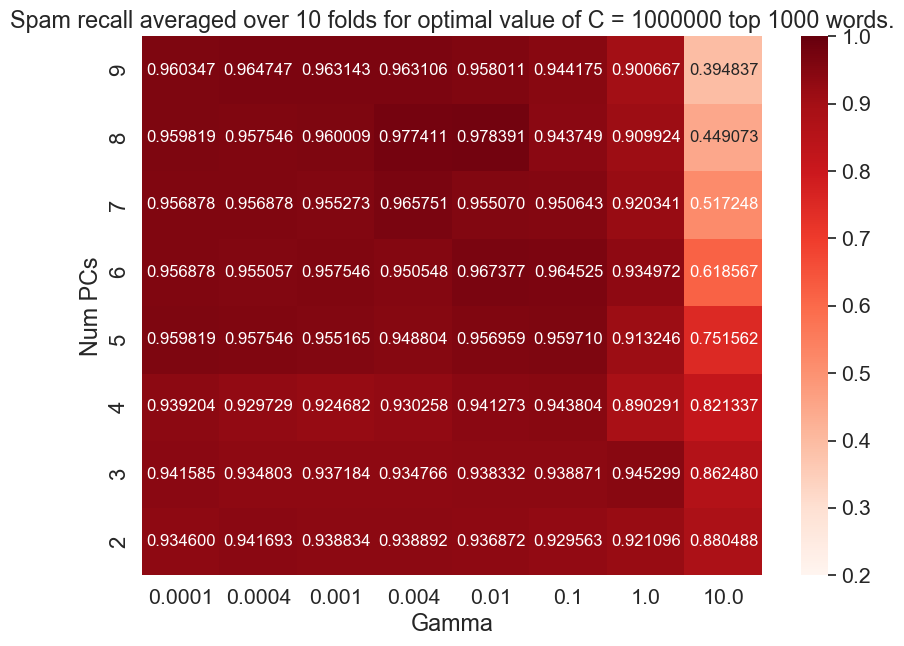

In [65]:
# we are most interested in high recall values:
ind = np.unravel_index(np.argmax(meanRecall, axis=None), meanRecall.shape)
print('optimal parameters for recall = %.3f are: \nn_components= %.d, gamma = %.4f, C = %.3f\n' %( meanRecall[ind],npc_test[ind[0]], gam_test[ind[1]],c_test[ind[2]]))
npc = npc_test[ind[0]]
gamma = gam_test[ind[1]]
C = c_test[ind[2]]

# parameter selection based on spam recall
plt.figure(figsize=(10, 7))
df_rec = pd.DataFrame(meanRecall[:,:,ind[2]], index=npc_test, columns=gam_test)
sns.set(font_scale=1.4)  # for label size
ax = sns.heatmap(df_rec, cbar_kws={'ticks': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}, vmin=0.2, vmax=1.0, annot=True,
                 annot_kws={"size": 12}, fmt='f', cmap="Reds")  # font size
bottom, top = ax.get_ylim()
ax.set_ylim(bottom, top)
ax.set_ylim(sorted(ax.get_xlim(), reverse=True))
ax.set_yticklabels(npc_test,
                   rotation=90, fontsize="16", va="center")
im1 = ax.imshow(meanRecall[:,:,ind[2]], aspect='auto', cmap='Reds')
ax.invert_yaxis()
ax.set_title('Spam recall averaged over 10 folds for optimal value of C = '+str(c_test[ind[2]])+' top 1000 words.')
ax.set_xlabel('Gamma')
ax.set_ylabel('Num PCs');

Now we can train the SVM model with optimal parameters on training set and test it on testing:

confusion matrix: 
[[242   0]
 [  5  44]]

accuracy:          0.982818
spam precision:    1.000000
spam recall:       0.897959
f1:                0.946237
average latency:   0.001791 sec.


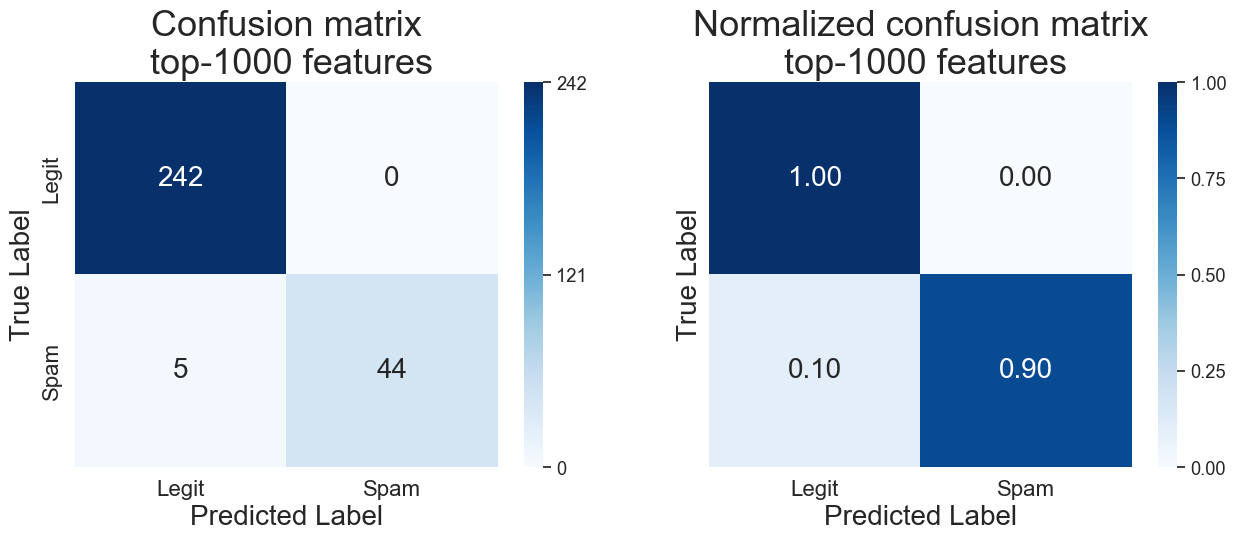

In [66]:
pca = PCA(n_components=npc, svd_solver='randomized', whiten=True)
pca.fit(totalTrainData_1000)


# Transform the training and test
Ztr = pca.transform(totalTrainData_1000)
Zval = pca.transform(totalTestData_1000)

svc = SVC(C=C, kernel='rbf', gamma=gamma)
svc.fit(Ztr, totalTrainlabels_1000)

start = time.time()
# Predict on the test data
yhat = svc.predict(Zval)
end = time.time()
latency_SVM_1000 = end-start

#evaluating performance
(accuracy_SVM_1000,
 precision_SVM_1000, 
 recall_SVM_1000, 
 f1_SVM_1000) = evaluateResults(totalTestlabels_1000, yhat,1000,latency_SVM_1000)




## Comparing performance of SVM for three sets of top words

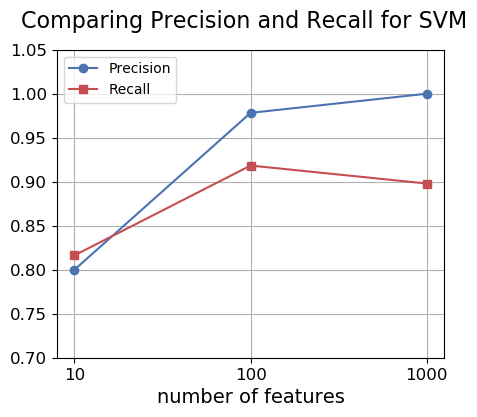

In [67]:
matplotlib.rc_file_defaults()
fig, ax = plt.subplots(figsize=(5,4))
fig.suptitle("Comparing Precision and Recall for SVM",fontsize="16")
ax.set_xticks([0,1,2])
ax.set_xticklabels(['10','100','1000'],fontsize="12")
ax.tick_params(axis="y", labelsize=12)
ax.set_ylim([0.7,1.05])
ax.set_xlabel('number of features', fontsize="14")
ax.plot([precision_SVM_10,precision_SVM_100,precision_SVM_1000], 'bo-',label = 'Precision')
ax.plot([recall_SVM_10,recall_SVM_100,recall_SVM_1000], 'rs-',label = 'Recall');
plt.legend()
ax.grid()

## Summary table of all classifiers

In [68]:
cols= ['classifier', 'N-top words','spam recall', 'spam precision', 'avg. latency, sec']
data = [['Bernoulli NB',10,recall_NB_Bernoulli_10, precision_NB_Bernoulli_10, np.mean(latency_NB_Bernoulli_10)],
        ['Bernoulli NB',100,recall_NB_Bernoulli_100, precision_NB_Bernoulli_100,np.mean(latency_NB_Bernoulli_100)],
        ['Bernoulli NB',1000,recall_NB_Bernoulli_1000, precision_NB_Bernoulli_1000,np.mean(latency_NB_Bernoulli_1000)],
        ['Multinomial NB with TF',10,recall_NB_Multinomial_TF_10, precision_NB_Multinomial_TF_10,np.mean(latency_NB_Multinomial_TF_10)],
        ['Multinomial NB with TF',100,recall_NB_Multinomial_TF_100, precision_NB_Multinomial_TF_100,np.mean(latency_NB_Multinomial_TF_100)],
        ['Multinomial NB with TF',1000,recall_NB_Multinomial_TF_1000, precision_NB_Multinomial_TF_1000,np.mean(latency_NB_Multinomial_TF_1000)],
        ['Multinomial NB with BF',10,recall_NB_Multinomial_BF_10, precision_NB_Multinomial_BF_10,np.mean(latency_NB_Multinomial_BF_10)],
        ['Multinomial NB with BF',100,recall_NB_Multinomial_BF_100, precision_NB_Multinomial_BF_100,np.mean(latency_NB_Multinomial_BF_100)],
        ['Multinomial NB with BF',1000,recall_NB_Multinomial_BF_1000, precision_NB_Multinomial_BF_1000,np.mean(latency_NB_Multinomial_BF_1000)],
        ['SVM with BF',10,recall_SVM_10, precision_SVM_10,np.mean(latency_SVM_10)],
        ['SVM with BF',100,recall_SVM_100, precision_SVM_100,np.mean(latency_SVM_100)],
        ['SVM with BF',1000,recall_SVM_1000, precision_SVM_1000,np.mean(latency_SVM_1000)]
       ]
df_allClassifiersInfo= pd.DataFrame(data = data,columns=cols)
df_allClassifiersInfo

,classifier,N-top words,spam recall,spam precision,"avg. latency, sec"
0,Bernoulli NB,10,0.816327,0.851064,0.000030
1,Bernoulli NB,100,0.714286,1.000000,0.000211
2,Bernoulli NB,1000,0.714286,1.000000,0.002236
3,Multinomial NB with TF,10,0.816327,0.869565,0.000025
4,Multinomial NB with TF,100,0.959184,0.940000,0.000178
5,Multinomial NB with TF,1000,0.673469,1.000000,0.001714
6,Multinomial NB with BF,10,0.816327,0.851064,0.000018
7,Multinomial NB with BF,100,0.959184,0.940000,0.000159
8,Multinomial NB with BF,1000,0.897959,1.000000,0.001759
9,SVM with BF,10,0.816327,0.800000,0.008722


Notice that in contrast to Naive Bayes classifiers the spam recall of SVM clssifier increases with the length of feature vectors.

# Adversarial Classification

We will be using the baseline NB classifier with Boolean features and top-10 terms, identified using the IG metric.

In the baseline NB classifier to decide if the mail is spam or legit we were comparing the probabilities:
$P\{spam|x\} = \frac{P\{x|spam\}P\{spam\}}{P\{x\}}$ and $P\{legit|x\} = \frac{P\{x|legit\}P\{legit\}}{P\{x\}}$

The attacker wants to modify a new email $x'$ such that $P\{spam|x'\}<P\{spam|x\}$.

For the Bernoully NB:

$P\{x|spam\} = P\{x_1,x_2,...,x_m|spam\}=\prod_{i=1}^M p^{x_i}_{i,s}\left(1-p_{i,s}\right)^{1-x_i}$,

thus, if the mail $x$ is such as $P\{spam|x\}>P\{legit|x\}$, then

$P\{x|spam\} \propto \left(1-p_{i,s}\right)$

If we want to modify $x$ in a way that for a new email $x'$:

$P\{x'|spam\} \propto p_{i,s}$

which will reduce the $P\{x'|spam\}$ so that it becomes smaller than $P\{legit|x'\}$ and the modified mail $x'$ will be classified as legitimate. If $p_{i,s}<0.5$ then adding this term to the document makes it more likely classified as spam. Thus we need to check the valies $p_{i,s}$ for each term and determine whether adding these terms to $x'$ will help to reduce $P\{x'|spam\}$.


Given a classifier $C(x)$,which we assume is known to attacker. An attacker is interested to design a minimum-cost algorithm $A(x)$ that takes an original email as input $x$, which has originally been clasified as spam by $C(x)$, and  modifies it the way so it is classified as legitimate with $C(x)$, i.e.

$x' = A(x)$, $C(x)= \text{spam}$, such that $C(x') = \text{legit}$.

The defender also has an access to $A(x)$ and is interested in designing lowest cost modification to $C' = C(A(x))$ to maximize its accuracy and so on.

For any two mails $x$ and $x'$ $c\left(x_i,x_i'\right)$ is the cost incurred for making modifications from $x$ to $x'$, e.g. adding or deliting one keyword incurs a unit cost. And the total cost:

$c(x,x')=\sum_{i}c\left(x_i,x_i'\right)$

A utility function reflects the benifit to the attacker from modifying $x$ to $x'$:

$U_A\left(y_c,y\right)\in \{-1,0,1\}$, 

where $y_c$ is a class predicted by classifier $C$ and $y$ ia a true class.

Thus for the attacker the best utility is $U_A\left(y_c=\text{legit},y=\text{spam}\right)=1$.

The attacker adds the term if it is absent and removes the term if it is present. The reduction obtained by adding/removing term $i$ is:

$\delta_i = \max\left( LO(x_i) - LO(x_i'),0\right)$,

where

$LO(x_i) = \sum_i\log\left(\frac{P\{x_i|spam\}}{P\{x_i|legit\}}\right)$ -- log odds (log likelihood).

If the difference $\delta_i $ is positive  it means that removing the term helps the attacker, if it is 0 then removing the term was not that helpful. The attacker uses all $\delta_i$ scores to find the smallest number of words that need to be modified to get the email classified as legitimate. The attacker gets the array of all $\delta_i $ values and sorts them in descending order and starts from the first element of that sorted list picking up the corresponding word and using it to modify the original email $x$. 

In [204]:
# first we preprocess the data for 10 features:
# for 10 features:

# convert everything into binary vectors

selectedWords_10np = np.asarray(selectedWords_10)


# create data for spam train
spam_train_binary = []
spam_train_labels = []
for mail in spam_train:
    features = np.zeros(10)
    for w in selectedWords_10:
        if w in mail:
            index = np.where(selectedWords_10np == w)[0]
            features[index[0]]=1
    spam_train_binary.append(features)
    spam_train_labels.append(1)
#print(spam_train_binary)


# create data for legit train
legit_train_binary = []
legit_train_labels = []
for mail in legit_train:
    features = np.zeros(10)
    for w in selectedWords_10:
        if w in mail:
            index = np.where(selectedWords_10np == w)[0]
            features[index[0]]=1
    legit_train_binary.append(features)
    legit_train_labels.append(0)
#print(legit_train_binary)

# create data for spam test
spam_test_binary = []
spam_test_labels = []
for mail in spam_test:
    features = np.zeros(10)
    for w in selectedWords_10:
        if w in mail:
            index = np.where(selectedWords_10np == w)[0]
            features[index[0]]=1
    spam_test_binary.append(features)
    spam_test_labels.append(1)
#print(spam_test_binary)


# create data for legit test
legit_test_binary = []
legit_test_labels = []
for mail in legit_test:
    features= np.zeros(10)
    for w in selectedWords_10:
        if w in mail:
            index = np.where(selectedWords_10np == w)[0]
            features[index[0]]=1
    legit_test_binary.append(features)
    legit_test_labels.append(0)
#print(legit_test_binary)


We will be using the build-in implementation of Bernoulli NB classifier from sklearn.naive_bayes library (https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html), since it models a realisitic situation when the attacker modifies the email in a way the classifier considers it as a legit.

Also, as we confirmed previously, the calssification results with the build-in Bernoulli NB classifier are the same and the probabilities are almost the same as for the manually implemented Bernoully NB. 

First we create an instance of Bernoulli classifier, train and test it on the original data:

confusion matrix: 
[[235   7]
 [  9  40]]

accuracy:          0.945017
spam precision:    0.851064
spam recall:       0.816327
f1:                0.833333
average latency:   0.000002 sec.


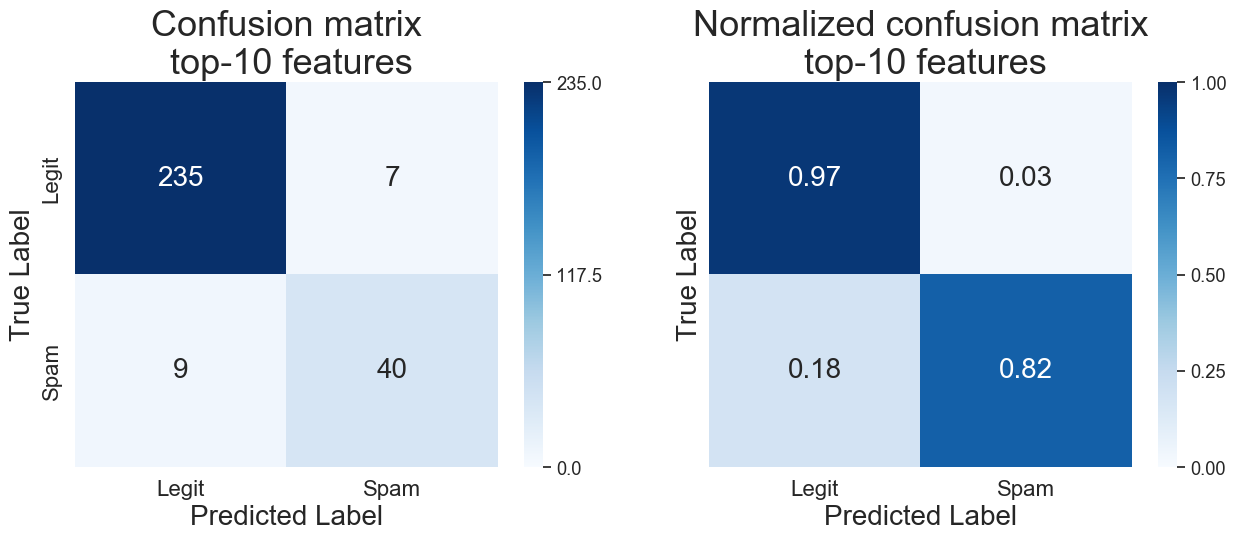

In [143]:
# create a classifier
clf = BernoulliNB()

# create a training dataset (parts 1 to 9):
totalTrainDataOrig = spam_train_binary.copy()
totalTrainDataOrig.extend(legit_train_binary)

totalTrainLabelsOrig = spam_train_labels.copy()
totalTrainLabelsOrig.extend(legit_train_labels)

# create a testing dataset(part 10)
totalTestDataOrig = spam_test_binary.copy()
totalTestDataOrig.extend(legit_test_binary)

totalTestLabelsOrig = spam_test_labels.copy()
totalTestLabelsOrig.extend(legit_test_labels)

# fit the classifier to the training data
clf.fit(totalTrainDataOrig, totalTrainLabelsOrig)

# then test it on part10
start = time.time()
predLabelsTestOrig = clf.predict(totalTestDataOrig)
end = time.time()
latency_Bernoulli_buildin_10 = (end-start)/len(totalTestDataOrig)

# evaluating performance:
(accuracy_NB_Bernoulli_buildin_10,
 precision_NB_Bernoulli_buildin_10, 
 recall_NB_Bernoulli_buildin_10, 
 f1_NB_Bernoulli_buildin_10) = evaluateResults(totalTestLabelsOrig,predLabelsTestOrig,10,latency_Bernoulli_buildin_10)

We are interested in probabilities of whether the email spam or legit (https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB.predict_proba):

In [144]:
probs = clf.predict_proba(totalTestDataOrig)
print(probs.shape)

(291, 2)


The columns correspond to the classes in sorted order,therefore the first column of probs array contains probabilities of emails being legit (class 0) and the second column -- probabilities of email being spam (class 1).

In [145]:
mailIdx = 0
pSpamModifiedAll = []
pLegitModifiedAll = []
tmpTotalTestDataOrig = totalTestDataOrig.copy()
deltasAll=[]
for mail in tmpTotalTestDataOrig:
    modifiedMail = mail
    if totalTestLabelsOrig[mailIdx] == 1:
        pSpamModified  = {}
        pLegitModified = {}
        deltas={}
        wordIdx = 0
        for word in mail:
            if word == 0:
                probs0=clf.predict_proba(mail.reshape(1, -1)) # get the probabilities for original mail
                (pLegitX0,pSpamX0)=(probs[0,0], probs[0,1])
                LO_xi=np.log(pSpamX0/pLegitX0)
                
                modifiedMail[wordIdx] = 1 #modify mail by inserting a new word
                probs=clf.predict_proba(modifiedMail.reshape(1, -1)) 
                (pLegitX,pSpamX)=(probs[0,0], probs[0,1])
                LO_xi_prime=np.log(pSpamX/pLegitX)
                
                diff=LO_xi-LO_xi_prime
                deltas[wordIdx]=max(diff,0)
                pSpamModified[wordIdx]=pSpamX
                pLegitModified[wordIdx]=pLegitX
                modifiedMail[wordIdx] = 0 #roll back changes
                
            else:
                probs=clf.predict_proba(modifiedMail.reshape(1, -1)) 
                (pLegitX,pSpamX)=(probs[0,0], probs[0,1])
                pSpamModified[wordIdx]=pSpamX
                pLegitModified[wordIdx]=pLegitX
                
                deltas[wordIdx]=0
            wordIdx+=1
        pSpamModifiedAll.append(pSpamModified)
        pLegitModifiedAll.append(pLegitModified)
        deltasAll.append(deltas)
    mailIdx+=1

In [73]:
# sort deltas
pSpamModifiedDeltasAllSorted = []

# the spam probabilities we sort in decreasing order:
for pSpamDict in deltasAll:
    tmpSpamDict = {k: v for k, v in sorted(pSpamDict.items(), key=lambda item: item[1])}
    pSpamModifiedDeltasAllSorted.append(tmpSpamDict)
print("Sorted probabilities of email being spam:")
print(pSpamModifiedDeltasAllSorted[0])

Sorted probabilities of email being spam:
{1: 0, 2: 0, 4: 0, 5: 0, 6: 0, 9: 0.1707646462126382, 8: 0.3774262586160049, 7: 0.931705473230318, 0: 4.66814498514948, 3: 9.187147254062637}


In [74]:
# sort probabilities
pSpamModifiedAllSorted = []

# the spam probabilities we sort in decreasing order:
for pSpamDict in pSpamModifiedAll:
    tmpSpamDict = {k: v for k, v in sorted(pSpamDict.items(), key=lambda item: item[1])}
    pSpamModifiedAllSorted.append(tmpSpamDict)
print("Sorted probabilities of email being spam:")
print(pSpamModifiedAllSorted[0])

# the legit probabilities we sort in increasing order:
pLegitModifiedAllSorted=[]
for pLegitDict in pLegitModifiedAll:
    tmpLegitDict = {k: v for k, v in sorted(pLegitDict.items(), key=lambda item: item[1], reverse=True)}
    pLegitModifiedAllSorted.append(tmpLegitDict)
print("Sorted probabilities of email being legit:")
print(pLegitModifiedAllSorted[0])

Sorted probabilities of email being spam:
{3: 0.016985065223996374, 0: 0.06793440719485151, 4: 0.19054478227895907, 1: 0.8858752947837205, 9: 0.9901515120005157, 8: 0.9916846724297067, 2: 0.9941115544729195, 7: 0.9942838710881602, 5: 0.994444856216238, 6: 0.9977406955343708}
Sorted probabilities of email being legit:
{3: 0.9830149347760037, 0: 0.9320655928051483, 4: 0.8094552177210409, 1: 0.11412470521627992, 9: 0.009848487999484536, 8: 0.008315327570293572, 2: 0.00588844552708068, 7: 0.005716128911839678, 5: 0.005555143783761816, 6: 0.002259304465629475}


In [75]:
spamTestEmails = spam_test_binary.copy()
spamTestEmailsModified = []
costArray = []
mailIdx = 0
stop=0
for mail in spamTestEmails:
    costCounter = 0
    tmpModifiedSpamTestEmail = np.zeros((1,10))[0]
    for probDict in pSpamModifiedAllSorted:#pSpamModifiedAllSorted:
        for prob in probDict:
            tmpModifiedSpamTestEmail[prob]=1
            costCounter+=1
            probs=clf.predict_proba(tmpModifiedSpamTestEmail.reshape(1, -1)) 
            (pLegitX,pSpamX)=(probs[0,0], probs[0,1])
            r = pSpamX/pLegitX
            if r<1:
                stop = 1
                break
        if stop:
            break
    spamTestEmailsModified.append(tmpModifiedSpamTestEmail) 
    costArray.append(costCounter)
    mailIdx+=1


In [76]:
totalTestDataModified = spamTestEmailsModified.copy()
totalTestDataModified.extend(legit_test_binary)

In [77]:
print(np.sum(costArray)/len(spam_test_binary))

1.0


In [78]:
# perform classification on modified test data:
predLabelsModified = []
pSpamXModified = []
pLegitXModified = []
latency_Bernoulli_modified_10=[]
for modifiedMail in totalTestDataModified:
    start = time.time()
    modifiedMail=modifiedMail.reshape(1, -1)
    yhat = clf.predict(modifiedMail)
    end = time.time()
    probs=clf.predict_proba(modifiedMail) 
    (pLegitX,pSpamX)=(probs[0,0], probs[0,1])
    pSpamXModified.append(pSpamX)
    pLegitXModified.append(pLegitX)
    predLabelsModified.append(yhat)
    latency_Bernoulli_modified_10.append(end-start)

## Evaluate

confusion matrix: 
[[235   7]
 [ 49   0]]

accuracy:          0.807560
spam precision:    0.000000
spam recall:       0.000000
f1:                0.000000
average latency:   0.000130 sec.


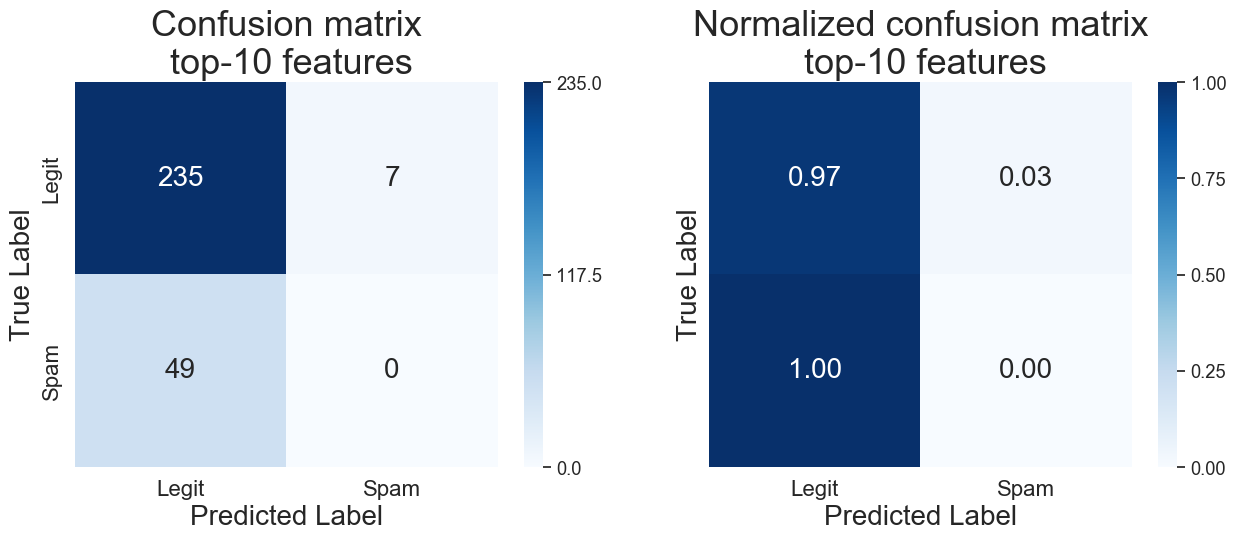

In [79]:
# evaluating performance:

(accuracy_NB_Bernoulli_modified_10,
 precision_NB_Bernoulli_modified_10, 
 recall_NB_Bernoulli_modified_10, 
 f1_NB_Bernoulli_modified_10) = evaluateResults(totalTestLabelsOrig,predLabelsModified,10,latency_Bernoulli_modified_10)

We can see that the attacker is capable of modifying the mail the way that all of the spam is classified as legitimate.

Now we want to update the Bernoulli NB classifier so it responds to the attack. The best way to do it is to modify the training data similar way and train the classifier on that training data:


In [80]:
mailIdx = 0
pSpamTrainModifiedAll = []
pLegitTrainModifiedAll = []
tmpTotalTrainDataOrig = totalTrainDataOrig.copy()
for mail in tmpTotalTrainDataOrig:
    modifiedMail = mail
    if totalTrainLabelsOrig[mailIdx] == 1:
        pSpamModified  = {}
        pLegitModified = {}
        wordIdx = 0
        for word in mail:
            if word == 0:
                modifiedMail[wordIdx] = 1 #modify mail by inserting a new word
                probs=clf.predict_proba(modifiedMail.reshape(1, -1)) 
                (pLegitX,pSpamX)=(probs[0,0], probs[0,1])
                pSpamModified[wordIdx]=pSpamX
                pLegitModified[wordIdx]=pLegitX
                modifiedMail[wordIdx] = 0 #roll back changes
            else:
                probs=clf.predict_proba(modifiedMail.reshape(1, -1)) 
                (pLegitX,pSpamX)=(probs[0,0], probs[0,1])
                pSpamModified[wordIdx]=pSpamX
                pLegitModified[wordIdx]=pLegitX
            wordIdx+=1
        pSpamTrainModifiedAll.append(pSpamModified)
        pLegitTrainModifiedAll.append(pLegitModified)
    mailIdx+=1

Sort probabilities

In [81]:
pSpamTrainModifiedAllSorted = []

# the spam probabilities we sort in decreasing order:
for pSpamDict in pSpamTrainModifiedAll:
    tmpSpamDict = {k: v for k, v in sorted(pSpamDict.items(), key=lambda item: item[1])}
    pSpamTrainModifiedAllSorted.append(tmpSpamDict)
print(pSpamTrainModifiedAllSorted[0])

# the legit probabilities we sort in increasing order:
pLegitTrainModifiedAllSorted=[]
for pLegitDict in pLegitTrainModifiedAll:
    tmpLegitDict = {k: v for k, v in sorted(pLegitDict.items(), key=lambda item: item[1], reverse=True)}
    pLegitTrainModifiedAllSorted.append(tmpLegitDict)
print(pLegitTrainModifiedAllSorted[0])

{3: 0.20977708226536215, 0: 0.5282597741497793, 4: 0.7833923560354342, 1: 0.9916846724297067, 8: 0.9916846724297067, 9: 0.9993530279473863, 2: 0.9996146132139951, 7: 0.999625951579193, 5: 0.9996365410189936, 6: 0.999852635880625}
{3: 0.7902229177346386, 0: 0.471740225850221, 4: 0.2166076439645653, 1: 0.008315327570293572, 8: 0.008315327570293572, 9: 0.0006469720526132509, 2: 0.0003853867860045579, 7: 0.0003740484208065536, 5: 0.000363458981006162, 6: 0.00014736411937523686}


Now modify spam train email according to the attacker's strategy

In [82]:
spamTrainEmails = spam_train_binary.copy()
spamTrainEmailsModified = []
costTrainArray = []
mailIdx = 0
stop=0
for mail in spamTrainEmails:
    costCounter = 0
    tmpModifiedSpamTrainEmail = np.zeros((1,10))[0]
    for probDict in pSpamTrainModifiedAllSorted:
        for prob in probDict:
            tmpModifiedSpamTrainEmail[prob]=1
            costCounter+=1
            probs=clf.predict_proba(tmpModifiedSpamTrainEmail.reshape(1, -1)) 
            (pLegitX,pSpamX)=(probs[0,0], probs[0,1])
            r = pSpamX/pLegitX
            if r<1:
                stop = 1
                break
        if stop:
            break
    spamTrainEmailsModified.append(tmpModifiedSpamTrainEmail) 
    costTrainArray.append(costCounter)
    mailIdx+=1


Create a dataset to train the updated classifier

In [83]:
totalTrainDataModified = spamTrainEmailsModified.copy()
totalTrainDataModified.extend(legit_train_binary)

totalTrainLabels = spam_train_labels.copy()
totalTrainLabels.extend(legit_train_labels)

In [84]:
# fit the classifier on the modified training dataset
clf.fit(totalTrainDataModified, totalTrainLabels)
# test it on the modified testing set
start = time.time()
predLabelsTest = clf.predict(totalTestDataModified)
end =time.time()
latency_NB_Bernoulli_updated_10 = (end-start)/len(predLabelsTest)

## Evaluate performance

confusion matrix: 
[[238   4]
 [  0  49]]

accuracy:          0.986254
spam precision:    0.924528
spam recall:       1.000000
f1:                0.960784
average latency:   0.000001 sec.


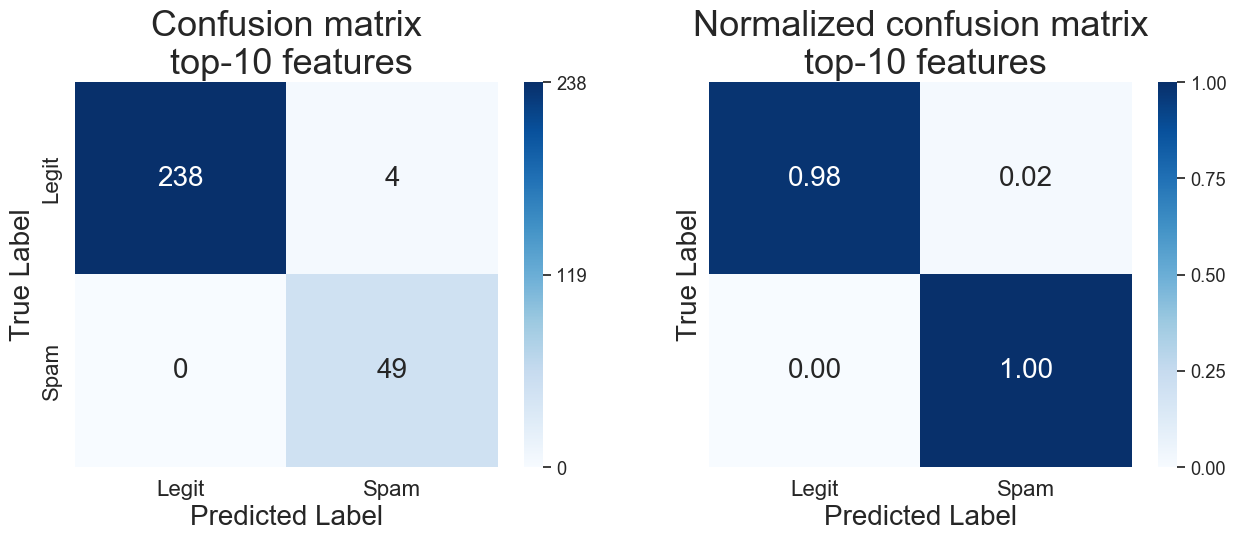

In [85]:
# evaluating performance:
(accuracy_NB_Bernoulli_updated_10,
 precision_NB_Bernoulli_updated_10, 
 recall_NB_Bernoulli_updated_10, 
 f1_NB_Bernoulli_updated_10) = evaluateResults(totalTestLabels, predLabelsTest,10,latency_NB_Bernoulli_updated_10)

# Approach used in the class



In [249]:
# define a NB classifier:

def C(x,selectedWords_10,spamWordsTrainDict,legitWordsTrainDict):
    spamPX = 1  # probability of X given spam
    legitPX = 1 # probability of X given legit

    totalNumberWordSpam = 0
    totalNumberWordLegit = 0
    i=0
    allSpamPX = []
    allLegitPX = []
    for word in selectedWords_10:
        if word in spamWordsTrainDict:
            totalNumberWordSpam = spamWordsTrainDict[word]
        else:
            totalNumberWordSpam = 1
        if word in legitWordsTrainDict:
            totalNumberWordLegit = legitWordsTrainDict[word]
        else:
            totalNumberWordLegit = 1
        pSpam = (totalNumberWordSpam+1)/(numSpamMailsTrain+2)    #p_{i,s} for spam
        pLegit = (totalNumberWordLegit+1)/(numLegitMailsTrain+2) #p_{i,s} for legit
        spamPX = spamPX * (pSpam ** x[i]) * ((1 - pSpam)**(1 - x[i]))    #p{x|spam}
        legitPX = legitPX * (pLegit** x[i]) * ((1 - pLegit)**(1 - x[i]))#p{x|legit}
        allSpamPX.append(spamPX)
        allLegitPX.append(legitPX)
        i+=1

    pSpamX = (spamPX * spamP) / ((spamP * spamPX) + (legitP * legitPX)) # P{spam|x}
    pLegitX = (legitPX * legitP) / ((spamP * spamPX) + (legitP * legitPX))# P{legit|x}
    
    r = pSpamX/pLegitX
    if  r > 1:
        yhat = 1
    else:
        yhat = 0
  
    return (allSpamPX,allLegitPX,yhat)



In [250]:
#check if it works
totalTestData =  [i for i in spam_test_binary] # create deep copy of spam_test_binary
totalTestData.extend(legit_test_binary)

totalTestlabels = [i for i in spam_test_labels]  
totalTestlabels.extend(legit_test_labels)

predLabels_NB_Bernoulli_orig_10 = []
latency_NB_Bernoulli_orig_10 = []
for x in totalTestData:
    start = time.time()
    (allSpamPX,allLegitPX,yhat)=C(x,selectedWords_10,spamWordsTrainDict,legitWordsTrainDict)
    print(x)
    print(allSpamPX)
    print()
    end = time.time()
    latency_NB_Bernoulli_orig_10.append(end-start)
    predLabels_NB_Bernoulli_orig_10.append(yhat)
    

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.9815668202764977, 0.42067149440421325, 0.1764106266856378, 0.1755976744889298, 0.1683148216299419, 0.10238505278872043, 0.07478355238254464, 0.05186601213628096, 0.034657012717791424, 0.0230780568558565]

[0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
[0.9815668202764977, 0.5608953258722843, 0.32568115695810057, 0.32418032213340886, 0.31073505531681583, 0.1890185589945608, 0.13806194286008242, 0.09575263779005716, 0.0639821773251534, 0.021376533898956784]

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0.9815668202764977, 0.5608953258722843, 0.32568115695810057, 0.32418032213340886, 0.31073505531681583, 0.1890185589945608, 0.13806194286008242, 0.09575263779005716, 0.0639821773251534, 0.04260564342619662]

[0. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
[0.9815668202764977, 0.42067149440421325, 0.24426086771857544, 0.24313524160005667, 0.23305129148761192, 0.14176391924592063, 0.03821746210085879, 0.02650565919898271, 0.0177111547642972, 0.01179383347207809]

[0. 0. 1. 0. 0. 1. 0. 1. 1. 1.]
[0.98

confusion matrix: 
[[235   7]
 [  9  40]]

accuracy:          0.945017
spam precision:    0.851064
spam recall:       0.816327
f1:                0.833333
average latency:   0.000375 sec.


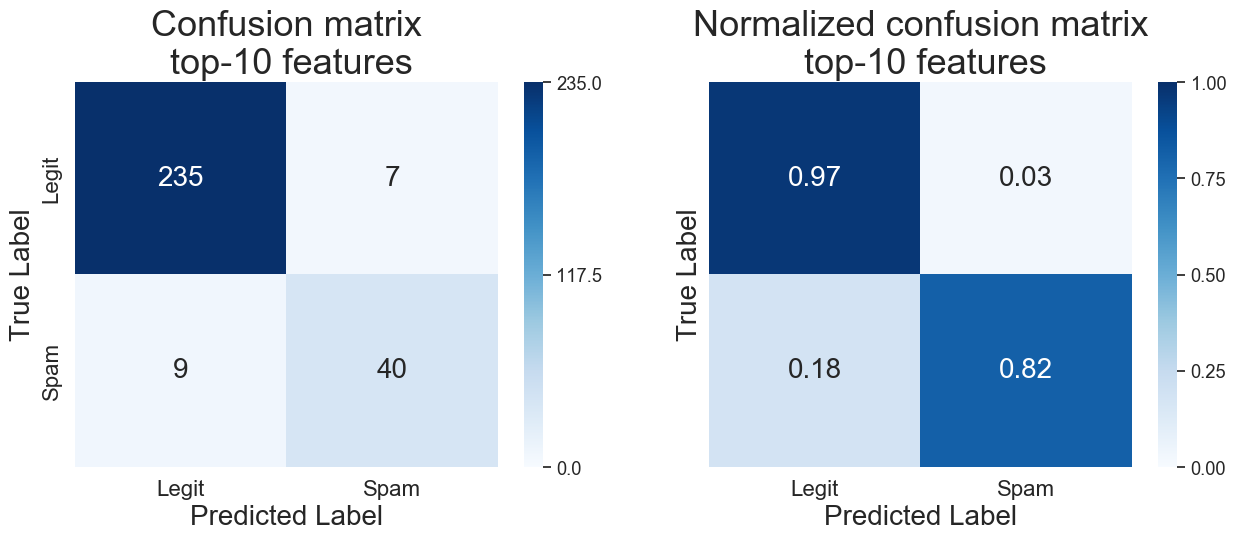

In [251]:
# evaluating performance:
(accuracy_NB_Bernoulli_orig_10,
 precision_NB_Bernoulli_orig_10, 
 recall_NB_Bernoulli_orig_10, 
 f1_NB_Bernoulli_orig_10) = evaluateResults(totalTestLabels, predLabels_NB_Bernoulli_orig_10,10,latency_NB_Bernoulli_orig_10)

In [252]:
# modifying the test data:
tmpTotalTestData = [i for i in totalTestData]
spamTestEmails = [i for i in spam_test_binary] 


mailIdx = 0
pSpamModifiedAll = []
pLegitModifiedAll = []
deltasAll = []

for mail in spamTestEmails:
    modifiedMail = mail
    wordIdx = 0
    deltas={}
    for word in mail:
        if word == 0: # we will be using ADD-WORDS strategy
            # before modification:
            (allSpamPX0,allLegitPX0,yhat) = C(modifiedMail,selectedWords_10,spamWordsTrainDict,legitWordsTrainDict)
            LO_xi=np.log(allSpamPX0[wordIdx]/allLegitPX0[wordIdx])
            modifiedMail[wordIdx] = 1 #modify mail by inserting a new word
            (allSpamPX,allLegitPX,yhat) = C(modifiedMail,selectedWords_10,spamWordsTrainDict,legitWordsTrainDict)
            LO_xi_prime=np.log(allSpamPX[wordIdx]/allLegitPX[wordIdx])
            diff=LO_xi-LO_xi_prime
            deltas[wordIdx]=max(diff,0) # since the unit cost is 1 then benefit per unit cost (delta_i/C_i) is delta_i
            modifiedMail[wordIdx] = 0 #roll back changes
        else:
            deltas[wordIdx]=0
        wordIdx+=1
    deltasAll.append(deltas)
    mailIdx+=1

print(deltasAll[0])

{0: 4.668144985149479, 1: 0, 2: 0, 3: 5.412114985040655, 4: 3.495758640122782, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}


In [253]:
# sort deltas in decreasing order
deltasModifiedAllSorted = []

# the spam probabilities we sort in decreasing order:
for deltaDict in deltasAll:
    tmpDeltaDict = {k: v for k, v in sorted(deltaDict.items(), key=lambda item: item[1], reverse=True)}
    deltasModifiedAllSorted.append(tmpDeltaDict)

print(deltasModifiedAllSorted)


[{3: 5.412114985040655, 0: 4.668144985149479, 4: 3.495758640122782, 1: 0, 2: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}, {3: 5.412114985040655, 0: 4.668144985149479, 4: 3.4957586401227827, 1: 0, 2: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}, {3: 5.412114985040655, 0: 4.668144985149479, 4: 3.4957586401227827, 1: 0, 2: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}, {3: 5.412114985040656, 0: 4.668144985149479, 4: 3.4957586401227827, 1: 0, 2: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}, {3: 5.412114985040655, 0: 4.668144985149479, 4: 3.4957586401227827, 1: 0, 2: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}, {3: 5.412114985040655, 0: 4.668144985149479, 4: 3.4957586401227827, 1: 0, 2: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}, {3: 5.412114985040656, 0: 4.668144985149479, 4: 3.4957586401227827, 1: 0, 2: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}, {3: 5.412114985040655, 0: 4.668144985149479, 1: 0, 2: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}, {3: 5.412114985040655, 0: 4.668144985149479, 4: 3.4957586401227823, 1: 0, 2: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}, {3: 5.412114985040

In [254]:
# this is A(x) = x' -- the minimum cost modification of mail x such as the modified mail x' is classified as legit
spamTestEmails = [i for i in spam_test_binary] 

spamTestEmailsModified = []
costArray = []
mailIdx = 0
stop=0
for mail in spamTestEmails:
    costCounter = 0
    tmpModifiedSpamTestEmail = [i for i in mail] 
    for deltaDict in deltasModifiedAllSorted:
        for key, value in deltaDict.items():
            delta = key
            if value !=0:
                tmpModifiedSpamTestEmail[delta]=1
                costCounter+=1
                (allSpamPX0,allLegitPX0,yhat)=C(tmpModifiedSpamTestEmail,selectedWords_10,spamWordsTrainDict,legitWordsTrainDict)
                #print(yhat)
                if yhat == 0:
                    #print(mail)
                    #print(tmpModifiedSpamTestEmail)
                    #print(delta)
                    stop = 1
                    break
        if stop:
            break
    spamTestEmailsModified.append(tmpModifiedSpamTestEmail) 
    #print(tmpModifiedSpamTestEmail)
    costArray.append(costCounter)
    mailIdx+=1

In [255]:
#print modifies vs original
for i in range(len(spamTestEmailsModified)):
    print(spamTestEmailsModified[i])
    print(spamTestEmails[i])
    print()


[0.0, 1.0, 0.0, 1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]

[0.0, 0.0, 1.0, 1, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]

[0.0, 0.0, 1.0, 1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]

[1, 1.0, 1.0, 1, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
[0. 1. 1. 0. 0. 0. 1. 0. 0. 0.]

[1, 0.0, 1.0, 1, 1, 1.0, 0.0, 1.0, 1.0, 1.0]
[0. 0. 1. 0. 0. 1. 0. 1. 1. 1.]

[0.0, 0.0, 1.0, 1, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
[0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]

[0.0, 1.0, 1.0, 1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]

[0.0, 0.0, 0.0, 1, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]

[0.0, 0.0, 0.0, 1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

[1, 0.0, 1.0, 1, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0]
[0. 0. 1. 0. 0. 1. 1. 0. 0. 0.]

[0.0, 0.0, 0.0, 1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

[0.0, 0.0, 0.0, 1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

[0.0, 0.0, 1.0, 1, 0.0, 

In [256]:
#check if it works with modified data
totalTestDataModified =  [i for i in spamTestEmailsModified] # create deep copy of spam_test_binary
totalTestDataModified.extend(legit_test_binary)

totalTestLabelsModified = [i for i in spam_test_labels]  
totalTestLabelsModified.extend(legit_test_labels)

predLabels_NB_Bernoulli_Modified_10 = []
latency_NB_Bernoulli_Modified_10 = []
for x in totalTestDataModified:
    start = time.time()
    (allSpamPX,allLegitPX,yhat)=C(x,selectedWords_10,spamWordsTrainDict,legitWordsTrainDict)
    end = time.time()
    latency_NB_Bernoulli_Modified_10.append(end-start)
    predLabels_NB_Bernoulli_Modified_10.append(yhat)

confusion matrix: 
[[235   7]
 [ 47   2]]

accuracy:          0.814433
spam precision:    0.222222
spam recall:       0.040816
f1:                0.068966
average latency:   0.000033 sec.


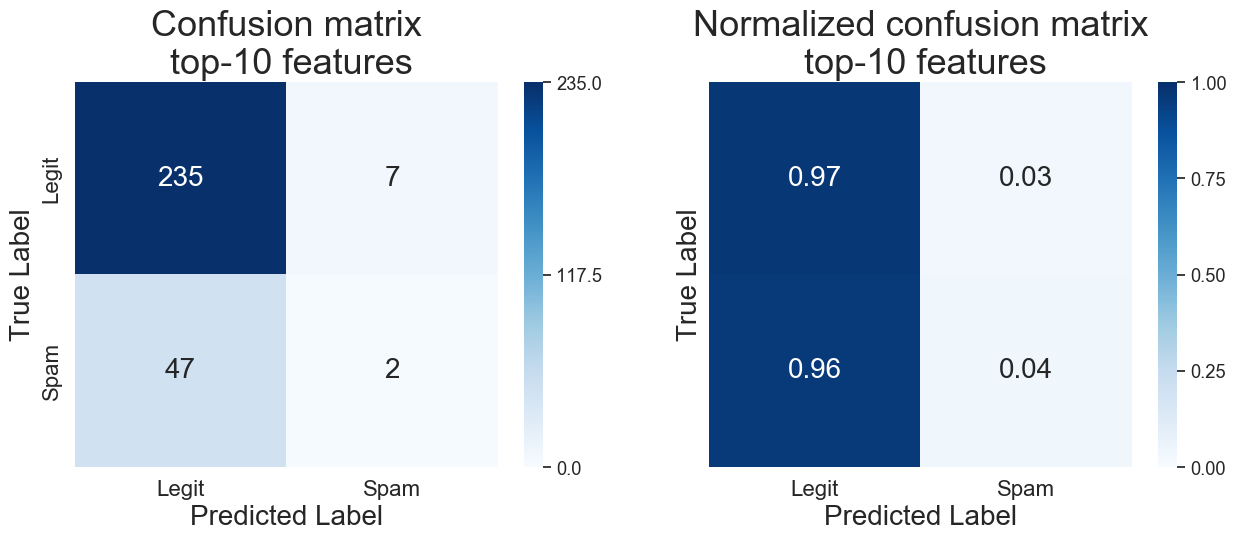

In [257]:
# evaluating performance:
(accuracy_NB_Bernoulli_Modified_10,
 precision_NB_Bernoulli_Modified_10, 
 recall_NB_Bernoulli_Modified_10, 
 f1_NB_Bernoulli_Modified_10) = evaluateResults(totalTestLabelsModified, predLabels_NB_Bernoulli_Modified_10,10,latency_NB_Bernoulli_Modified_10)

In [258]:
print(costArray)
print("Average cost of modifying the data: "+str(np.sum(costArray)/len(spam_test_binary)))

[1, 1, 1, 2, 3, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 3, 3, 2, 1, 1, 1, 3]
Average cost of modifying the data: 1.4081632653061225


In [259]:
# check with one mail:
from itertools import product
#https://stackoverflow.com/questions/59343469/all-possible-3-digit-combinations-of-1-and-0-in-python
modifiedMail = spamTestEmailsModified[-1].copy()
print(modifiedMail)

deltasModifiedAllSorted[-1]
deltaDict = deltasModifiedAllSorted[-1]# remove -1 later
indicesModified = []

for key, value in deltaDict.items():
    delta = key
    if value !=0:
        indicesModified.append(delta)
mm2 = list(product([0, 1], repeat=3))

patternMails = [] 
for idx in range(len(mm2)):
    modifiedTerms = list(mm2[idx])
    tmpPatternMail = modifiedMail.copy()
    for k in range(len(indicesModified)):
        tmpPatternMail[np.sort(indicesModified)[k]] = modifiedTerms[k]
    patternMails.append(tmpPatternMail)# define possible original mails
    
print(len(patternMails))    
    
# count number of mails in original data with the same pattern:
count = 0
foundMails = []
for patternMail in patternMails:
    for originalMail in spamTestEmails:
        equal = all(m == n for m, n in zip(patternMail, originalMail)) 
        if equal:
            count+=1
            foundMails.append(originalMail)
print("Found mails:")
print(foundMails)

# calculate probabilites for patternMails:
spamProbabilites = np.zeros((len(foundMails),len(selectedWords_10)))
mailIdx = 0
for foundMail in foundMails:
    totalNumberWordSpam = 0
    totalNumberWordLegit = 0
    i=0
    for word in selectedWords_10:
        if word in spamWordsTrainDict:
            totalNumberWordSpam = spamWordsTrainDict[word]
        else:
            totalNumberWordSpam = 1
        if word in legitWordsTrainDict:
            totalNumberWordLegit = legitWordsTrainDict[word]
        else:
            totalNumberWordLegit = 1
        pSpam = (totalNumberWordSpam+1)/(numSpamMailsTrain+2)    #p_{i,s} for spam
        pLegit = (totalNumberWordLegit+1)/(numLegitMailsTrain+2) #p_{i,s} for legit
        p_A_xPrime_spam = (pSpam ** foundMail[i]) * ((1 - pSpam)**(1 - foundMail[i]))   #p{x|spam}
        spamProbabilites[mailIdx,i] = p_A_xPrime_spam
        i+=1
    mailIdx+=1
        
print(spamProbabilites)


##modified NB:

x = modifiedMail.copy()
spamPX = 1  # probability of X given spam
legitPX = 1 # probability of X given legit

totalNumberWordSpam = 0
totalNumberWordLegit = 0
i=0
allSpamPX = []
allLegitPX = []
for word in selectedWords_10:
    if word in spamWordsTrainDict:
        totalNumberWordSpam = spamWordsTrainDict[word]
    else:
        totalNumberWordSpam = 1
    if word in legitWordsTrainDict:
        totalNumberWordLegit = legitWordsTrainDict[word]
    else:
        totalNumberWordLegit = 1
    pSpam = (totalNumberWordSpam+1)/(numSpamMailsTrain+2)    #p_{i,s} for spam
    pLegit = (totalNumberWordLegit+1)/(numLegitMailsTrain+2) #p_{i,s} for legit
    #     spamPX = spamPX * (pSpam ** x[i]) * ((1 - pSpam)**(1 - x[i]))    #p{x|spam}
    spamPX = spamPX * np.sum(spamProbabilites[:,i])    #p{x|spam}
    legitPX = legitPX * (pLegit** x[i]) * ((1 - pLegit)**(1 - x[i]))#p{x|legit}
    allSpamPX.append(spamPX)
    allLegitPX.append(legitPX)
    i+=1

pSpamX = (spamPX * spamP) / ((spamP * spamPX) + (legitP * legitPX)) # P{spam|x}
pLegitX = (legitPX * legitP) / ((spamP * spamPX) + (legitP * legitPX))# P{legit|x}

r = pSpamX/pLegitX
if  r > 1:
    yhat = 1
else:
    yhat = 0

print(yhat)

[1, 0.0, 1.0, 1, 1, 1.0, 1.0, 0.0, 0.0, 1.0]
8
Found mails:
[array([0., 0., 1., 0., 0., 1., 1., 0., 0., 1.]), array([0., 0., 1., 0., 0., 1., 1., 0., 0., 1.])]
[[0.98156682 0.57142857 0.58064516 0.99539171 0.95852535 0.39170507
  0.26958525 0.69354839 0.66820276 0.33410138]
 [0.98156682 0.57142857 0.58064516 0.99539171 0.95852535 0.39170507
  0.26958525 0.69354839 0.66820276 0.33410138]]
1


In [260]:
print(list(mm2[0]))
print(np.sum(spamProbabilites[:,0]) )

[0, 0, 0]
1.9631336405529953


In [261]:
# check with one mail:
reconstructedLabels = []
for mId in range(len(spamTestEmailsModified)):
    if predLabels_NB_Bernoulli_Modified_10[mId] == 0:
        modifiedMail = spamTestEmailsModified[mId].copy()
        #print(modifiedMail)

        deltasModifiedAllSorted[-1]
        deltaDict = deltasModifiedAllSorted[mId].copy()# remove -1 later
        indicesModified = []

        for key, value in deltaDict.items():
            delta = key
            if value !=0:
                indicesModified.append(delta)
        mm2 = list(product([0, 1], repeat=3))

        patternMails = [] 
        for idx in range(len(mm2)):
            modifiedTerms = list(mm2[idx])
            tmpPatternMail = modifiedMail.copy()
            for k in range(len(indicesModified)):
                tmpPatternMail[np.sort(indicesModified)[k]] = modifiedTerms[k]
            patternMails.append(tmpPatternMail)# define possible original mails

        #print(len(patternMails))    

        # count number of mails in original data with the same pattern:
        count = 0
        foundMails = []
        for patternMail in patternMails:
            for originalMail in spamTestEmails:
                equal = all(m == n for m, n in zip(patternMail, originalMail)) 
                if equal:
                    count+=1
                    foundMails.append(originalMail)
        #print("Found mails:")
        #print(foundMails)

        # calculate probabilites for patternMails:
        spamProbabilites = np.zeros((len(foundMails),len(selectedWords_10)))
        mailIdx = 0
        for foundMail in foundMails:
            totalNumberWordSpam = 0
            totalNumberWordLegit = 0
            i=0
            for word in selectedWords_10:
                if word in spamWordsTrainDict:
                    totalNumberWordSpam = spamWordsTrainDict[word]
                else:
                    totalNumberWordSpam = 1
                if word in legitWordsTrainDict:
                    totalNumberWordLegit = legitWordsTrainDict[word]
                else:
                    totalNumberWordLegit = 1
                pSpam = (totalNumberWordSpam+1)/(numSpamMailsTrain+2)    #p_{i,s} for spam
                pLegit = (totalNumberWordLegit+1)/(numLegitMailsTrain+2) #p_{i,s} for legit
                p_A_xPrime_spam = (pSpam ** foundMail[i]) * ((1 - pSpam)**(1 - foundMail[i]))   #p{x|spam}
                spamProbabilites[mailIdx,i] = p_A_xPrime_spam
                i+=1
            mailIdx+=1

        #print(spamProbabilites)


        ##modified NB:

        x = modifiedMail.copy()
        spamPX = 1  # probability of X given spam
        legitPX = 1 # probability of X given legit

        totalNumberWordSpam = 0
        totalNumberWordLegit = 0
        i=0
        allSpamPX = []
        allLegitPX = []
        for word in selectedWords_10:
            if word in spamWordsTrainDict:
                totalNumberWordSpam = spamWordsTrainDict[word]
            else:
                totalNumberWordSpam = 1
            if word in legitWordsTrainDict:
                totalNumberWordLegit = legitWordsTrainDict[word]
            else:
                totalNumberWordLegit = 1
            pSpam = (totalNumberWordSpam+1)/(numSpamMailsTrain+2)    #p_{i,s} for spam
            pLegit = (totalNumberWordLegit+1)/(numLegitMailsTrain+2) #p_{i,s} for legit
            #     spamPX = spamPX * (pSpam ** x[i]) * ((1 - pSpam)**(1 - x[i]))    #p{x|spam}
            spamPX = spamPX * np.sum(spamProbabilites[:,i])    #p{x|spam}
            legitPX = legitPX * (pLegit** x[i]) * ((1 - pLegit)**(1 - x[i]))#p{x|legit}
            allSpamPX.append(spamPX)
            allLegitPX.append(legitPX)
            i+=1

        pSpamX = (spamPX * spamP) / ((spamP * spamPX) + (legitP * legitPX)) # P{spam|x}
        pLegitX = (legitPX * legitP) / ((spamP * spamPX) + (legitP * legitPX))# P{legit|x}

        r = pSpamX/pLegitX
        if  r > 1:
            yhat = 1
        else:
            yhat = 0
        reconstructedLabels.append(yhat)
    else:
        reconstructedLabels.append(predLabels_NB_Bernoulli_Modified_10[mId])
print(len(reconstructedLabels))

49


confusion matrix: 
[[242   0]
 [  0  49]]

accuracy:          1.000000
spam precision:    1.000000
spam recall:       1.000000
f1:                1.000000
average latency:   0.000033 sec.


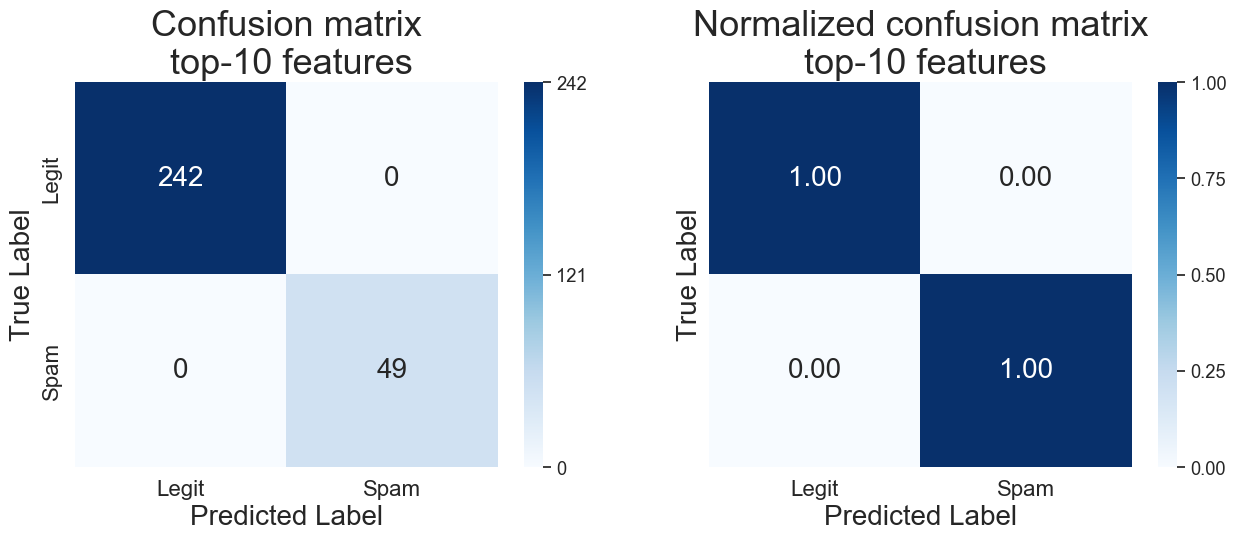

In [262]:
# evaluate
# evaluating performance:
totalTestLabelsModifiedNew = [i for i in totalTestLabelsModified] 
totalReconstructedLabels = [i for i in reconstructedLabels]  
totalReconstructedLabels.extend(legit_test_labels)


(accuracy_NB_Bernoulli_Modified_10,
 precision_NB_Bernoulli_Modified_10, 
 recall_NB_Bernoulli_Modified_10, 
 f1_NB_Bernoulli_Modified_10) = evaluateResults(totalTestLabelsModifiedNew, totalReconstructedLabels,10,latency_NB_Bernoulli_Modified_10)



In [263]:
len(totalTestLabelsModified)

291

In [96]:
def C(x,selectedWords_10,spamWordsTrainDict,legitWordsTrainDict):
    spamPX = 1  # probability of X given spam
    legitPX = 1 # probability of X given legit

    totalNumberWordSpam = 0
    totalNumberWordLegit = 0
    i=0
    for word in selectedWords_10:
        if word in spamWordsTrainDict:
            totalNumberWordSpam = spamWordsTrainDict[word]
        else:
            totalNumberWordSpam = 1
        if word in legitWordsTrainDict:
            totalNumberWordLegit = legitWordsTrainDict[word]
        else:
            totalNumberWordLegit = 1
        pSpam = (totalNumberWordSpam+1)/(numSpamMailsTrain+2)    #p_{i,s} for spam
        pLegit = (totalNumberWordLegit+1)/(numLegitMailsTrain+2) #p_{i,s} for legit
        spamPX = spamPX * (pSpam ** x[i]) * ((1 - pSpam)**(1 - x[i]))    #p{x|spam}
        legitPX = legitPX * (pLegit** x[i]) * ((1 - pLegit)**(1 - x[i]))#p{x|legit}
        i+=1

    pSpamX = (spamPX * spamP) / ((spamP * spamPX) + (legitP * legitPX)) # P{spam|x}
    pLegitX = (legitPX * legitP) / ((spamP * spamPX) + (legitP * legitPX))# P{legit|x}
    
    r = pSpamX/pLegitX
    if  r > 1:
        yhat = 1
    else:
        yhat = 0
  
    return (pSpamX,pLegitX,yhat)

In [97]:
#check
totalTestData = spam_test_binary.copy()
totalTestData.extend(legit_test_binary)

totalTestlabels = spam_test_labels.copy()
totalTestlabels.extend(legit_test_labels)


# for all test data:
spamP = (numSpamMailsTrain+1)/(numSpamMailsTrain + numLegitMailsTrain +2)
legitP = (numLegitMailsTrain+1)/(numSpamMailsTrain + numLegitMailsTrain +2)

predLabels = []
pSpamX_all = []
pLegitX_all = []
for x in totalTestData:
    (pSpamX,pLegitX,yhat)=C(x,selectedWords_10,spamWordsTrainDict,legitWordsTrainDict)
    pSpamX_all.append(pSpamX)
    pLegitX_all.append(pLegitX)
    predLabels.append(yhat)
    
#print(predLabels)
#print(pSpamX_all)

cm_NB_Bernoulli_10 = confusion_matrix(totalTestlabels, predLabels)
print("confusion matrix: ")
print(cm_NB_Bernoulli_10)

confusion matrix: 
[[235   7]
 [  9  40]]


In [98]:
mailIdx = 0
pSpamModifiedAll = []
pLegitModifiedAll = []
tmpTotalTestData = totalTestData.copy()
for mail in tmpTotalTestData:
    modifiedMail = mail
    if totalTestlabels[mailIdx] == 1:
        pSpamModified  = {}
        pLegitModified = {}
        wordIdx = 0
        for word in mail:
            if word == 0:
                modifiedMail[wordIdx] = 1 #modify mail by inserting a new word
                (pSpamX,pLegitX,yhat)=C(modifiedMail,selectedWords_10,spamWordsTrainDict,legitWordsTrainDict)
                pSpamModified[wordIdx]=pSpamX
                pLegitModified[wordIdx]=pLegitX
                modifiedMail[wordIdx] = 0 #roll back changes
            else:
                (pSpamX,pLegitX,yhat)=C(modifiedMail,selectedWords_10,spamWordsTrainDict,legitWordsTrainDict)
                pSpamModified[wordIdx]=pSpamX
                pLegitModified[wordIdx]=pLegitX
            wordIdx+=1
        pSpamModifiedAll.append(pSpamModified)
        pLegitModifiedAll.append(pLegitModified)
    mailIdx+=1

In [99]:
# sort probabilities
pSpamModifiedAllSorted = []

# the spam probabilities we sort in decreasing order:
for pSpamDict in pSpamModifiedAll:
    tmpSpamDict = {k: v for k, v in sorted(pSpamDict.items(), key=lambda item: item[1])}
    pSpamModifiedAllSorted.append(tmpSpamDict)
print(pSpamModifiedAllSorted[0])

# the legit probabilities we sort in increasing order:
pLegitModifiedAllSorted=[]
for pLegitDict in pLegitModifiedAll:
    tmpLegitDict = {k: v for k, v in sorted(pLegitDict.items(), key=lambda item: item[1], reverse=True)}
    pLegitModifiedAllSorted.append(tmpLegitDict)
print(pLegitModifiedAllSorted[0])

{3: 0.03346261043214825, 0: 0.06790524031095058, 4: 0.19047373160804248, 1: 0.8858287072537259, 9: 0.9901470182442819, 8: 0.9916808723599835, 2: 0.9941088568895775, 7: 0.9942812519914733, 5: 0.9944423104696856, 6: 0.9977396567336047}
{3: 0.9665373895678517, 0: 0.9320947596890493, 4: 0.8095262683919575, 1: 0.11417129274627415, 9: 0.009852981755718136, 8: 0.00831912764001656, 2: 0.005891143110422517, 7: 0.005718748008526781, 5: 0.005557689530314495, 6: 0.002260343266395374}


In [100]:
spamTestEmails = spam_test_binary.copy()
spamTestEmailsModified = []
costArray = []
mailIdx = 0
stop=0
for mail in spamTestEmails:
    costCounter = 0
    tmpModifiedSpamTestEmail = np.zeros((1,10))[0]
    for probDict in pSpamModifiedAllSorted:
        for prob in probDict:
            tmpModifiedSpamTestEmail[prob]=1
            costCounter+=1
            (pSpamX,pLegitX,yhat)=C(tmpModifiedSpamTestEmail,selectedWords_10,spamWordsTrainDict,legitWordsTrainDict)
            r = pSpamX/pLegitX
            if r<1:
                stop = 1
                break
        if stop:
            break
    spamTestEmailsModified.append(tmpModifiedSpamTestEmail) 
    costArray.append(costCounter)
    mailIdx+=1


In [101]:
totalTestDataModified = spamTestEmailsModified.copy()
totalTestDataModified.extend(legit_test_binary)

In [102]:
print(np.sum(costArray)/len(spam_test_binary))

1.0


confusion matrix: 
[[235   7]
 [  9  40]]
accuracy:  0.807560
precision: 0.000000
recall:    0.000000
f1:        0.000000


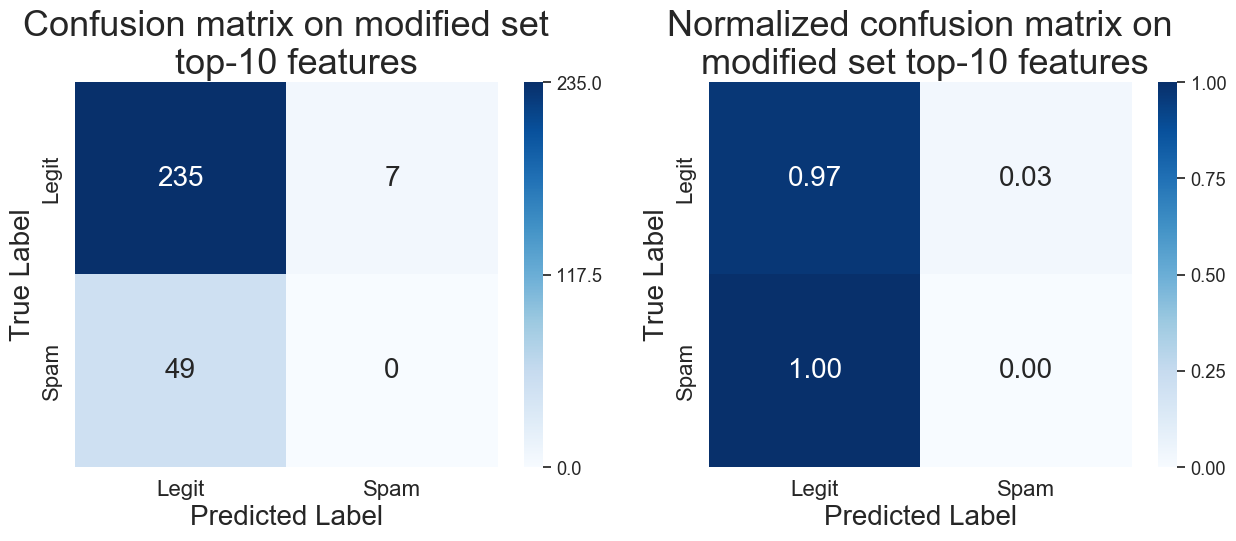

In [103]:
# perform classification on modified test data:
predLabelsModified = []
pSpamXModified = []
pLegitXModified = []
for x in totalTestDataModified:
    (pSpamX,pLegitX,yhat)=C(x,selectedWords_10,spamWordsTrainDict,legitWordsTrainDict)
    pSpamXModified.append(pSpamX)
    pLegitXModified.append(pLegitX)
    predLabelsModified.append(yhat)
    
#print(predLabelsModified)
#print(pSpamXModified)

cm_Modified_NB_Bernoulli_10 = confusion_matrix(totalTestlabels, predLabelsModified)
print("confusion matrix: ")
print(cm_NB_Bernoulli_10)

# calculates precision
accuracy_Modified_NB_Bernoulli_10 = accuracy_score(totalTestlabels, predLabelsModified)
print('accuracy:  %.6f' % accuracy_Modified_NB_Bernoulli_10)

# calculates precision
precision_Modified_NB_Bernoulli_10 = precision_score(totalTestlabels, predLabelsModified)
print('precision: %.6f' % precision_Modified_NB_Bernoulli_10)

# calculates recall
recall_Modified_NB_Bernoulli_10 = recall_score(totalTestlabels, predLabelsModified)
print('recall:    %.6f' % recall_Modified_NB_Bernoulli_10)

# calculates F1
f1_Modified_NB_Bernoulli_10 = f1_score(totalTestlabels, predLabelsModified)
print('f1:        %.6f' % f1_Modified_NB_Bernoulli_10)

# plot confusion matrix
fig, axn = plt.subplots(1,2, sharex=True, sharey=False,figsize=(15,5))

df_cm = pd.DataFrame(cm_Modified_NB_Bernoulli_10, index=['Legit','Spam'], columns=['Legit','Spam'])
sns.set(font_scale=1.2)  # for label size
sns.heatmap(df_cm, cbar_kws={'ticks': [0, np.max(cm_Modified_NB_Bernoulli_10)/2, np.max(cm_Modified_NB_Bernoulli_10)]}, vmin=0, vmax=np.max(cm_Modified_NB_Bernoulli_10),
                 annot=True, annot_kws={"size": 20}, fmt='d', cmap="Blues", ax=axn[0])  # font size
bottom, top = axn[0].get_ylim()
axn[0].set_ylim(bottom + 0.5, top - 0.5)
axn[0].set_yticklabels(['Legit','Spam'], rotation=90, fontsize="16", va="center")
axn[0].tick_params(axis='x', which='major', pad=10)
axn[0].set_xticklabels(['Legit','Spam'], rotation=0, fontsize="16", va="center")
axn[0].set_ylabel('True Label', fontsize="20")
axn[0].set_xlabel('Predicted Label', fontsize="20")
axn[0].set_title("Confusion matrix on modified set\n  top-10 features",fontsize="26")

norm_cm = confusion_matrix(totalTestlabels, predLabelsModified,normalize='true')
df_cm = pd.DataFrame(norm_cm, index=['Legit','Spam'], columns=['Legit','Spam'])

sns.set(font_scale=1.2)  # for label size
sns.heatmap(df_cm, cbar_kws={'ticks': [0, 0.25, 0.5, 0.75, 1]}, vmin=0, vmax=1,
                 annot=True, annot_kws={"size": 20}, fmt='2.2f', cmap="Blues", ax= axn[1])  # font size
bottom, top = axn[1].get_ylim()
axn[1].set_ylim(bottom + 0.5, top - 0.5)
axn[1].set_yticklabels(['Legit','Spam'], rotation=90, fontsize="16", va="center")
axn[1].tick_params(axis='x', which='major', pad=10)
axn[1].set_xticklabels(['Legit','Spam'], rotation=0, fontsize="16", va="center")
axn[1].set_ylabel('True Label', fontsize="20")
axn[1].set_xlabel('Predicted Label', fontsize="20")
axn[1].set_title("Normalized confusion matrix on\n modified set top-10 features",fontsize="26");

## Modifying classifier to prevent adversary classification attack

In [104]:
#check
totalTrainData = spam_train_binary.copy()
totalTrainData.extend(legit_train_binary)

totalTrainlabels = spam_train_labels.copy()
totalTrainlabels.extend(legit_train_labels)

mailIdx = 0
pSpamTrainModifiedAll = []
pLegitTrainModifiedAll = []
tmpTotalTrainData = totalTrainData.copy()
for mail in tmpTotalTrainData:
    modifiedMail = mail
    if totalTrainlabels[mailIdx] == 1:
        pSpamModified  = {}
        pLegitModified = {}
        wordIdx = 0
        for word in mail:
            if word == 0:
                modifiedMail[wordIdx] = 1 #modify mail by inserting a new word
                (pSpamX,pLegitX,yhat)=C(modifiedMail,selectedWords_10,spamWordsTrainDict,legitWordsTrainDict)
                pSpamModified[wordIdx]=pSpamX
                pLegitModified[wordIdx]=pLegitX
                modifiedMail[wordIdx] = 0 #roll back changes
            else:
                (pSpamX,pLegitX,yhat)=C(modifiedMail,selectedWords_10,spamWordsTrainDict,legitWordsTrainDict)
                pSpamModified[wordIdx]=pSpamX
                pLegitModified[wordIdx]=pLegitX
            wordIdx+=1
        pSpamTrainModifiedAll.append(pSpamModified)
        pLegitTrainModifiedAll.append(pLegitModified)
    mailIdx+=1

In [105]:
# sort probabilities
pSpamTrainModifiedAllSorted = []

# the spam probabilities we sort in decreasing order:
for pSpamDict in pSpamTrainModifiedAll:
    tmpSpamDict = {k: v for k, v in sorted(pSpamDict.items(), key=lambda item: item[1])}
    pSpamTrainModifiedAllSorted.append(tmpSpamDict)
print(pSpamTrainModifiedAllSorted[0])

# the legit probabilities we sort in increasing order:
pLegitTrainModifiedAllSorted=[]
for pLegitDict in pLegitTrainModifiedAll:
    tmpLegitDict = {k: v for k, v in sorted(pLegitDict.items(), key=lambda item: item[1], reverse=True)}
    pLegitTrainModifiedAllSorted.append(tmpLegitDict)
print(pLegitTrainModifiedAllSorted[0])

{3: 0.34722239169577096, 0: 0.5281449597614843, 4: 0.7833141662492432, 1: 0.9916808723599835, 8: 0.9916808723599835, 9: 0.9993527299965633, 2: 0.9996144356848735, 7: 0.9996257792711547, 5: 0.9996363735872806, 6: 0.9998525679809044}
{3: 0.652777608304229, 0: 0.4718550402385158, 4: 0.21668583375075678, 1: 0.00831912764001656, 8: 0.00831912764001656, 9: 0.0006472700034367584, 2: 0.000385564315126499, 7: 0.0003742207288453253, 5: 0.0003636264127193974, 6: 0.00014743201909559904}


In [106]:
spamTrainEmails = spam_train_binary.copy()
spamTrainEmailsModified = []
costTrainArray = []
mailIdx = 0
stop=0
for mail in spamTrainEmails:
    costCounter = 0
    tmpModifiedSpamTrainEmail = np.zeros((1,10))[0]
    for probDict in pSpamTrainModifiedAllSorted:
        for prob in probDict:
            tmpModifiedSpamTrainEmail[prob]=1
            costCounter+=1
            (pSpamX,pLegitX,yhat)=C(tmpModifiedSpamTrainEmail,selectedWords_10,spamWordsTrainDict,legitWordsTrainDict)
            r = pSpamX/pLegitX
            if r<1:
                stop = 1
                break
        if stop:
            break
    spamTrainEmailsModified.append(tmpModifiedSpamTrainEmail) 
    costTrainArray.append(costCounter)
    mailIdx+=1


In [107]:
totalTrainDataModified = spamTrainEmailsModified.copy()
totalTrainDataModified.extend(legit_train_binary)

totalTrainlabels = spam_train_labels.copy()
totalTrainlabels.extend(legit_train_labels)



In [108]:
totalTrainData = spam_train_binary.copy()
totalTrainData.extend(legit_train_binary)

totalTrainlabels = spam_train_labels.copy()
totalTrainlabels.extend(legit_train_labels)


totalTestData = spam_test_binary.copy()
totalTestData.extend(legit_test_binary)

totalTestlabels = spam_test_labels.copy()
totalTestlabels.extend(legit_test_labels)

clf = BernoulliNB()
clf.fit(totalTrainData, totalTrainlabels)

predLabelsTest = clf.predict(totalTestData)

cm = confusion_matrix(totalTestlabels, predLabelsTest)
print("confusion matrix: ")
print(cm)


predLabelsTest = clf.predict(totalTestDataModified)

cm = confusion_matrix(totalTestlabels, predLabelsTest)
print("confusion matrix: ")
print(cm)


confusion matrix: 
[[235   7]
 [  9  40]]
confusion matrix: 
[[235   7]
 [ 49   0]]


In [109]:
print(pLegitX_all[0],pSpamX_all[0])
probs = clf.predict_proba(totalTestData)
print(probs[0])

0.11417129274627415 0.8858287072537259
[0.11412471 0.88587529]


## train and test the classifier on the modified  data

In [110]:
clf = BernoulliNB()
clf.fit(totalTrainDataModified, totalTrainlabels)
predLabelsTestModified = clf.predict(totalTestDataModified)
cm = confusion_matrix(predLabelsTestModified, predLabelsTest)
print("confusion matrix: ")
print(cm)

confusion matrix: 
[[231   7]
 [ 53   0]]
